In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import glob
import pandas as pd
import numpy as np
import astropy.units as u
from datetime import date
from random import choices
from math import factorial, erf
from astroquery.simbad import Simbad
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm, uniform
import h5py
from sklearn.neighbors import KernelDensity
from scipy.integrate import simps
from scipy import stats
from matplotlib.ticker import AutoMinorLocator
from astropy.io import ascii
from IPython.display import clear_output
import time


In [2]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'primordial disks': [(0/255, 26/255, 26/255),
                                         (41/255, 163/255, 163/255),
                                         (179/255, 255/255, 217/255)],
                    'debris disks': [(15/255, 15/255, 62/255),
                                      (102/255, 102/255, 255/255),
                                      (255/255, 204/255, 255/255)],
                    'hot jupiters': [(15/255, 15/255, 62/255),
                                     (102/255, 102/255, 255/255),
                                     (255/255, 250/255, 255/255)],
                    'warm jupiters': [(51/255, 26/255, 0/255),
                                      (255/255, 80/255, 80/255),
                                      (255/255, 255/255, 204/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    'raspberry punch1': [(51/255, 0/255, 102/255),
                                        (51/255, 204/255, 224/255),
                                        (248/255, 255/255, 230/255)],
                    'raspberry punch2': [(70/255, 0/255, 0/255),
                                        (89/255, 0/255, 179/255),
                                        (51/255, 204/255, 224/255),
                                        (255/255, 255/255, 200/255)],
                    'raspberry punch': [(51/255, 0/255, 102/255),
                                        # (89/255, 0/255, 179/255),
                                        (51/255, 204/255, 224/255),
                                        (255/255, 255/255, 200/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap

plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')
# plt.rcParams.keys()

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [3]:
def unique(list_of_values):
    unique_values = []
    for _, value in enumerate(list_of_values):
        if value in unique_values:
            pass
        else:
            unique_values.append(value)
    return unique_values

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def factorial(number):
    fact = 1
    for i in range(1, number+1):
        fact = fact * i
    return fact

def weighted_mean(meas, meas_err):
    try:
        weight = 1./(np.array(meas_err)**2)
    except:
        print('Error calculating weighted mean!')
        print(meas, ',', meas_err)
    else:
        w_mean = sum(weight * np.array(meas)) / sum(weight)
        w_mean_err = 1./np.sqrt(sum(weight))

    return w_mean, w_mean_err

def i_unc(x, PDF):
    CDF = []
    for x_i in range(len(x)):
        CDF.append(np.trapz(PDF[0:x_i], x[0:x_i]))

    # plt.plot(x, CDF)

    where_peak = np.where(PDF == max(PDF))[0][0]
    sig1_perc = 1 - 0.6826
    sig2_perc = 1 - 0.9544
    sig1_sub = abs(np.array(CDF) - sig1_perc)
    sig2_sub = abs(np.array(CDF) - sig2_perc)

    where_sig1 = np.where(sig1_sub == min(sig1_sub))[0]
    where_sig2 = np.where(sig2_sub == min(sig2_sub))[0]
    sig1 = x[where_peak] - x[where_sig1]
    sig2 = x[where_peak] - x[where_sig2]

    if len(sig1) > 1:
        sig1 = float('nan')
        sig2 = float('nan')
    else:
        sig1 = sig1[0]
        sig2 = sig2[0]

    return sig1, sig2

def sigfig(value, uncertainty, return_uncertainty=True, cutoff=35):
    exp = np.floor(np.log10(uncertainty))
    if uncertainty / 10**(exp - 1) < cutoff:
        exp -= 1
    
    exp *= -1
    exp = int(exp)

    value_rounded = round(value, exp)

    # needed to avoid -0.0 being printed in table
    value_rounded_str = str(value_rounded)
    value_rounded_str_only_digits = value_rounded_str.replace('.', '').replace('-', '')
    if value_rounded_str.find('-') != -1 and value_rounded_str_only_digits == len(value_rounded_str_only_digits) * '0':
        value_rounded *= -1

    uncertainty_rounded = round(uncertainty, exp)
    
    if uncertainty_rounded < cutoff / 10:
        # in this case, exp represents number of decimal places to include
        output_tuple = f"{value_rounded:.{exp}f}", f"{uncertainty_rounded:.{exp}f}"
        return output_tuple if return_uncertainty else output_tuple[0]
    else:
        output_tuple = f"{int(value_rounded)}", f"{int(uncertainty_rounded)}"
        return output_tuple if return_uncertainty else output_tuple[0]

def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")
    
    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()

def median_pm_confidence_interval(x, pdf_y, sigma=0.6826):
    """
    Calculates output for median +- 1 sigma column.
    Parameters
    ----------
    par_chain : array_like
        Array of parameter
    sigma_per : float, optional
        Area under +- 1 sigma
    
    Returns
    -------
    str : Latex expression to go in final table
    """
    lower_bound, median, upper_bound = quantile(x, [0.5 - sigma / 2, 0.5, 0.5 + sigma / 2], pdf_y)

    if np.isnan(median) == False:
        lower_sig = abs(median - lower_bound)
        upper_sig = abs(upper_bound - median)
    else:
        median = float('nan')
        lower_sig = float('nan')
        upper_sig = float('nan')

    # if median == 0.:
    #     lower_sig = 0
    # elif lower_sig > mode:
    #     lower_sig = mode
    # if median == 90:
    #     upper_sig = 0
    # elif upper_sig > 90 - mode:
    #     upper_sig = 90 - mode

    return median, lower_sig, upper_sig

def mode_pm_highest_density_interval(x, pdf_y, sigma, return_pdf=False):
    # 1sigma makes sigma = 0.6826

    x_interp = np.arange(0, 90+0.01, 0.001)
    pdf_y = np.interp(x=x_interp, xp=x, fp=pdf_y)
    x = x_interp

    cdf_y = np.cumsum(pdf_y)
    cdf_y = cdf_y / cdf_y[-1]  # Normalize the cdf so that it sums to 1.

    delta_xlist = []
    xlower = []
    xupper = []

    sigma_lower = 0
    delta = 1e-6

    for _ in range(0,round((1 - sigma)/delta)):
        x1 = np.interp(sigma_lower,cdf_y,x)
        xu = np.interp(sigma,cdf_y,x)
        delta_xlist.append(xu-x1)
        xlower.append(x1)
        xupper.append(xu)
        sigma += delta
        sigma_lower += delta

    index = delta_xlist.index(min(delta_xlist))
    mode = np.mean(x[pdf_y == max(pdf_y)]).round(1)
    mode = x[pdf_y == max(pdf_y)]
    if len(mode) > 1:
        mode = np.mean(mode)
    else:
        mode = mode[0]
    # print('The lower x value (for minimum credible interval) is ', xlower[index])
    # print('The upper x value (for minimum credible interval) is ', xupper[index])

    lower = mode - xlower[index]
    upper = xupper[index] - mode

    if return_pdf == True:
        return mode, lower, upper, x, pdf_y
    if return_pdf == False:
        return mode, lower, upper

def SpType_num_to_str(sptype_num, sptype_num_err):

    sptype_base_num = int(np.floor(sptype_num))

    if sptype_base_num == 3:
        sptype_str_letter = 'G'
    if sptype_base_num == 4:
        sptype_str_letter = 'K'
    if sptype_base_num == 5:
        sptype_str_letter = 'M'

    sptype_cat_num = np.round((sptype_num - sptype_base_num) * 10, 1)
    sptype_cat_str = str(sptype_cat_num)

    sptype_str = sptype_str_letter + sptype_cat_str

    sptype_num_err = np.round(sptype_num_err * 10, 1)
    if sptype_num_err == 0.0:
        sptype_num_err = 0.01
    sptype_str_err = str(sptype_num_err)

    return sptype_str, sptype_str_err

def determine_sptype(let_val, num_val):

    possible_letters = {'B': 0,
                        'A': 1,
                        'F': 2,
                        'G': 3,
                        'K': 4,
                        'M':5,
                        }

    temp_val = []
    if '-' in let_val:
        let_val_split = str(let_val).replace(' ', '').split('-')
        num_val_split = str(num_val).replace(' ', '').split('-')
        val1 = possible_letters[let_val_split[0]] + 0.1*float(num_val_split[0])
        val2 = possible_letters[let_val_split[1]] + 0.1*float(num_val_split[1])
        temp_val = [val1, val2]
    else:
        temp_val.append(possible_letters[let_val] + 0.1*float(num_val))
    
    if len(temp_val) > 1:
        adopted_val = np.mean(temp_val)
        adopted_val_err = np.std(temp_val, ddof=1)
    if len(temp_val) == 1:
        adopted_val = temp_val[0]
        adopted_val_err = 0.1

    
    return adopted_val, adopted_val_err

def clean_dataframe(df, dataset):
    keep_columns = ['Target',
                    'SpType', 'SpType Letter', 'SpType Number', 'SpType Decimal', 'SpType Decimal Unc',
                    'Teff (K)', 'Teff Unc',
                    'Mstar (Msun)', 'Mstar Unc',
                    'Rstar (Rsun)', 'Rstar Unc',
                    'Prot (d)', 'Prot Unc',
                    'vsini (km/s)', 'vsini Unc',
                    'i disk (deg)', 'i disk Unc',
                    ]
    dict_clean = {}
    for _, key in enumerate(keep_columns):
        dict_clean[key] = []
    for _, col in enumerate(df.columns):
        if col == 'Target':
            targets = df['Target'].values
            for _, targ in enumerate(targets):
                dict_clean['Target'].append(targ)
        elif col in ['i disk Unc', 'SpType Letter', 'SpType Number', 'SpType Decimal', 'SpType Decimal Unc', 'vsini Unc']:
            if dataset != 'PD':
                continue
            else:
                if col == 'i disk Unc' or col == 'vsini Unc':
                    continue
        elif col == 'SpType':
            dict_clean['SpType'] = df['SpType'].values
            dict_clean['SpType Letter'] = df['SpType Letter'].values
            for indx in range(len(df['SpType Letter'].values)):
                dict_clean['SpType Number'].append(df['SpType Number'].values[indx])
                updated_val, _ = determine_sptype(df['SpType Letter'].values[indx], df['SpType Number'].values[indx])
                dict_clean['SpType Decimal'].append(updated_val)
                dict_clean['SpType Decimal Unc'].append(0.001)
        elif col == 'i disk (deg)':
            idisk_strings = df['i disk (deg)'].values
            idisk_err_strings = df['i disk Unc'].values
            for indx2 in range(len(idisk_strings)):
                idisk_str = idisk_strings[indx2]
                idisk_err_str = idisk_err_strings[indx2]
                if type(idisk_str) == str:
                    if '[' in idisk_str:
                        val1 = float(idisk_str.replace('[', '').replace(']', '').split(',')[0])
                        val2 = float(idisk_str.replace('[', '').replace(']', '').split(',')[1])
                        val = np.mean([val1, val2])
                        val_err = abs(val - val1)
                    else:
                        val = float(idisk_str)
                        val_err = float(idisk_err_str)
                else:
                    val = idisk_str
                    val_err = idisk_err_str
                dict_clean['i disk (deg)'].append(val)
                dict_clean['i disk Unc'].append(val_err)
        elif col == 'vsini (km/s)':
            vsini_strings = df['vsini (km/s)'].values
            vsini_err_strings = df['vsini Unc'].values
            for indx3 in range(len(vsini_strings)):
                vsini_str = vsini_strings[indx3]
                vsini_err_str = vsini_err_strings[indx3]
                if type(vsini_str) == str:
                    if '<' in vsini_str:
                        val = float(vsini_str.replace('<', ''))
                        val_err = 'ulimit'
                    else:
                        val = float(vsini_str)
                        val_err = float(vsini_err_str)
                else:
                    val = float(vsini_str)
                    val_err = float(vsini_err_str)
                dict_clean['vsini (km/s)'].append(val)
                dict_clean['vsini Unc'].append(val_err)
        elif col in keep_columns:
            vals = df[col].values
            for _, val_str in enumerate(vals):
                val = float(val_str)
                dict_clean[col].append(val)
        else:
            continue

    # if dataset == 'PD':
    #     for _, key in enumerate(dict_clean.keys()):
    #         print(key, len(dict_clean[key]))
    
    df_clean = pd.DataFrame(dict_clean)
    
    return df_clean









In [4]:
customSimbad = Simbad()
customSimbad.add_votable_fields('ra(2;A;ICRS;J2017.5;2000)', 'dec(2;D;ICRS;J2017.5;2000)',
                                'sp', 'sp_nature', 'sp_bibcode',
                                'flux(R)', 'flux(I)', 'flux(V)', 'flux(K)')
customSimbad.remove_votable_fields('coordinates')
customSimbad.TIMEOUT = 4 * 60 # sets the timeout to 4 min
customSimbad.ROW_LIMIT = -1

In [5]:
main_directory = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/'
data_directory = main_directory+'Tables/Condensed_Sample_By_Date/'
tables_dictionary = main_directory+'Tables/'
test_figures_directory = main_directory + 'Test_Figures/'
final_figures_directory = main_directory + 'Final_Figures/'





In [7]:
read_local = False

if read_local != True:
    today = date.today()
    date_str = today.strftime("%Y-%b-%d")

    PD_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1Xjpm2m3hxQACorlvKcwqjBnBKssgK8MCFyijPfVseFg/edit#gid=0"
    DD_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1Lz2p6EdhytAR2_HvcPY543MrRbRoB7d7Hj5yp1E8XsM/edit#gid=0"
    WJ_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1B8ep95z7EaXZ6x-fRjntDTN3i8LQUmNRGMBrc5G6bV4/edit#gid=0"
    HJ_properties_sheet_url = "https://docs.google.com/spreadsheets/d/1k5oKAUum9d-s5JaD3HDRDlMZqn_pPGvRyFvB4kw8WE0/edit#gid=0"


    url_PD_properties = PD_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_DD_properties = DD_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_WJ_properties = WJ_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_HJ_properties = HJ_properties_sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

    df_PD_goog = pd.read_csv(url_PD_properties)
    df_DD_goog = pd.read_csv(url_DD_properties)
    df_HJ_goog = pd.read_csv(url_HJ_properties)
    df_WJ_goog = pd.read_csv(url_WJ_properties)


else:
    date_str = '2023-Dec-9'
    raw_df = pd.read_excel(main_directory + 'Primordial_Disks_9-Dec-2023.xlsx')

In [8]:
date_str = '2024-Sep-05'

skip_PD = False
skip_DD = False
skip_WJ = False
skip_HJ = False

sampling_resolution = 'high'
resolution_text = sampling_resolution + 'Res'
if sampling_resolution == 'high':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/High/'
if sampling_resolution == 'med':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/Med/'
if sampling_resolution == 'low':
    probability_distributions_dir = main_directory + 'Tables/Probability_Distributions/Low/'

do_save_probability_distributions = True
do_save_plots = True

plot_lightfigure = False
plot_transparent = False

if plot_lightfigure == True:
    hist_linecolor = '#9e0da5'  # Histogram
    point_color = '#b3d9ff'  # veq - vsini
    zeroline_color = '#e6e6e6'  # veq - vsini
    edge_color = '#b3d9ff'  # par vs. Delta i 
    point_color_no_z = '#b3d9ff'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle_light.mplstyle')
else:
    hist_linecolor = '#2f0431'  # Histogram
    zeroline_color = '#404040'  # veq - vsini
    point_color = '#003366'   # veq - vsini
    edge_color = '#005580'  # par vs. Delta i 
    point_color_no_z = '#0086b3'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')

if plot_transparent == True:
    transparent_text = 'transparent'
else:
    transparent_text = 'opaque'

if plot_lightfigure == True:
    light_or_dark_dext = 'light'
else:
    light_or_dark_dext = 'dark'


print('\nUsing date_str = ' + date_str + '\n')

save_csv_filepath_PD = data_directory + 'adopted_' + resolution_text + '_PD_' + date_str + '.csv'
save_csv_filepath_DD = data_directory + 'adopted_' + resolution_text + '_DD_' + date_str + '.csv'
save_csv_filepath_WJ = data_directory + 'adopted_' + resolution_text + '_WJ_' + date_str + '.csv'
save_csv_filepath_HJ = data_directory + 'adopted_' + resolution_text + '_HJ_' + date_str + '.csv'


if skip_PD != True:
    print('TABLE WITH PD PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_PD.split('/')[-1])
if skip_DD != True:
    print('TABLE WITH DD PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_DD.split('/')[-1])
if skip_WJ != True:
    print('TABLE WITH WJ PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_WJ.split('/')[-1])
if skip_HJ != True:
    print('TABLE WITH HJ PROPERTIES WIILL BE SAVED TO: ', save_csv_filepath_HJ.split('/')[-1])


Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.



Using date_str = 2024-Sep-05

TABLE WITH PD PROPERTIES WIILL BE SAVED TO:  adopted_highRes_PD_2024-Sep-05.csv
TABLE WITH DD PROPERTIES WIILL BE SAVED TO:  adopted_highRes_DD_2024-Sep-05.csv
TABLE WITH WJ PROPERTIES WIILL BE SAVED TO:  adopted_highRes_WJ_2024-Sep-05.csv
TABLE WITH HJ PROPERTIES WIILL BE SAVED TO:  adopted_highRes_HJ_2024-Sep-05.csv


In [9]:

def compute_obliquities(df, which_list, resolution, posteriors_csv_dir, posteriors_fig_dir, save_stuff, plot_stuff):


    target_list = df['Target'].values

    if resolution == 'high':
        n_draws = int(5e6)
        sampling_res = 0.01
        smooth_over_deg = 0.5
    elif resolution == 'med':
        n_draws = int(1e6)
        sampling_res = 0.5
        smooth_over_deg = 3
    else:
        n_draws = int(1e4)
        sampling_res = 1.0
        smooth_over_deg = 5
    
    istars = np.arange(0, 90+sampling_res, sampling_res)
    i_bins = np.concatenate((istars, np.array([istars[-1] + sampling_res])))



    istar = []
    istar_err_p = []
    istar_err_m = []
    idiff = []
    idiff_err_p = []
    idiff_err_m = []
    eq_vel = []
    eq_vel_err = []
    for targ_i, target in enumerate(target_list):

        print('~~~~~~~~~~~~~~~~~~~~~~ ' + which_list + ' ~~~~~~~~~~~~~~~~~~~~~~')
        print(target)

        target_str = target.replace(' ', '')

        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i STAR PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        vsini = df['vsini (km/s)'].values[targ_i]
        sigma_vsini = df['vsini Unc'].values[targ_i]

        Prot = (df['Prot (d)'].values[targ_i] * u.d).to(u.s).value
        sigma_Prot = (df['Prot Unc'].values[targ_i] * u.d).to(u.s).value
        
        Rstar = (df['Rstar (Rsun)'].values[targ_i] * u.Rsun).to(u.km).value
        sigma_Rstar = (df['Rstar Unc'].values[targ_i] * u.Rsun).to(u.km).value

        veq = (2 * np.pi * Rstar)/(Prot)
        sigma_veq = veq * np.sqrt((sigma_Rstar/Rstar)**2 + (sigma_Prot/Prot)**2)

        sini = np.sin(np.radians(istars))

        if sigma_vsini != 'ulimit':
            # print(vsini, type(vsini))
            # print(veq, type(veq))
            # print(sini, type(sini))
            part1 = vsini - veq * sini
            part2 = 2 * (sigma_vsini**2 + sigma_veq**2 * sini**2)
            i_star_dist = sini * (np.exp(-(part1**2)/part2))/np.sqrt(part2)
        else:
            i_star_dist_list = []
            for sini_element in range(len(sini)):
                part1 = vsini - veq * sini[sini_element]
                part2 = np.sqrt(2) * sigma_veq * sini[sini_element]
                part3 = np.sqrt(2) * np.pi * Rstar
                part4 = sigma_veq * Prot
                istar_element = sini[sini_element] * (erf(part1/part2) + erf(part3/part4))
                i_star_dist_list.append(istar_element)
            i_star_dist = np.array(i_star_dist_list)

        nan_elements = np.where(np.isnan(i_star_dist) == True)[0]
        if len(nan_elements) > 0:
            print(nan_elements)
        if len(nan_elements) == 1:
            if nan_elements[0] == 0:
                i_star_dist[0] = i_star_dist[1]

        # istars = istars[np.isnan(i_star_dist) == False]
        # i_star_dist = i_star_dist[np.isnan(i_star_dist) == False]

        i_star_dist = i_star_dist / (sum(i_star_dist) * sampling_res)

        # -------------------------------- i STAR UNCERTAINTY --------------------------------- #
        i_star_MAP, sig1_i_star_m, sig1_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.6826)
        _, sig2_i_star_m, sig2_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.9540)




        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i DISK PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #

        disk_val = df['i disk (deg)'].values[targ_i]
        if type(disk_val) == str:
            disk_val = disk_val.replace('[', '')
            disk_val = disk_val.replace(']', '')
            disk_val_min = float(disk_val.split(',')[0])
            disk_val_max = float(disk_val.split(',')[1])
            i_disk_dist = uniform.pdf(x=istars, loc=disk_val_min, scale=disk_val_max-disk_val_min)
            # -------------------------------- i DISK UNCERTAINTY --------------------------------- #
            i_disk_MAP = 0.5 * (disk_val_max - disk_val_min)
            sig1_i_disk_m = abs(i_disk_MAP - disk_val_min)
            sig1_i_disk_p = abs(disk_val_max - i_disk_MAP)
            sig2_i_disk_m = sig1_i_disk_m
            sig2_i_disk_p = sig1_i_disk_p
        else:
            i_disk_dist = norm.pdf(x=istars, loc=df['i disk (deg)'].values[targ_i], scale=df['i disk Unc'].values[targ_i])
            # -------------------------------- i DISK UNCERTAINTY --------------------------------- #
            i_disk_MAP, sig1_i_disk_m, sig1_i_disk_p = df['i disk (deg)'].values[targ_i], df['i disk Unc'].values[targ_i], df['i disk Unc'].values[targ_i]
            _, sig2_i_disk_m, sig2_i_disk_p = df['i disk (deg)'].values[targ_i], 2 * df['i disk Unc'].values[targ_i], 2 * df['i disk Unc'].values[targ_i]




        # ------------------------------------------------------------------------------------- #
        # --------------------- COMPUTE DELTA i PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        i_disk_rand = choices(istars, i_disk_dist, k=n_draws)
        i_star_rand = choices(istars, i_star_dist, k=n_draws)
        i_diff_rand = abs(np.array(i_disk_rand) - i_star_rand)

        bin_vals_i_diff, _ = np.histogram(i_diff_rand, bins=i_bins)  # , density=True)

        smooth_over_points = int(smooth_over_deg/sampling_res)
        smooth_vals_i_diff = gaussian_filter1d(bin_vals_i_diff, smooth_over_points)

        i_diff_dist_smooth = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * sampling_res)
        i_diff_dist_rough = bin_vals_i_diff / (sum(bin_vals_i_diff) * sampling_res)

        smooth_on = True
        if smooth_on == True:
            i_diff_dist = np.copy(i_diff_dist_smooth)
        else:
            i_diff_dist = np.copy(i_diff_dist_rough)

        # -------------------------------- DELTA i UNCERTAINTY --------------------------------- #
        i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.6826)
        _, sig2_i_diff_m, sig2_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.9540)








        # -------------------------------- SAVE STUFF --------------------------------- #
        if save_stuff == True:
            probability_densities = pd.DataFrame({'i (deg)':  istars,
                                                  'P(i Disk | d)': i_disk_dist,
                                                  'P(i Star | d)': i_star_dist,
                                                  'P(Delta i | d)': i_diff_dist_smooth,
                                                  'i Disk MAP' : [i_disk_MAP]*len(istars),
                                                  'i Disk -Unc1' : [sig1_i_disk_m]*len(istars),
                                                  'i Disk +Unc1' : [sig1_i_disk_p]*len(istars),
                                                  'i Disk -Unc2' : [sig2_i_disk_m]*len(istars),
                                                  'i Disk +Unc2' : [sig2_i_disk_p]*len(istars),
                                                  'i Star MAP' : [i_star_MAP]*len(istars),
                                                  'i Star -Unc1' : [sig1_i_star_m]*len(istars),
                                                  'i Star +Unc1' : [sig1_i_star_p]*len(istars),
                                                  'i Star -Unc2' : [sig2_i_star_m]*len(istars),
                                                  'i Star +Unc2' : [sig2_i_star_p]*len(istars),
                                                  'Delta i MAP' : [i_diff_MAP]*len(istars),
                                                  'Delta i -Unc1' : [sig1_i_diff_m]*len(istars),
                                                  'Delta i +Unc1' : [sig1_i_diff_p]*len(istars),
                                                  'Delta i -Unc2' : [sig2_i_diff_m]*len(istars),
                                                  'Delta i +Unc2' : [sig2_i_diff_p]*len(istars),
                                                  })
            
            probability_densities.to_csv(posteriors_csv_dir+ 'Posteriors_' + target_str + '_' + which_list + '.csv', index=False)

            probability_densities_rough = pd.DataFrame({'i (deg)':  istars,
                                                        'P(i Disk | d)': i_disk_dist,
                                                        'P(i Star | d)': i_star_dist,
                                                        'P(Delta i | d)': i_diff_dist_rough,
                                                        'i Disk MAP' : [i_disk_MAP]*len(istars),
                                                        'i Disk -Unc1' : [sig1_i_disk_m]*len(istars),
                                                        'i Disk +Unc1' : [sig1_i_disk_p]*len(istars),
                                                        'i Disk -Unc2' : [sig2_i_disk_m]*len(istars),
                                                        'i Disk +Unc2' : [sig2_i_disk_p]*len(istars),
                                                        'i Star MAP' : [i_star_MAP]*len(istars),
                                                        'i Star -Unc1' : [sig1_i_star_m]*len(istars),
                                                        'i Star +Unc1' : [sig1_i_star_p]*len(istars),
                                                        'i Star -Unc2' : [sig2_i_star_m]*len(istars),
                                                        'i Star +Unc2' : [sig2_i_star_p]*len(istars),
                                                        'Delta i MAP' : [i_diff_MAP]*len(istars),
                                                        'Delta i -Unc1' : [sig1_i_diff_m]*len(istars),
                                                        'Delta i +Unc1' : [sig1_i_diff_p]*len(istars),
                                                        'Delta i -Unc2' : [sig2_i_diff_m]*len(istars),
                                                        'Delta i +Unc2' : [sig2_i_diff_p]*len(istars),
                                                        })
            
            probability_densities_rough.to_csv(posteriors_csv_dir+ 'Posteriors_Rough_' + target_str + '_' + which_list + '.csv', index=False)







        print_stuff = True
        # -------------------------------- PRINT STUFF --------------------------------- #
        if print_stuff == True:
            print('i_disk: {:.2f} -/+{:.2f} '.format(i_disk_MAP, sig1_i_disk_p))
            print('i_star: {:.2f} -{:.2f} +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p))
            print('i_diff: {:.2f} -{:.2f} +{:.2f}\n'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p))










        # -------------------------------- PLOT STUFF --------------------------------- #
        if plot_stuff == True:
            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i DISK ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_disk_rand) == False)[0]) > 0:
                
                fig_i_disk_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_disk_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Disk Inclination')
                ax.set_xlabel(r'$i_{disk}$ ($^\degree$)', labelpad=12)
                ax.set_ylabel(r'$P$ ($i_{disk}$ | $i$)', labelpad=12)
                ax.minorticks_on()

                # fill_color = '#3d4d5c'
                fill_color = '#cc8800'  # '#527a7a'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2
                
                sig1_idisk_val_l = i_disk_MAP - sig1_i_disk_m
                sig2_idisk_val_l = i_disk_MAP - sig2_i_disk_m
                sig1_sub_l = np.array(abs(istars - sig1_idisk_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_idisk_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idisk_val_r = i_disk_MAP + sig1_i_disk_p
                sig2_idisk_val_r = i_disk_MAP + sig2_i_disk_p
                sig1_sub_r = np.array(abs(istars - sig1_idisk_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idisk_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]

                ax.plot(istars, i_disk_dist, color='#000000', lw=4, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_disk_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_disk_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)

                ymin, ymax = 0, 1.20*max(i_disk_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_{disk}$  MAP = ' + '{:.2f} +/- {:.2f}'.format(i_disk_MAP, sig1_i_disk_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                
                fig_i_disk_dist.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_idisk.pdf')
                # plt.show
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i STAR ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if np.isnan(np.nanmax(i_star_dist)) == False:

                fig_i_star = plt.figure(figsize=(8, 7))
                ax = fig_i_star.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Stellar Inclination')
                ax.set_xlabel(r'$i_{*}$ ($^\degree$)', labelpad=12, fontsize=16)
                ax.set_ylabel(r'$P$ ($i_{*}$ | $P_{rot}$, $R_{*}$, $v\mathrm{sin}i$)', labelpad=12)
                ax.minorticks_on()

                ymin, ymax = 0, 1.20*max(i_star_dist)
                xmin, xmax = 0, 90

                fill_color = '#8542c5'  # '#739900'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2

                sig1_ival_l = i_star_MAP - sig1_i_star_m
                sig2_ival_l = i_star_MAP - sig2_i_star_m
                sig1_sub_l = np.array(abs(istars - sig1_ival_l))
                sig2_sub_l = np.array(abs(istars - sig2_ival_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_ival_r = i_star_MAP + sig1_i_star_p
                sig2_ival_r = i_star_MAP + sig2_i_star_p
                sig1_sub_r = np.array(abs(istars - sig1_ival_r))
                sig2_sub_r = np.array(abs(istars - sig2_ival_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_star_dist, color='black', lw=4, zorder=1)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_star_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=0)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_star_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=0)


                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)
                ax.set_xticks(np.arange(0,105,15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_*$  MAP' + ' = {:.2f}  -{:.2f}  +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)

                fig_i_star.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_istar.pdf')
                # plt.show()
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ----------------------------------- PLOT DELTA i ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_diff_dist) == False)[0]) > 0:
                
                fig_i_diff_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_diff_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title(r'Difference in $i$')
                ax.set_xlabel(r'$\Delta i$ ($^\degree$)', labelpad=12)
                ax.set_ylabel(r'$P$ ($\Delta i$ | $i_{*}$, $i_{disk}$)', labelpad=12)

                # fill_color = '#3d4d5c'
                fill_color = '#007399'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2


                sig1_diff_val_l = i_diff_MAP - sig1_i_diff_m
                sig2_diff_val_l = i_diff_MAP - sig2_i_diff_m
                sig1_sub_l = np.array(abs(istars - sig1_diff_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_diff_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idiff_val_r = i_diff_MAP + sig1_i_diff_p
                sig2_idiff_val_r = i_diff_MAP + sig2_i_diff_p
                sig1_sub_r = np.array(abs(istars - sig1_idiff_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idiff_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_diff_dist, color='#000000', lw=4, zorder=2)
                # ax.plot([i_diff_MAP, i_diff_MAP], [0, max(i_diff_dist)], '--', color='#000000', lw=2, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_diff_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_diff_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)


                ymin, ymax = 0, 1.20*max(i_diff_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, target,
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$\Delta i$  MAP = ' + '{:.2f}  -{:.2f}  +{:.2f}'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                    

                fig_i_diff_dist.savefig(posteriors_fig_dir + 'Inclinations/' + target_str + '_zDeltai.pdf')
                # plt.show()
                plt.close()


        istar.append(i_star_MAP)
        istar_err_p.append(sig1_i_star_p)
        istar_err_m.append(sig1_i_star_m)
        idiff.append(i_diff_MAP)
        idiff_err_p.append(sig1_i_diff_p)
        idiff_err_m.append(sig1_i_diff_m)
        eq_vel.append(veq)
        eq_vel_err.append(sigma_veq)
    
    df['i star (deg)'] = istar
    df['i star +Unc'] = istar_err_p
    df['i star -Unc'] = istar_err_m
    df['disk diff'] = idiff
    df['disk diff +Unc'] = idiff_err_p
    df['disk diff -Unc'] = idiff_err_m
    df['Veq'] = eq_vel
    df['Veq Unc'] = eq_vel_err

    return df


In [10]:
if skip_PD != True:
    df_PD_goog_clean = clean_dataframe(df=df_PD_goog, dataset='PD')
if skip_DD != True:
    df_DD_goog_clean = clean_dataframe(df=df_DD_goog, dataset='DD')
if skip_WJ != True:
    df_WJ_goog_clean = clean_dataframe(df=df_WJ_goog, dataset='WJ')
if skip_HJ != True:
    df_HJ_goog_clean = clean_dataframe(df=df_HJ_goog, dataset='HJ')

### Compute or Read In Obliquities

In [11]:
print('OPENING FILES...')

# PD PROPERTIES
if skip_PD!= True:
    print(save_csv_filepath_PD)
    df_PD = pd.read_csv(save_csv_filepath_PD)
    df_PD['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
    df_PD['vsini Unc'] = df_PD['vsini Unc'].astype(float)
    df_PD = df_PD.sort_values('Target')
    df_PD.loc[df_PD['i star (deg)'] > 90., 'i star (deg)'] = 90.

# DD PROPERTIES 
if skip_DD != True:
    print(save_csv_filepath_DD)
    df_DD = pd.read_csv(save_csv_filepath_DD)
    df_DD['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
    df_DD['vsini Unc'] = df_DD['vsini Unc'].astype(float)
    df_DD = df_DD.sort_values('Target')
    df_DD.loc[df_DD['i star (deg)'] > 90., 'i star (deg)'] = 90.

# WJ PROPERTIES 
if skip_WJ != True:
    print(save_csv_filepath_WJ)
    df_WJ = pd.read_csv(save_csv_filepath_WJ)
    df_WJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
    df_WJ['vsini Unc'] = df_WJ['vsini Unc'].astype(float)
    df_WJ = df_WJ.sort_values('Target')
    df_WJ.loc[df_WJ['i star (deg)'] > 90., 'i star (deg)'] = 90.

# HJ PROPERTIES
if skip_HJ != True:
    print(save_csv_filepath_HJ)
    df_HJ = pd.read_csv(save_csv_filepath_HJ)
    df_HJ['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
    df_HJ['vsini Unc'] = df_HJ['vsini Unc'].astype(float)
    df_HJ = df_HJ.sort_values('Target')
    df_HJ.loc[df_HJ['i star (deg)'] > 90., 'i star (deg)'] = 90.
    




OPENING FILES...
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_highRes_PD_2024-Sep-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_highRes_DD_2024-Sep-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_highRes_WJ_2024-Sep-05.csv
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/adopted_highRes_HJ_2024-Sep-05.csv


# PLOT STUFF

In [12]:
print(len(df_PD))
print(len(df_DD))
print(len(df_WJ))
print(len(df_HJ))

49
21
20
18


In [13]:
df_PD.columns

Index(['Target', 'SpType', 'SpType Letter', 'SpType Number', 'SpType Decimal',
       'SpType Decimal Unc', 'Teff (K)', 'Teff Unc', 'Mstar (Msun)',
       'Mstar Unc', 'Rstar (Rsun)', 'Rstar Unc', 'Prot (d)', 'Prot Unc',
       'vsini (km/s)', 'vsini Unc', 'i disk (deg)', 'i disk Unc',
       'i star (deg)', 'i star +Unc', 'i star -Unc', 'disk diff',
       'disk diff +Unc', 'disk diff -Unc', 'Veq', 'Veq Unc'],
      dtype='object')

In [18]:
sample_type_list = ['Protoplanetary_Disks', 'Debris_Disks', 'Warm_Jupiters', 'Hot_Jupiters']

numerics_list_per_sample_type = {}

for sample_type in sample_type_list:

    if sample_type == 'Protoplanetary_Disks':
        df_MC = df_PD
        df_MC_goog = df_PD_goog
    if sample_type == 'Debris_Disks':
        df_MC = df_DD
        df_MC_goog = df_DD_goog
    if sample_type == 'Warm_Jupiters':
        df_MC = df_WJ
        df_MC_goog = df_WJ_goog
    if sample_type == 'Hot_Jupiters':
        df_MC = df_HJ
        df_MC_goog = df_HJ_goog

    print('\n' + sample_type)
    
    target_list = df_MC_goog['Target'].values

    glob_path = tables_dictionary + 'MonteCarlo_Deltai_' + sample_type + '/' + target_list[0].replace(' ', '') + '_MC_Deltai*.csv'
    file_list = glob.glob(glob_path)
    file_list = file_list[::-1]
    print(glob_path)
    print('len(file_list): ' + str(len(file_list)))
    if len(file_list) > 0:
        numerics = []
        for file_num, file_i in enumerate(file_list):
            file_name = file_i.split('/')[-1]

            interesting_char1 = file_name[-5]
            interesting_char2 = file_name[-6]

            if (interesting_char1.isnumeric() == True) and (interesting_char2.isnumeric() == False):
                numerics.append(int(interesting_char1))
            if (interesting_char1.isnumeric() == True) and (interesting_char2.isnumeric() == True):
                numerics.append(int(interesting_char2 + interesting_char1))

            if file_num + 1 == len(file_list):
                print('interesting_char: ' + str(numerics[-1]))
        if len(numerics) > 0:
            print('numerics list: ', numerics)
            max_numeric = int(max(numerics))
            next_numeric = int(max_numeric + 1)
            print('max_numeric: ' + str(max_numeric))
            print('next_numeric: ' + str(next_numeric))
    
    numerics_list_per_sample_type[sample_type] = numerics


Protoplanetary_Disks
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/MonteCarlo_Deltai_Protoplanetary_Disks/2MASSJ04124068+2438157_MC_Deltai*.csv
len(file_list): 6
interesting_char: 6
numerics list:  [2, 3, 1, 4, 5, 6]
max_numeric: 6
next_numeric: 7

Debris_Disks
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/MonteCarlo_Deltai_Debris_Disks/61Virginis_MC_Deltai*.csv
len(file_list): 5
interesting_char: 4
numerics list:  [1, 3, 2, 5, 4]
max_numeric: 5
next_numeric: 6

Warm_Jupiters
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/MonteCarlo_Deltai_Warm_Jupiters/Kepler-9_MC_Deltai*.csv
len(file_list): 3
interesting_char: 4
numerics list:  [3, 5, 4]
max_numeric: 5
next_numeric: 6

Hot_Jupiters
/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/MonteCarlo_Deltai_Hot_Jupiters/CoRoT-18_MC_Deltai*.csv
len(file_list): 3
interesting_char: 4
numerics list:  [3, 2, 4]
max_numeric: 4
next_numeric: 5


In [19]:
exclude_last_col = False

Deltai_distributions = {}

for sample_type in sample_type_list:

    if sample_type == 'Protoplanetary_Disks':
        df_MC = df_PD
        df_MC_goog = df_PD_goog
    if sample_type == 'Debris_Disks':
        df_MC = df_DD
        df_MC_goog = df_DD_goog
    if sample_type == 'Warm_Jupiters':
        df_MC = df_WJ
        df_MC_goog = df_WJ_goog
    if sample_type == 'Hot_Jupiters':
        df_MC = df_HJ
        df_MC_goog = df_HJ_goog

    Deltai_distributions[sample_type] = {}

    target_list = df_MC_goog['Target'].values

    for target_i, target in enumerate(target_list):

        target_Deltai_distributions = []
        
        for numeric in numerics_list_per_sample_type[sample_type]:

            filepath_iternum = glob.glob(tables_dictionary + 'MonteCarlo_Deltai_' + sample_type + '/' + target.replace(' ', '') + '_MC_Deltai_' + str(int(numeric)) + '.csv')
            if len(filepath_iternum) > 0:
                filepath_iternum = filepath_iternum[0]
                df_num = pd.read_csv(filepath_iternum)

                if exclude_last_col == True:
                    if numeric != max(numerics_list_per_sample_type[sample_type]):
                        df_cols = list(df_num.columns)[0:-1]
                    if numeric == max(numerics_list_per_sample_type[sample_type]):
                        df_cols = list(df_num.columns)
                    if target_i == 0:
                        print(numeric, df_cols)
                else:
                    df_cols = list(df_num.columns)
                
                for column in df_cols:
                    col_dat = df_num[column].values
                    target_Deltai_distributions.append(col_dat)

        Deltai_distributions[sample_type][target] = target_Deltai_distributions



In [21]:
for sample_type in sample_type_list:
    if sample_type == 'Protoplanetary_Disks':
        df_MC = df_PD
        df_MC_goog = df_PD_goog
    if sample_type == 'Debris_Disks':
        df_MC = df_DD
        df_MC_goog = df_DD_goog
    if sample_type == 'Warm_Jupiters':
        df_MC = df_WJ
        df_MC_goog = df_WJ_goog
    if sample_type == 'Hot_Jupiters':
        df_MC = df_HJ
        df_MC_goog = df_HJ_goog

    target_list = df_MC_goog['Target'].values

    print('\n' + sample_type)
    print(len(Deltai_distributions[sample_type][target_list[0]]))


Protoplanetary_Disks
756

Debris_Disks
124

Warm_Jupiters
18

Hot_Jupiters
18


In [24]:
def true_obliquity_posterior(i_star_deg, i_plane_deg, di):
    # Compute the posterior distribution conditioned on the stellar inclination angle and inclination of the disk or orbital plane

    true_obliquities_deg = np.arange(abs(i_plane_deg - i_star_deg), i_plane_deg + i_star_deg, di)
    print('true_obliquities_deg', true_obliquities_deg[0:10], '\n')
    
    true_obliquities_rad = []
    for obl in range(len(true_obliquities_deg)):
        true_obliquities_rad.append(np.radians(true_obliquities_deg[obl]))
    true_obliquities_rad = np.array(true_obliquities_rad)
    print('true_obliquities_rad', true_obliquities_rad[0:10], '\n')
    
    i_star_rad = np.radians(i_star_deg)
    i_plane_rad = np.radians(i_plane_deg)

    top = np.sin(i_star_rad) * np.sin(true_obliquities_rad)
    bottom1 = np.sin(true_obliquities_rad)**2 * np.sin(i_plane_rad)**2
    bottom2 = (np.cos(true_obliquities_rad) * np.cos(i_plane_rad) - np.cos(i_star_rad))**2
    print('top', top[0:10], '\n')
    print('bottom1', bottom1[0:10], '\n')
    print('bottom2', bottom2[0:10], '\n')

    posterior = top / np.sqrt(abs(bottom1 - bottom2))

    true_obliquities = []
    for obl2 in range(len(true_obliquities_rad)):
        true_obliquities.append(np.degrees(true_obliquities_rad[obl2]))

    posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
    posterior[0] = posterior[-1]


    return true_obliquities, posterior

In [5]:
import numpy as np

bep1 = np.array([0, 1, 2, 3, 4, 5])
bep2 = bep1[::-1][:-1]
bep3 = [bep1[-1] + bep1[1::]]
print(bep1)
print(bep2)
print(bep3)

[0 1 2 3 4 5]
[5 4 3 2 1]
[array([ 5,  6,  7,  8,  9, 10])]


In [25]:

for sample_type in sample_type_list:

    if sample_type == 'Protoplanetary_Disks':
        df_MC_goog = df_PD_goog
        which_dataset = 'PD'
    if sample_type == 'Debris_Disks':
        df_MC_goog = df_DD_goog
        which_dataset = 'DD'
    if sample_type == 'Warm_Jupiters':
        df_MC_goog = df_WJ_goog
        which_dataset = 'WJ'
    if sample_type == 'Hot_Jupiters':
        df_MC_goog = df_HJ_goog
        which_dataset = 'HJ'

    for target in Deltai_distributions[sample_type].keys():

        if test_distribution == 'Deltai':
            test_list = Deltai_distributions[sample_type][target]
        # else:
        #     test_list = distributions_PD[target][test_distribution]
        test_list_transposed = np.transpose(test_list)

        # ------------------ DETERMINE X_GRID ------------------ #
        Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_'+ target.replace(' ', '') + '_' + which_dataset + '.csv')
        posterior_i_values = Posteriors['i (deg)'].values
        dx_test = np.diff(posterior_i_values)[0]

        if test_distribution == 'istar':
            posterior_values = np.array(Posteriors['P(i Star | d)'].values)
            xlab = r'$i_{\ast}$ ($\degree$)'
        elif test_distribution == 'idisk':
            posterior_values = np.array(Posteriors['P(i Disk | d)'].values)
            xlab = r'$i_{\textrm{disk}}$ ($\degree$)'
        elif test_distribution == 'Deltai':
            posterior_values = np.array(Posteriors['P(Delta i | d)'].values)
            xlab = r'$\Delta i$ ($\degree$)'

        



        mean_draws = []
        stddev_draws = []
        percentile_16 = []
        percentile_50 = []
        percentile_84 = []

        for element_i in range(len(test_list_transposed)):
            mean_draws.append(np.mean(test_list_transposed[element_i]))
            stddev_draws.append(np.std(test_list_transposed[element_i], ddof=1))
            percentile_16.append(np.percentile(test_list_transposed[element_i], 16))
            percentile_50.append(np.percentile(test_list_transposed[element_i], 50))
            percentile_84.append(np.percentile(test_list_transposed[element_i], 84))

        mean_draws = np.array(mean_draws)
        stddev_draws = np.array(stddev_draws)
        percentile_16 = np.array(percentile_16)
        percentile_50 = np.array(percentile_50)
        percentile_84 = np.array(percentile_84)

        if test_distribution == 'Deltai':
            sigma_smooth = 6*dx_test
            mean_draws = gaussian_filter1d(mean_draws, sigma_smooth)
            stddev_draws  = gaussian_filter1d(stddev_draws, sigma_smooth)
            percentile_16 = gaussian_filter1d(percentile_16, sigma_smooth)
            percentile_50  = gaussian_filter1d(percentile_50, sigma_smooth)
            percentile_84 = gaussian_filter1d(percentile_84, sigma_smooth)

        do_percentiles = True
        if do_percentiles == False:
            lower_curve = mean_draws - stddev_draws
            middle_curve = mean_draws
            upper_curve = mean_draws + stddev_draws
        else:
            lower_curve = percentile_16
            middle_curve = percentile_50
            upper_curve = percentile_84



        xmin_test, xmax_test = 0, 90
        ymin_test, ymax_test = 0, 1.35 * max(upper_curve)



        # if target == '2MASS J04124068+2438157':
        print(len(test_list))


        fig = plt.figure(figsize=(6,4.5), dpi=150)
        ax = fig.add_subplot(111)
        for element_i in range(len(test_list)):
            ax.plot(posterior_i_values, test_list[element_i], color='#8a00e6', lw=2, alpha=0.01, zorder=-4)
        ax.plot(posterior_i_values, posterior_values, color='#bfbfbf', lw=3, alpha=1, label='nominal distribution', zorder=-3)
        ax.plot(posterior_i_values, middle_curve, color='#000000', lw=3, ls=':', dashes=(1,1), label='50th Percentile')
        ax.fill_between(posterior_i_values, upper_curve, lower_curve, lw=0, color='#00e673', alpha=1, zorder=-5)
        ax.set_xlim(xmin_test, xmax_test)
        ax.set_ylim(ymin_test, ymax_test)
        ax.set_title(target)
        ax.set_xlabel(xlab, fontsize=16)
        ax.legend(loc='best', ncol=1)

        fig.subplots_adjust(left=0.18, bottom=0.14, right=0.98, top=0.94, wspace=0.08, hspace=0.50)

        fig.savefig(test_figures_directory + 'MonteCarlo_Deltai_' + sample_type + '/' + target.replace(' ', '') + '_MC_Deltai.pdf', dpi=300)
        # plt.show()
        clear_output()



756


KeyboardInterrupt: 

In [31]:
def draw_data_for_kde(distributions, prob_i, posterior_i_values, kde_n_draws):

    # ------------------ GENERATE ARRAY OF DRAWS FROM ALL PROBABILITY DISTRIBUTIONS ------------------ #

    data_for_kde = []
    
    for target in distributions.keys():

        Deltai_distributions = distributions[target]

        P_Delta_i_target = np.array(Deltai_distributions[prob_i])

        data_for_kde.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

    data_for_kde = np.array(data_for_kde).reshape(-1, 1)

    return data_for_kde

def generate_kde(data_for_kde, posterior_i_values, dx, kde_bandwidth):

    reverse_posterior_i_values = -posterior_i_values[::-1][:-1]
    all_posterior_i_values = np.concatenate((np.array(reverse_posterior_i_values), np.array(posterior_i_values)))
    x_grid_all = np.array(all_posterior_i_values).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(data_for_kde)
    log_density = kde.score_samples(x_grid_all)

    density_estimation = np.array(np.exp(log_density))

    density_estimation_mirrored = density_estimation[::-1]

    density_estimation_total = density_estimation + density_estimation_mirrored

    density_estimation_total_positive_x = density_estimation_total[all_posterior_i_values >= 0]

    smooth_on = False
    if smooth_on == True:
        smooth_over_deg = 1
        print('smooth over: ', smooth_over_deg, 'deg')
        smooth_over_points = int(smooth_over_deg/dx)
        if np.mod(smooth_over_points, 2) != 0:
            smooth_over_points += 1

        smooth_vals_i_diff = gaussian_filter1d(density_estimation_total_positive_x, smooth_over_points) 

        density_estimation_total_positive_x = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * dx)
    else:
        density_estimation_total_positive_x = density_estimation_total_positive_x / (sum(density_estimation_total_positive_x) * dx)
    
    return density_estimation_total_positive_x



In [32]:
if do_kde_montecarlo_test == True:

    construct_new_KDE = True

    Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_tauCeti_DD.csv')
    x_grid_plot = Posteriors['i (deg)'].values
    dx = np.diff(x_grid_plot)[0]

    kde_n_draws = int(1e1)  # int(5e1) 
    kde_bandwidth = 5.06

    KDE_sample_type_dict = {}

    for sample_type in sample_type_list:

        KDE_filepath = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/KDE_' + sample_type + '_' + resolution_text + '_'+ date_str + '.csv'
        KDE_filepath_draws = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/KDE_draws_' + sample_type + '_' + resolution_text + '_'+ date_str + '.csv'
        print(KDE_filepath)
        print(KDE_filepath_draws)

        if sample_type == 'Protoplanetary_Disks':
            df_MC_goog = df_PD_goog
            which_dataset = 'PD'
        if sample_type == 'Debris_Disks':
            df_MC_goog = df_DD_goog
            which_dataset = 'DD'
        if sample_type == 'Warm_Jupiters':
            df_MC_goog = df_WJ_goog
            which_dataset = 'WJ'
        if sample_type == 'Hot_Jupiters':
            df_MC_goog = df_HJ_goog
            which_dataset = 'HJ'

        target_list = df_MC_goog['Target'].values


        print('dx: ', dx, '\n')
        print('KDE Bandwidth ' + which_dataset + ' = ', kde_bandwidth)

        if construct_new_KDE == True:

            individual_iter_times_sec = []

            kdes = []

            KDE_draws_dict = {}

            start_total_time = time.time()

            for prob_i in range(len(Deltai_distributions[sample_type][target_list[0]])):

                start_iter_time = time.time()

                data_for_kde_PD_i = draw_data_for_kde(distributions=Deltai_distributions[sample_type], prob_i=prob_i, posterior_i_values=x_grid_plot, kde_n_draws=kde_n_draws)
                density_estimation_PD_i = generate_kde(data_for_kde=data_for_kde_PD_i, posterior_i_values=x_grid_plot, dx=dx, kde_bandwidth=kde_bandwidth)
                kdes.append(density_estimation_PD_i)

                KDE_draws_dict[str(prob_i)] = density_estimation_PD_i



                end_iter_time = time.time()
                elapsed_iter_time_sec = end_iter_time - start_iter_time
                individual_iter_times_sec.append(elapsed_iter_time_sec)
                average_iter_time = np.mean(individual_iter_times_sec)
                estimated_time_remaining_sec = average_iter_time * (len(Deltai_distributions[sample_type][target_list[0]])) - (prob_i + 1)
                estimated_time_remaining_min = estimated_time_remaining_sec / 60
                estimated_time_remaining_hrs = estimated_time_remaining_min / 60
                clear_output(wait=True)
                if estimated_time_remaining_min < 60:
                    print('Average Time Per Target: {:.2f} sec    ||||    Estimated Time Remaining: {:.2f} min.'.format(average_iter_time, estimated_time_remaining_min))
                elif estimated_time_remaining_min < 1:
                    print('Average Time Per Target: {:.2f} sec    ||||    Estimated Time Remaining: {:.2f} sec.'.format(average_iter_time, estimated_time_remaining_sec))
                else:
                    print('Average Time Per Target: {:.2f} sec    ||||    Estimated Time Remaining: {:.2f} hrs.'.format(average_iter_time, estimated_time_remaining_hrs))
            
            end_total_time = time.time()
            elapsed_total_time_sec = end_total_time - start_total_time
            elapsed_total_time_min = elapsed_total_time_sec / 60
            elapsed_total_time_hrs = elapsed_total_time_min / 60
            if elapsed_total_time_min < 60:
                print('\n\nTotal Elapsed Time: {:.2f} min\n'.format(elapsed_total_time_min))
            elif elapsed_total_time_min < 1:
                print('\n\nTotal Elapsed Time: {:.2f} sec\n'.format(elapsed_total_time_sec))
            else:
                print('\n\nTotal Elapsed Time: {:.2f} hrs\n'.format(elapsed_total_time_hrs))



            nominal_data_for_kde_PD = draw_data_for_kde(distributions=Deltai_distributions[sample_type], prob_i=-1, posterior_i_values=x_grid_plot, kde_n_draws=kde_n_draws)
            nominal_density_estimation_PD = generate_kde(data_for_kde=nominal_data_for_kde_PD, posterior_i_values=x_grid_plot, dx=dx, kde_bandwidth=kde_bandwidth)

            kde_025 = np.percentile(kdes, 2.5, axis=0)
            kde_16 = np.percentile(kdes, 16, axis=0)
            kde_50 = np.percentile(kdes, 50, axis=0)
            kde_84 = np.percentile(kdes, 84, axis=0)
            kde_975 = np.percentile(kdes, 97.5, axis=0)

            KDE_dict = {'2.5': kde_025,
                        '16': kde_16,
                        '50': kde_50,
                        '84': kde_84,
                        '97.5': kde_975,
                        }
            KDE_df = pd.DataFrame(KDE_dict)
            KDE_df.to_csv(KDE_filepath, index=False)

            KDE_draws_df = pd.DataFrame(KDE_draws_dict)
            KDE_draws_df.to_csv(KDE_filepath_draws, index=False)

            KDE_sample_type_dict[sample_type] = KDE_dict

        else:


            KDE_df = pd.read_csv(KDE_filepath)
            kde_025 = np.array(KDE_df['2.5'].values)
            kde_16 = np.array(KDE_df['16'].values)
            kde_50 = np.array(KDE_df['50'].values)
            kde_84 = np.array(KDE_df['84'].values)
            kde_975 = np.array(KDE_df['97.5'].values)

            KDE_dict = {'2.5': kde_025,
                        '16': kde_16,
                        '50': kde_50,
                        '84': kde_84,
                        '97.5': kde_975,
                        }
            KDE_sample_type_dict[sample_type] = KDE_dict



Average Time Per Target: 0.17 sec    ||||    Estimated Time Remaining: -0.25 min.


Total Elapsed Time: 0.05 min



In [33]:
if do_kde_montecarlo_test == True:
    plot_smooth = True

    sigma_smooth_kde = 3
    smooth_over_points = sigma_smooth_kde/dx

    kdes_plot = {}
    kde_025_plot = {}
    kde_16_plot = {}
    kde_84_plot = {}
    kde_975_plot = {}

    for sample_type in sample_type_list:

        KDE_filepath = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/KDE_' + sample_type + '_' + resolution_text + '_'+ date_str + '.csv'
        KDE_filepath_draws = '/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Condensed_Sample_By_Date/KDE_draws_' + sample_type + '_' + resolution_text + '_'+ date_str + '.csv'

        KDE_draws_df = pd.read_csv(KDE_filepath_draws)

        kde_025 = np.array(KDE_sample_type_dict[sample_type]['2.5'])
        kde_16 = np.array(KDE_sample_type_dict[sample_type]['16'])
        kde_50 = np.array(KDE_sample_type_dict[sample_type]['50'])
        kde_84 = np.array(KDE_sample_type_dict[sample_type]['84'])
        kde_975 = np.array(KDE_sample_type_dict[sample_type]['97.5'])

        if plot_smooth == True:
            kde_025_sm = gaussian_filter1d(kde_025, smooth_over_points)
            kde_16_sm = gaussian_filter1d(kde_16, smooth_over_points)
            kde_50_sm = gaussian_filter1d(kde_50, smooth_over_points)
            kde_84_sm = gaussian_filter1d(kde_84, smooth_over_points)
            kde_975_sm = gaussian_filter1d(kde_975, smooth_over_points)
            kde_025_plot[sample_type] = kde_025_sm
            kde_16_plot[sample_type] = kde_16_sm
            kde_84_plot[sample_type] = kde_84_sm
            kde_975_plot[sample_type] = kde_975_sm

        kdes_plot[sample_type] = []
        df_columns_choices = choices(np.arange(0, len(KDE_draws_df.columns), 1), k=100)
        df_columns_selected = KDE_draws_df.columns[df_columns_choices]
        for kdes_i in df_columns_selected:
            kde_i_plot = np.array(KDE_draws_df[kdes_i].values)
            if plot_smooth == True:
                kde_i_plot_sm = gaussian_filter1d(kde_i_plot, smooth_over_points)
                kdes_plot[sample_type].append(np.array(kde_i_plot_sm))
            else:
                kdes_plot[sample_type].append(np.array(kde_i_plot))

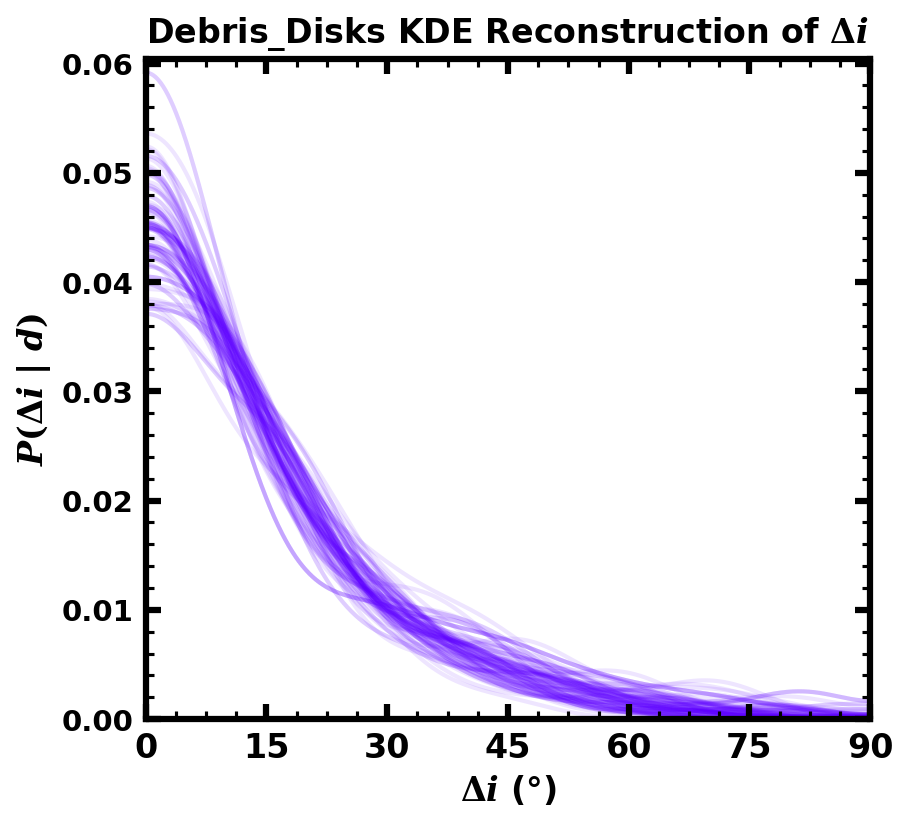

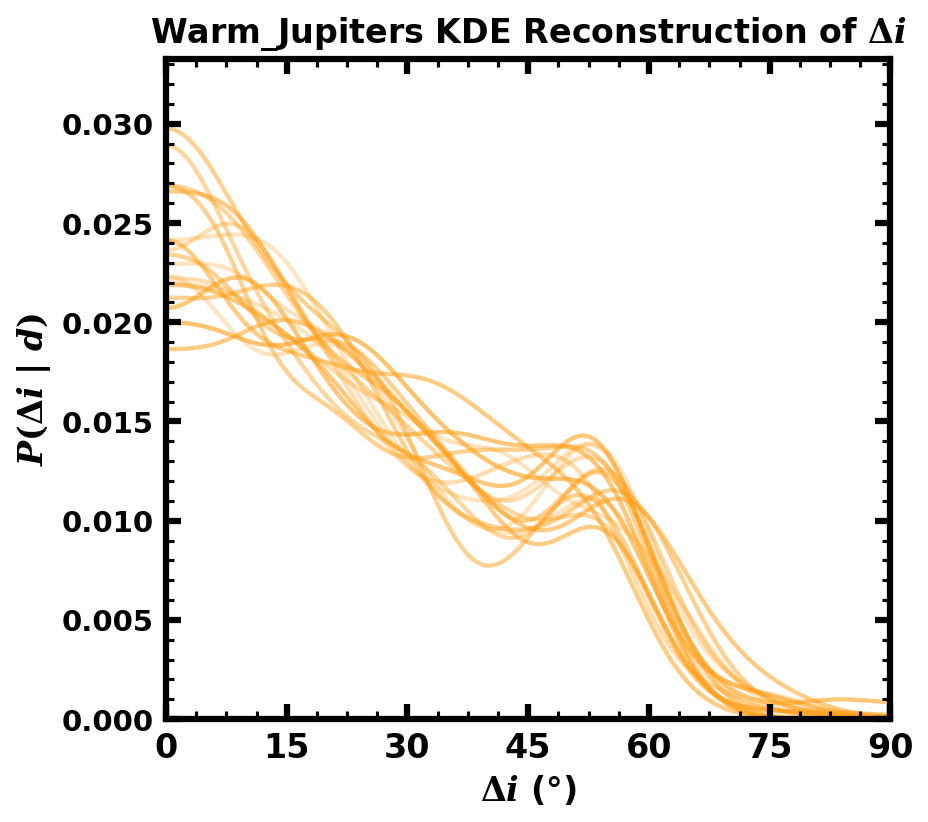

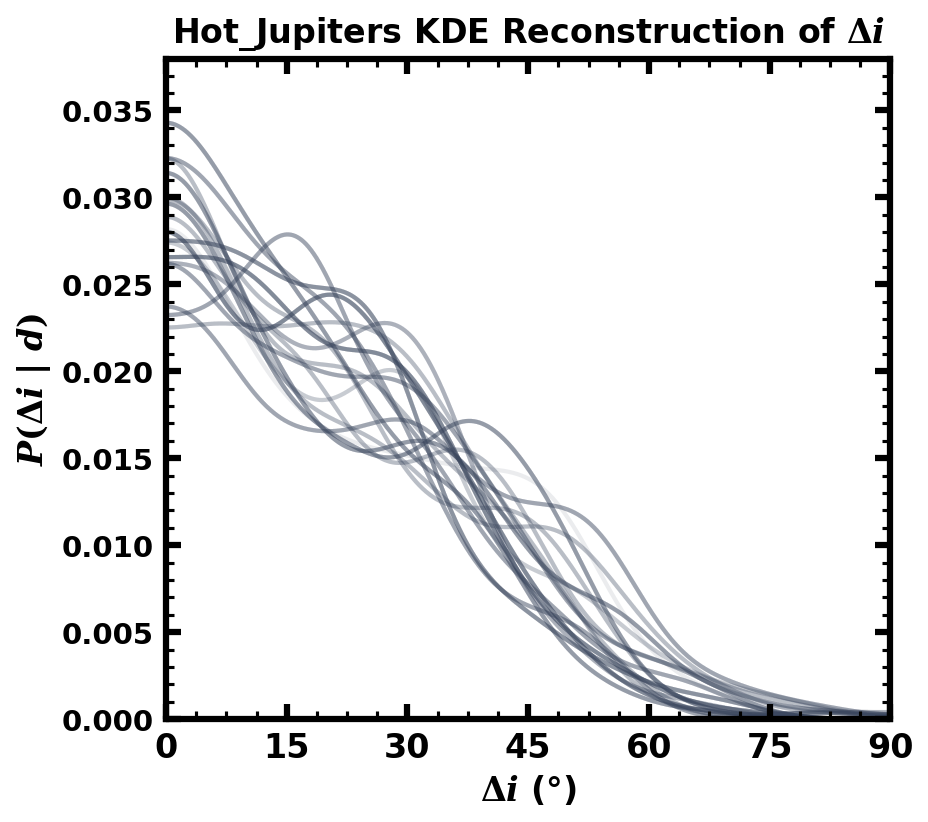

In [34]:
if do_kde_montecarlo_test == True:

    do_fill_between_KDE = False
    draw_alpha = 0.10
    draw_lw = 2

    for sample_type in sample_type_list:

        kde_025 = np.array(KDE_sample_type_dict[sample_type]['2.5'])
        kde_16 = np.array(KDE_sample_type_dict[sample_type]['16'])
        kde_50 = np.array(KDE_sample_type_dict[sample_type]['50'])
        kde_84 = np.array(KDE_sample_type_dict[sample_type]['84'])
        kde_975 = np.array(KDE_sample_type_dict[sample_type]['97.5'])

        xmin_test, xmax_test = 0, 90
        ymin_test, ymax_test = 0, 1.10 * max(kde_975)
        MC_kde_fontsize=16

        fig = plt.figure(figsize=(6, 5.5), dpi=150)
        ax = fig.add_subplot(111)
        ax.minorticks_on()
        # ax.plot(x_grid_plot, nominal_kde, ls=':', dashes=(1, 1), color='#000000', lw=4, alpha=0.5, label='Nominal KDE', zorder=-3)
        
        if sample_type == 'Protoplanetary_Disks':
            df_MC_goog = df_PD_goog
            which_dataset = 'PD'
            line_color = pd_color
        if sample_type == 'Debris_Disks':
            df_MC_goog = df_DD_goog
            which_dataset = 'DD'
            line_color = dd_color
        if sample_type == 'Warm_Jupiters':
            df_MC_goog = df_WJ_goog
            which_dataset = 'WJ'
            line_color = WJ_color
        if sample_type == 'Hot_Jupiters':
            df_MC_goog = df_HJ_goog
            which_dataset = 'HJ'
            line_color = HJ_color
        if do_fill_between_KDE == True:
            ax.fill_between(x_grid_plot, kde_975_plot[sample_type], kde_025_plot[sample_type], lw=0, color=line_color, alpha=0.3, zorder=-6)
            ax.fill_between(x_grid_plot, kde_84_plot[sample_type], kde_16_plot[sample_type], lw=0, color=line_color, alpha=1, zorder=-5)
        else:
            for kde_i, kde_i_plot in enumerate(kdes_plot[sample_type]):
                ax.plot(x_grid_plot, kde_i_plot, lw=draw_lw, linestyle='-', color=line_color, alpha=draw_alpha, zorder=-5)

        ax.set_xlim(xmin_test, xmax_test)
        ax.set_ylim(ymin_test, ymax_test)
        ax.set_title(sample_type + r' KDE Reconstruction of $\Delta i$', size=MC_kde_fontsize, pad=8)
        ax.set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=MC_kde_fontsize)
        ax.set_ylabel(r'$P(\Delta i$ | $d)$', fontsize=MC_kde_fontsize)
        ax.set_xlim(0, 90)
        xtickvals = [0, 15, 30, 45, 60, 75, 90]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=MC_kde_fontsize)

        fig.subplots_adjust(left=0.17, bottom=0.14, right=0.975, top=0.94, wspace=0.08, hspace=0.50)

        fig.savefig(test_figures_directory + 'MonteCarlo_Deltai_' + sample_type + '/MC_Deltai.pdf', dpi=300)
        plt.show() 

In [202]:
do_HBM_plot = False

if do_kde_montecarlo_test == True and do_HBM_plot == True:
    # HBM_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/HBM/Lauren_epop_analysis_2024-March-6/Final_HBM_Files/'
    # HBM_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/HBM/Lauren_epop_analysis_2024-June-10/Final_HBM_Files/'
    HBM_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/HBM/Lauren_epop_analysis_2024-Aug-20/Final_HBM_Files/'


    Delta_i_Rayleigh_logUniformPrior_file = HBM_directory + 'Delta_inclination_rayleigh_log-uniform.h5'
    Delta_i_Rayleigh_gaussianPrior_file = HBM_directory + 'Delta_inclination_rayleigh_gaussian.h5'
    Delta_i_Gaussian_logUniformPrior_file = HBM_directory + 'Delta_inclination_gaussian_log-uniform.h5'
    Delta_i_Gaussian_gaussianPrior_file = HBM_directory + 'Delta_inclination_gaussian_gaussian.h5'

    R_lU_label = r'Rayleigh (log-U Pr)'
    R_G_label = r'Rayleigh (G Pr)'
    G_lU_label = r'Gaussian (log-U Pr)'
    G_G_label = r'Gaussian (G Pr)'

    Delta_i_HBM_files = {R_lU_label: {'File Path': Delta_i_Rayleigh_logUniformPrior_file,
                                    },
                        R_G_label: {'File Path': Delta_i_Rayleigh_gaussianPrior_file,
                                    },
                        G_lU_label: {'File Path': Delta_i_Gaussian_logUniformPrior_file,
                                    },
                        G_G_label: {'File Path': Delta_i_Gaussian_gaussianPrior_file,
                                    },
                        }

In [203]:
def list_datasets(hdf5_file):
    def traverse_datasets(hdf_object):
        """Traverse HDF5 structure and print datasets."""
        if isinstance(hdf_object, h5py.Dataset):
            datasets.append(hdf_object.name)

        elif isinstance(hdf_object, h5py.Group):
            for key in hdf_object:
                traverse_datasets(hdf_object[key])

    datasets = []
    with h5py.File(hdf5_file, 'r') as file:
        traverse_datasets(file)
    return datasets

if do_kde_montecarlo_test == True and do_HBM_plot == True:
    all_datasets = list_datasets(Delta_i_Rayleigh_logUniformPrior_file)
    all_datasets

In [204]:
if do_kde_montecarlo_test == True and do_HBM_plot == True:
    with h5py.File(Delta_i_Rayleigh_logUniformPrior_file, 'r') as file:
        data_accepted = file['/mcmc/accepted'][()]
        data_chain = file['/mcmc/chain'][()]
        data_logprob = file['/mcmc/log_prob'][()]
        # data_mcmc = file['/mcmc']

    # import scipy
    # help(data_mcmc)
    # data_mcmc['accepted']
    print(data_accepted.shape)
    print(data_chain.shape)
    print(data_logprob.shape)

    data_accepted = [int(bep) for bep in data_accepted]
    print(sorted(data_accepted))
    print(' ')

In [205]:
if do_kde_montecarlo_test == True and do_HBM_plot == True:
    # np.random.seed(44)
    random_HBM_models = {}
    dival = 0.1
    ivals2 = np.arange(0, 90 + 2*dival, dival)

    # ivals = np.arange(0, 90 + 0.1, 0.1)
    x_model = x_grid_plot / 90.



    for HBM_key in list(Delta_i_HBM_files.keys()):
        print(HBM_key)

        with h5py.File(Delta_i_HBM_files[HBM_key]['File Path'], 'r') as file:
            data_accepted = file['/mcmc/accepted'][()]
            data_chain = file['/mcmc/chain'][()]
            data_logprob = file['/mcmc/log_prob'][()]

        random_choices = choices(np.arange(0, data_chain.shape[0], 1), k=100)

        chosen_chain = 'random'  # 'accepted'  # 'random'
        if chosen_chain == 'accepted':
            which_chains = np.copy(data_accepted)  # np.copy(random_choices)  # np.copy(data_accepted)
        if chosen_chain == 'random':
            which_chains = np.copy(random_choices)
        
        selected_chains = [int(bep) for bep in which_chains]

        random_models = []

        # if 'Rayleigh ' in HBM_key:
        #     print('Data Chain Shape: ', data_chain.shape)
        #     chosen_chains = data_chain[selected_chains, :, 0]
        #     for chain_i in range(len(chosen_chains)):
        #         draw = int(choices(np.arange(0, len(chosen_chains[chain_i]), 1), k=1)[0])
        #         random_draw = chosen_chains[chain_i][draw]
        #         model_profile = x_model/(random_draw**2) * np.exp((-x_model**2)/(2*random_draw**2))
        #         model_profile = model_profile/(sum(model_profile) * np.diff(x_grid_plot)[0])
        #         random_models.append(model_profile)

        # if 'Gaussian ' in HBM_key:
        #     print('Data Chain Shape: ', data_chain.shape)
        #     random_chains_mu = data_chain[selected_chains, :, 0]
        #     random_chains_sigma = data_chain[selected_chains, :, 1]
        #     for chain_j in range(len(random_chains_mu)):
        #         draw = int(choices(np.arange(0, len(chosen_chains[chain_j]), 1), k=1)[0])
        #         random_draw_mu = chosen_chains[chain_j][draw]
        #         random_draw_sigma = chosen_chains[chain_j][draw]
        #         model_profile = norm.pdf(x=x_model, loc=random_draw_mu, scale=random_draw_sigma)
        #         model_profile = model_profile/(sum(model_profile) * np.diff(x_grid_plot)[0])
        #         random_models.append(model_profile)

        if 'Rayleigh ' in HBM_key:
            print('Data Chain Shape: ', data_chain.shape)
            chosen_chains = data_chain[selected_chains, :, 0]
            for chain_i in range(len(chosen_chains)):
                random_draw = np.mean(chosen_chains[chain_i])
                model_profile = x_model/(random_draw**2) * np.exp((-x_model**2)/(2*random_draw**2))
                model_profile = model_profile/(sum(model_profile) * np.diff(x_grid_plot)[0])
                random_models.append(model_profile)

        if 'Gaussian ' in HBM_key:
            print('Data Chain Shape: ', data_chain.shape)
            random_chains_mu = data_chain[selected_chains, :, 0]
            random_chains_sigma = data_chain[selected_chains, :, 1]
            for chain_j in range(len(random_chains_mu)):
                random_draw_mu = np.mean(random_chains_mu[chain_j])
                random_draw_sigma = np.mean(random_chains_sigma[chain_j])
                model_profile = norm.pdf(x=x_model, loc=random_draw_mu, scale=random_draw_sigma)
                model_profile = model_profile/(sum(model_profile) * np.diff(x_grid_plot)[0])
                random_models.append(model_profile)

        
        random_HBM_models[HBM_key] = random_models


In [206]:
if do_kde_montecarlo_test == True and do_HBM_plot == True:
    print(random_HBM_models.keys())

    Rayleigh_lU_025 = np.percentile(random_HBM_models['Rayleigh (log-U Pr)'], 2.5, axis=0)
    Rayleigh_lU_16 = np.percentile(random_HBM_models['Rayleigh (log-U Pr)'], 16, axis=0)
    Rayleigh_lU_50 = np.percentile(random_HBM_models['Rayleigh (log-U Pr)'], 50, axis=0)
    Rayleigh_lU_84 = np.percentile(random_HBM_models['Rayleigh (log-U Pr)'], 84, axis=0)
    Rayleigh_lU_975 = np.percentile(random_HBM_models['Rayleigh (log-U Pr)'], 97.5, axis=0)

    Rayleigh_G_025 = np.percentile(random_HBM_models['Rayleigh (G Pr)'], 2.5, axis=0)
    Rayleigh_G_16 = np.percentile(random_HBM_models['Rayleigh (G Pr)'], 16, axis=0)
    Rayleigh_G_50 = np.percentile(random_HBM_models['Rayleigh (G Pr)'], 50, axis=0)
    Rayleigh_G_84 = np.percentile(random_HBM_models['Rayleigh (G Pr)'], 84, axis=0)
    Rayleigh_G_975 = np.percentile(random_HBM_models['Rayleigh (G Pr)'], 97.5, axis=0)

    Gaussian_lU_025 = np.percentile(random_HBM_models['Gaussian (log-U Pr)'], 2.5, axis=0)
    Gaussian_lU_16 = np.percentile(random_HBM_models['Gaussian (log-U Pr)'], 16, axis=0)
    Gaussian_lU_50 = np.percentile(random_HBM_models['Gaussian (log-U Pr)'], 50, axis=0)
    Gaussian_lU_84 = np.percentile(random_HBM_models['Gaussian (log-U Pr)'], 84, axis=0)
    Gaussian_lU_975 = np.percentile(random_HBM_models['Gaussian (log-U Pr)'], 97.5, axis=0)

    Gaussian_G_025 = np.percentile(random_HBM_models['Gaussian (G Pr)'], 2.5, axis=0)
    Gaussian_G_16 = np.percentile(random_HBM_models['Gaussian (G Pr)'], 16, axis=0)
    Gaussian_G_50 = np.percentile(random_HBM_models['Gaussian (G Pr)'], 50, axis=0)
    Gaussian_G_84 = np.percentile(random_HBM_models['Gaussian (G Pr)'], 84, axis=0)
    Gaussian_G_975 = np.percentile(random_HBM_models['Gaussian (G Pr)'], 97.5, axis=0)


    do_smooth = False
    if do_smooth == True:

        Rayleigh_lU_025 = gaussian_filter1d(Rayleigh_lU_025, sigma_smooth)
        Rayleigh_lU_16 = gaussian_filter1d(Rayleigh_lU_16, sigma_smooth)
        Rayleigh_lU_50 = gaussian_filter1d(Rayleigh_lU_50, sigma_smooth)
        Rayleigh_lU_84 = gaussian_filter1d(Rayleigh_lU_84, sigma_smooth)
        Rayleigh_lU_975 = gaussian_filter1d(Rayleigh_lU_975, sigma_smooth)

        Rayleigh_G_025 = gaussian_filter1d(Rayleigh_G_025, sigma_smooth)
        Rayleigh_G_16 = gaussian_filter1d(Rayleigh_G_16, sigma_smooth)
        Rayleigh_G_50 = gaussian_filter1d(Rayleigh_G_50, sigma_smooth)
        Rayleigh_G_84 = gaussian_filter1d(Rayleigh_G_84, sigma_smooth)
        Rayleigh_G_975 = gaussian_filter1d(Rayleigh_G_975, sigma_smooth)

        Gaussian_lU_025 = gaussian_filter1d(Gaussian_lU_025, sigma_smooth)
        Gaussian_lU_16 = gaussian_filter1d(Gaussian_lU_16, sigma_smooth)
        Gaussian_lU_50 = gaussian_filter1d(Gaussian_lU_50, sigma_smooth)
        Gaussian_lU_84 = gaussian_filter1d(Gaussian_lU_84, sigma_smooth)
        Gaussian_lU_975 = gaussian_filter1d(Gaussian_lU_975, sigma_smooth)

        Gaussian_G_025 = gaussian_filter1d(Gaussian_G_025, sigma_smooth)
        Gaussian_G_16 = gaussian_filter1d(Gaussian_G_16, sigma_smooth)
        Gaussian_G_50 = gaussian_filter1d(Gaussian_G_50, sigma_smooth)
        Gaussian_G_84 = gaussian_filter1d(Gaussian_G_84, sigma_smooth)
        Gaussian_G_975 = gaussian_filter1d(Gaussian_G_975, sigma_smooth)

In [207]:
if do_kde_montecarlo_test == True and do_HBM_plot == True:
    kde_HBM_plots_width = 5.5
    kde_HBM_plots_height = 14

    kde_HBM_plots_suptitlepad = 10
    kde_HBM_plots_suptitle_fontsize = 14

    kde_HBM_plots_labelpad = 6
    kde_HBM_plots_label_fontsize = 16

    kde_HBM_plots_text_fontsize = 15

    kde_HBM_plots_titlepad = 10

    HBM_key_b1 = 'log-U Pr'
    HBM_key_b2 = 'Tr G Pr'
    HBM_key_c1 = 'log-U Pr'
    HBM_key_c2 = 'Tr G Pr'
    model_linestyle_b1 = ':'
    model_color_b1 = '#004466'
    model_dashes_b1 = (2, 1, 1, 1)  # (0.05, 1.5)
    model_capstyle_b1 = 'butt'
    model_zorder_b1 = 6
    model_linestyle_b2 = '-'
    model_color_b2 = '#6699ff'
    model_dashes_b2 = (2, 0)  # (0.05, 1.5)
    model_capstyle_b2 = 'butt'
    model_zorder_b2 = 5
    model_linestyle_c1 = ':'
    model_color_c1 = '#990099'
    model_dashes_c1 = (2, 1, 1, 1)  # (0.05, 1.5)
    model_capstyle_c1 = 'butt'
    model_zorder_c1 = 4
    model_linestyle_c2 = '-'
    model_color_c2 = '#8c59e4'
    model_dashes_c2 = (2, 0)  # (0.05, 1.5)
    model_capstyle_c2 = 'butt'
    model_zorder_c2 = 3


    for sample_type in sample_type_list:

        kde_025 = np.array(KDE_sample_type_dict[sample_type]['2.5'])
        kde_16 = np.array(KDE_sample_type_dict[sample_type]['16'])
        kde_50 = np.array(KDE_sample_type_dict[sample_type]['50'])
        kde_84 = np.array(KDE_sample_type_dict[sample_type]['84'])
        kde_975 = np.array(KDE_sample_type_dict[sample_type]['97.5'])

        fig = plt.figure(figsize=(kde_HBM_plots_width, kde_HBM_plots_height), dpi=150)
        axes = fig.subplot_mosaic(
            """
            a
            b
            c
            """,
            gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [1], "bottom": 0.06, "top": 0.99, "left": 0.1775, "right": 0.972, "wspace": 0.44, "hspace": 0.25}
        )

        axes['a'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)
        axes['b'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)
        axes['c'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)

        axes['c'].set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)

        draw_alpha = 0.10
        draw_lw = 2

        axes['a'].plot(x_grid_plot, nominal_kde, ls=':', dashes=(1, 1), color='#000000', lw=3, alpha=0.5, label='Nominal KDE', zorder=-3)

        do_fill_between_KDE = False
        if do_fill_between_KDE == True:
            axes['a'].fill_between(x_grid_plot, kde_975_plot[sample_type], kde_025_plot[sample_type], lw=0, color='#2eb8b8', alpha=0.3, zorder=-6)
            axes['a'].fill_between(x_grid_plot, kde_84_plot[sample_type], kde_16_plot[sample_type], lw=0, color='#2eb8b8', alpha=1, zorder=-5)
        else:
            for kde_i, kde_i_plot in enumerate(kdes_plot[sample_type]):
                axes['a'].plot(x_grid_plot, kde_i_plot, lw=draw_lw, linestyle='-', color='#2eb8b8', alpha=draw_alpha, zorder=-5)
                

        do_fill_between = False
        if do_fill_between == True:

            axes['b'].fill_between(x_grid_plot, Rayleigh_lU_975, Rayleigh_lU_025, lw=0, color=model_color_b1, alpha=0.3, zorder=-6)
            axes['b'].fill_between(x_grid_plot, Rayleigh_lU_84, Rayleigh_lU_16, lw=0, color=model_color_b1, alpha=1, zorder=-5)

            axes['c'].fill_between(x_grid_plot, Gaussian_lU_975, Gaussian_lU_025, lw=0, color=model_color_c1, alpha=0.3, zorder=-6)
            axes['c'].fill_between(x_grid_plot, Gaussian_lU_84, Gaussian_lU_16, lw=0, color=model_color_c1, alpha=1, zorder=-5)

            axes['b'].text(0.50, 0.92, r'Rayleigh (log-U Pr)', horizontalalignment='center', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['b'].transAxes)
            axes['c'].text(0.50, 0.92, r'Gaussian (log-U Pr)', horizontalalignment='center', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['c'].transAxes)    
        else:
            for draw_i in range(len(random_HBM_models['Rayleigh (log-U Pr)'])):
                axes['b'].plot(x_grid_plot, random_HBM_models['Rayleigh (log-U Pr)'][draw_i], lw=draw_lw, linestyle=model_linestyle_b1, dashes=model_dashes_b1, color=model_color_b1, alpha=draw_alpha, zorder=-5)
                axes['b'].plot(x_grid_plot, random_HBM_models['Rayleigh (G Pr)'][draw_i], lw=draw_lw, linestyle=model_linestyle_b2, dashes=model_dashes_b2, color=model_color_b2, alpha=draw_alpha, zorder=-6)
                axes['c'].plot(x_grid_plot, random_HBM_models['Gaussian (log-U Pr)'][draw_i], lw=draw_lw, linestyle=model_linestyle_c1, dashes=model_dashes_c1, color=model_color_c1, alpha=draw_alpha, zorder=-5)
                axes['c'].plot(x_grid_plot, random_HBM_models['Gaussian (G Pr)'][draw_i], lw=draw_lw, linestyle=model_linestyle_c2, dashes=model_dashes_c2, color=model_color_c2, alpha=draw_alpha, zorder=-6)
            axes['b'].plot([], [], lw=draw_lw, linestyle=model_linestyle_b1, dashes=model_dashes_b1, color=model_color_b1, alpha=0.5, label=HBM_key_b1, zorder=-5)
            axes['b'].plot([], [], lw=draw_lw, linestyle=model_linestyle_b2, dashes=model_dashes_b2, color=model_color_b2, alpha=0.5, label=HBM_key_b2, zorder=-6)
            axes['c'].plot([], [], lw=draw_lw, linestyle=model_linestyle_c1, dashes=model_dashes_c1, color=model_color_c1, alpha=0.5, label=HBM_key_c1, zorder=-5)
            axes['c'].plot([], [], lw=draw_lw, linestyle=model_linestyle_c2, dashes=model_dashes_c2, color=model_color_c2, alpha=0.5, label=HBM_key_c2, zorder=-6)
            leg_b = axes['b'].legend(loc='upper right', fontsize=kde_HBM_plots_text_fontsize)
            leg_c = axes['c'].legend(loc='upper right', fontsize=kde_HBM_plots_text_fontsize)
            leg_b._legend_box.align = "right"
            leg_c._legend_box.align = "right"

            axes['b'].set_title('Rayleigh Distribution', fontsize=kde_HBM_plots_label_fontsize, pad=kde_HBM_plots_titlepad)
            axes['c'].set_title('Gaussian Distribution', fontsize=kde_HBM_plots_label_fontsize, pad=kde_HBM_plots_titlepad)

        axes['a'].text(0.50, 0.92, r'KDE Reconstruction of $\Delta i$', horizontalalignment='center', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['a'].transAxes)


        for ax in axes.keys():
            axes[ax].minorticks_on()
            axes[ax].set_rasterized(True)

            for spine in axes[ax].spines.values():
                spine.set_linewidth(2.5)

            # SPECIFY THE X TICKS
            xticks = [0, 15, 30, 45, 60, 75, 90]
            xticklabels = [str(int(xtick)) for xtick in xticks]
            axes[ax].set_xticks(xticks)
            axes[ax].set_xticklabels(xticklabels)

            axes[ax].set_xlim(0, 90)
            axes[ax].set_ylim(0, 0.065)
            # axes[ax].set_xlim(15, 25)
            # axes[ax].set_ylim(0.025, 0.042)

            yticks = [0.0, 0.02, 0.04, 0.06]
            axes[ax].set_yticks(yticks)
            yticklabels = ['{:.2f}'.format(ytick) for ytick in yticks]
            axes[ax].set_yticklabels(yticklabels)

            

        axes['a'].set_ylim(0, 1.15*max(kde_975[sample_type]))
        axes['b'].set_ylim(0, 1.15*max(Rayleigh_lU_975))
        axes['c'].set_ylim(0, 1.15*max(Gaussian_lU_975))

        axes['a'].tick_params(which='minor', length=4.5, width=2, labelsize=kde_HBM_plots_label_fontsize)
        axes['a'].tick_params(which='major', length=7.5, width=3, labelsize=kde_HBM_plots_label_fontsize)
        axes['b'].tick_params(which='minor', length=4.5, width=2, labelsize=kde_HBM_plots_label_fontsize)
        axes['b'].tick_params(which='major', length=7.5, width=3, labelsize=kde_HBM_plots_label_fontsize)
        axes['c'].tick_params(which='minor', length=4.5, width=2, labelsize=kde_HBM_plots_label_fontsize)
        axes['c'].tick_params(which='major', length=7.5, width=3, labelsize=kde_HBM_plots_label_fontsize)


        # SAVE THE FIGURE
        save_par_vs_stacked_kde = 'Stacked_KDE_HBM_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

        if plot_transparent == True:
            fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=True)
        else:
            fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=False)



In [208]:
if do_kde_montecarlo_test == True and do_HBM_plot == True:
    kde_HBM_plots_width = 5.5
    kde_HBM_plots_height = 10.5  # 14.0

    kde_HBM_plots_suptitlepad = 10
    kde_HBM_plots_suptitle_fontsize = 14

    kde_HBM_plots_labelpad = 6
    kde_HBM_plots_label_fontsize = 16

    kde_HBM_plots_text_fontsize = 15

    kde_HBM_plots_titlepad = 10


    do_science_version = False


    HBM_key_b1 = 'log-U Pr'
    HBM_key_b2 = 'G Pr'
    HBM_key_c1 = 'log-U Pr'
    HBM_key_c2 = 'G Pr'
    model_linestyle_b1 = ':'
    model_color_b1 = '#004466'
    model_dashes_b1 = (2, 1)  # (0.05, 1.5)
    model_capstyle_b1 = 'butt'
    model_zorder_b1 = 6
    model_linestyle_b2 = '-'
    model_color_b2 = '#6699ff'
    model_dashes_b2 = (2, 0)  # (0.05, 1.5)
    model_capstyle_b2 = 'butt'
    model_zorder_b2 = 5
    model_linestyle_c1 = ':'
    model_color_c1 = '#990099'
    model_dashes_c1 = (2, 1)  # (0.05, 1.5)
    model_capstyle_c1 = 'butt'
    model_zorder_c1 = 4
    model_linestyle_c2 = '-'
    model_color_c2 = '#8c59e4'
    model_dashes_c2 = (2, 0)  # (0.05, 1.5)
    model_capstyle_c2 = 'butt'
    model_zorder_c2 = 3


    for sample_type in sample_type_list:

        kde_025 = np.array(KDE_sample_type_dict[sample_type]['2.5'])
        kde_16 = np.array(KDE_sample_type_dict[sample_type]['16'])
        kde_50 = np.array(KDE_sample_type_dict[sample_type]['50'])
        kde_84 = np.array(KDE_sample_type_dict[sample_type]['84'])
        kde_975 = np.array(KDE_sample_type_dict[sample_type]['97.5'])

        fig = plt.figure(figsize=(kde_HBM_plots_width, kde_HBM_plots_height), dpi=150)
        axes = fig.subplot_mosaic(
            """
            aa
            bd
            ce
            """,
            gridspec_kw={'height_ratios': [0.6, 0.4, 0.4], 'width_ratios': [0.5, 0.5], "bottom": 0.06, "top": 0.95, "left": 0.1775, "right": 0.972, "wspace": 0.025, "hspace": 0.35}
        )

        axes['a'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)
        axes['b'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)
        axes['c'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)

        if do_science_version == True:
            axes['a'].set_title(r'KDE Reconstruction of $\Delta i$', fontsize=kde_HBM_plots_label_fontsize, pad=kde_HBM_plots_titlepad*0.75)
        axes['b'].set_title('Rayleigh Distribution', fontsize=kde_HBM_plots_label_fontsize, pad=kde_HBM_plots_titlepad, x=1.0)
        axes['c'].set_title('Gaussian Distribution', fontsize=kde_HBM_plots_label_fontsize, pad=kde_HBM_plots_titlepad, x=1.0)

        axes['c'].set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)
        axes['e'].set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=kde_HBM_plots_label_fontsize, labelpad=kde_HBM_plots_labelpad)

        draw_alpha = 0.10
        draw_lw = 2

        axes['a'].plot(x_grid_plot, nominal_kde, ls=':', dashes=(1, 1), color='#000000', lw=3, alpha=0.5, label='Nominal KDE', zorder=-3)

        do_fill_between_KDE = False
        if do_fill_between_KDE == True:
            axes['a'].fill_between(x_grid_plot, kde_975_plot[sample_type], kde_025_plot[sample_type], lw=0, color='#2eb8b8', alpha=0.3, zorder=-6)
            axes['a'].fill_between(x_grid_plot, kde_84_plot[sample_type], kde_16_plot[sample_type], lw=0, color='#2eb8b8', alpha=1, zorder=-5)
        else:
            for kde_i, kde_i_plot in enumerate(kdes_plot[sample_type]):
                axes['a'].plot(x_grid_plot, kde_i_plot, lw=draw_lw, linestyle='-', color='#2eb8b8', alpha=draw_alpha, zorder=-5)

        do_fill_between_HBM = False
        if do_fill_between_HBM == True:
            axes['b'].fill_between(x_grid_plot, Rayleigh_lU_975, Rayleigh_lU_025, lw=0, color=model_color_b1, alpha=0.3, zorder=-6)
            axes['b'].fill_between(x_grid_plot, Rayleigh_lU_84, Rayleigh_lU_16, lw=0, color=model_color_b1, alpha=1, zorder=-5)

            axes['d'].fill_between(x_grid_plot, Rayleigh_G_975, Rayleigh_G_025, lw=0, color=model_color_b2, alpha=0.3, zorder=-6)
            axes['d'].fill_between(x_grid_plot, Rayleigh_G_84, Rayleigh_G_16, lw=0, color=model_color_b2, alpha=1, zorder=-5)

            axes['c'].fill_between(x_grid_plot, Gaussian_lU_975, Gaussian_lU_025, lw=0, color=model_color_c1, alpha=0.3, zorder=-6)
            axes['c'].fill_between(x_grid_plot, Gaussian_lU_84, Gaussian_lU_16, lw=0, color=model_color_c1, alpha=1, zorder=-5)

            axes['e'].fill_between(x_grid_plot, Gaussian_G_975, Gaussian_G_025, lw=0, color=model_color_c2, alpha=0.3, zorder=-6)
            axes['e'].fill_between(x_grid_plot, Gaussian_G_84, Gaussian_G_16, lw=0, color=model_color_c2, alpha=1, zorder=-5)

            axes['b'].text(0.89, 0.85, 'log-U Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['b'].transAxes)
            axes['d'].text(0.89, 0.85, 'G Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['d'].transAxes)
            axes['c'].text(0.89, 0.85, 'log-U Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['c'].transAxes)  
            axes['e'].text(0.89, 0.85, 'G Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['e'].transAxes)   
        else:
            for draw_i in range(len(random_HBM_models['Rayleigh (log-U Pr)'])):
                axes['b'].plot(x_grid_plot, random_HBM_models['Rayleigh (log-U Pr)'][draw_i], lw=draw_lw*0.75, linestyle='-', color=model_color_b1, alpha=draw_alpha, zorder=-5)
                axes['d'].plot(x_grid_plot, random_HBM_models['Rayleigh (G Pr)'][draw_i], lw=draw_lw*0.75, linestyle='-', color=model_color_b2, alpha=draw_alpha, zorder=-6)
                axes['c'].plot(x_grid_plot, random_HBM_models['Gaussian (log-U Pr)'][draw_i], lw=draw_lw*0.75, linestyle='-', color=model_color_c1, alpha=draw_alpha, zorder=-5)
                axes['e'].plot(x_grid_plot, random_HBM_models['Gaussian (G Pr)'][draw_i], lw=draw_lw*0.75, linestyle='-', color=model_color_c2, alpha=draw_alpha, zorder=-6)

        if do_science_version == False:
            axes['a'].text(0.50, 0.90, r'KDE Reconstruction of $\Delta i$', horizontalalignment='center', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['a'].transAxes)
            axes['b'].text(0.89, 0.85, 'log-U Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['b'].transAxes)
            axes['d'].text(0.89, 0.85, 'G Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['d'].transAxes)
            axes['c'].text(0.89, 0.85, 'log-U Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['c'].transAxes)  
            axes['e'].text(0.89, 0.85, 'G Pr', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize, transform=axes['e'].transAxes) 
        if do_science_version == True:
            axes['a'].text(0.89, 0.85, 'A', horizontalalignment='center', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize*1.25, transform=axes['a'].transAxes)
            axes['b'].text(0.89, 0.85, 'B', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize*1.25, transform=axes['b'].transAxes)
            axes['d'].text(0.89, 0.85, 'C', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize*1.25, transform=axes['d'].transAxes)
            axes['c'].text(0.89, 0.85, 'D', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize*1.25, transform=axes['c'].transAxes)  
            axes['e'].text(0.89, 0.85, 'E', horizontalalignment='right', verticalalignment='center', fontsize=kde_HBM_plots_text_fontsize*1.25, transform=axes['e'].transAxes) 

        xmin, xmax = 0, 90

        for ax in axes.keys():
            axes[ax].minorticks_on()
            # axes[ax].set_rasterized(True)

            for spine in axes[ax].spines.values():
                spine.set_linewidth(2.5)

            # SPECIFY THE X TICKS
            if ax == 'a':
                xticks = [0, 15, 30, 45, 60, 75, 90]
            elif ax in ['b', 'c']:
                xticks = [0, 20, 40, 60, 80]
            else:
                xticks = [20, 40, 60, 80]
            xticklabels = [str(int(xtick)) for xtick in xticks]
            axes[ax].set_xticks(xticks)
            axes[ax].set_xticklabels(xticklabels)

            if ax in ['a']:
                yticks = [0.0, 0.01, 0.02, 0.03, 0.04]
            elif ax in ['b', 'd']:
                yticks = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
            else:
                yticks = [0.0, 0.03, 0.06, 0.09]
            axes[ax].set_yticks(yticks)
            yticklabels = ['{:.2f}'.format(ytick) for ytick in yticks]

            if ax in ['a', 'b', 'c']:
                axes[ax].set_yticklabels(yticklabels)
            else:
                axes[ax].set_yticklabels([])

            axes[ax].set_xlim(xmin, xmax)
            if ax == 'a':
                axes[ax].set_ylim(0, 0.04)
            elif ax in ['b', 'd']:
                axes[ax].set_ylim(0, 0.055)
            else:
                axes[ax].set_ylim(0, 0.10)

            axes[ax].tick_params(which='minor', length=4, width=1.5, labelsize=kde_HBM_plots_label_fontsize)
            axes[ax].tick_params(which='major', length=7, width=2.5, labelsize=kde_HBM_plots_label_fontsize)

        minor_locator_a = AutoMinorLocator(3)
        axes['a'].xaxis.set_minor_locator(minor_locator_a)

        minor_locator_b = AutoMinorLocator(4)
        axes['b'].xaxis.set_minor_locator(minor_locator_b)
        axes['d'].xaxis.set_minor_locator(minor_locator_b)
        axes['c'].xaxis.set_minor_locator(minor_locator_b)
        axes['e'].xaxis.set_minor_locator(minor_locator_b)


        # SAVE THE FIGURE
        save_par_vs_stacked_kde = 'Stacked_KDE_HBM_grid_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

        if plot_transparent == True:
            fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=True)
        else:
            fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=False)



# Next

In [210]:
# ------------------ DETERMINE X_GRID ------------------ #
Posteriors = pd.read_csv(probability_distributions_dir+ 'Posteriors_tauCeti_DD.csv')
posterior_i_values = Posteriors['i (deg)'].values
x_grid = np.array(posterior_i_values).reshape(-1, 1)

reverse_posterior_i_values = -posterior_i_values[::-1][:-1]
all_posterior_i_values = np.concatenate((np.array(reverse_posterior_i_values), np.array(posterior_i_values)))
x_grid_all = np.array(all_posterior_i_values).reshape(-1, 1)

x_grid_plot = np.copy(posterior_i_values)



KDE_filepath = save_csv_filepath_PD  + 'KDE_' + resolution_text + '_'+ date_str + '.csv'


do_mirror = True

track_posteriors = []

kde_n_draws = int(5e2)
# kde_n_draws = int(1e5)

data_for_kde_PD = []
data_for_kde_DD = []
data_for_kde_WJ = []
data_for_kde_HJ = []

# ------------------ COMPUTE KDE FROM DRAWS ------------------ #

# --------------------------- PD -------------------------- #
band_width_PD = 5.18
print('KDE Bandwidth PD = ', band_width_PD)
for targetnum in range(len(df_PD['Target'].values)):

    target_str = df_PD['Target'].values[targetnum].replace(' ', '')
    if '/' in df_PD['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_PD.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_PD.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

# --------------------------- DD --------------------------- #
band_width_DD = 5.18
print('KDE Bandwidth DD = ', band_width_DD)
for targetnum in range(len(df_DD['Target'].values)):

    target_str = df_DD['Target'].values[targetnum].replace(' ', '')
    if '/' in df_DD['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_DD.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_DD.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))


# ------------------------- WJ ------------------------ #
band_width_WJ = 5.18
print('KDE Bandwidth WJ = ', band_width_WJ)
for targetnum in range(len(df_WJ['Target'].values)):

    target_str = df_WJ['Target'].values[targetnum].replace(' ', '')
    if '/' in df_WJ['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_WJ.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_WJ.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))


# ------------------------- HJ ------------------------ #
band_width_HJ = 5.18
print('KDE Bandwidth HJ = ', band_width_HJ)
for targetnum in range(len(df_HJ['Target'].values)):

    target_str = df_HJ['Target'].values[targetnum].replace(' ', '')
    if '/' in df_HJ['Target'].values[targetnum]:
        target_str = target_str.replace('/', '-')

    Posteriors = pd.read_csv(probability_distributions_dir + 'Posteriors_' + target_str + '_HJ.csv')
    P_Delta_i_target = np.array(Posteriors['P(Delta i | d)'].values)

    track_posteriors.append(P_Delta_i_target)

    data_for_kde_HJ.extend(choices(posterior_i_values, P_Delta_i_target, k=kde_n_draws))

    



data_for_kde_PD = np.array(data_for_kde_PD).reshape(-1, 1)
data_for_kde_DD = np.array(data_for_kde_DD).reshape(-1, 1)
data_for_kde_HJ = np.array(data_for_kde_HJ).reshape(-1, 1)
data_for_kde_WJ = np.array(data_for_kde_WJ).reshape(-1, 1)

kde_PD = KernelDensity(kernel='gaussian', bandwidth=band_width_PD).fit(data_for_kde_PD)
kde_DD = KernelDensity(kernel='gaussian', bandwidth=band_width_DD).fit(data_for_kde_DD)
kde_WJ = KernelDensity(kernel='gaussian', bandwidth=band_width_WJ).fit(data_for_kde_WJ)
kde_HJ = KernelDensity(kernel='gaussian', bandwidth=band_width_HJ).fit(data_for_kde_HJ)

log_density_PD = kde_PD.score_samples(x_grid_all)
log_density_DD = kde_DD.score_samples(x_grid_all)
log_density_WJ = kde_WJ.score_samples(x_grid_all)
log_density_HJ = kde_HJ.score_samples(x_grid_all)

density_estimation_PD = np.array(np.exp(log_density_PD))
density_estimation_DD = np.array(np.exp(log_density_DD))
density_estimation_WJ = np.array(np.exp(log_density_WJ))
density_estimation_HJ = np.array(np.exp(log_density_HJ))

density_estimation_mirrored_PD = density_estimation_PD[::-1]
density_estimation_mirrored_DD = density_estimation_DD[::-1]
density_estimation_mirrored_WJ = density_estimation_WJ[::-1]
density_estimation_mirrored_HJ = density_estimation_HJ[::-1]

density_estimation_total_PD = density_estimation_PD + density_estimation_mirrored_PD
density_estimation_total_DD = density_estimation_DD + density_estimation_mirrored_DD
density_estimation_total_WJ = density_estimation_WJ + density_estimation_mirrored_WJ
density_estimation_total_HJ = density_estimation_HJ + density_estimation_mirrored_HJ

KDE_dict = {'all_posterior_i_values': all_posterior_i_values,
            'density_estimation_PD': density_estimation_PD,
            'density_estimation_DD': density_estimation_DD,
            'density_estimation_WJ': density_estimation_WJ,
            'density_estimation_HJ': density_estimation_HJ,
            'density_estimation_mirrored_PD': density_estimation_mirrored_PD,
            'density_estimation_mirrored_DD': density_estimation_mirrored_DD,
            'density_estimation_mirrored_WJ': density_estimation_mirrored_WJ,
            'density_estimation_mirrored_HJ': density_estimation_mirrored_HJ,
            'density_estimation_total_PD': density_estimation_total_PD,
            'density_estimation_total_DD': density_estimation_total_DD,
            'density_estimation_total_WJ': density_estimation_total_WJ,
            'density_estimation_total_HJ': density_estimation_total_HJ,
            'kde_n_draws': [kde_n_draws]*len(density_estimation_PD),
            'band_width': [band_width_PD]*len(density_estimation_PD),
            }
KDE_df = pd.DataFrame(KDE_dict)
KDE_df.to_csv(KDE_filepath, index=False)


density_estimation_total_positive_x_PD = density_estimation_total_PD[all_posterior_i_values >= 0]
density_estimation_total_positive_x_DD = density_estimation_total_DD[all_posterior_i_values >= 0]
density_estimation_total_positive_x_WJ = density_estimation_total_WJ[all_posterior_i_values >= 0]
density_estimation_total_positive_x_HJ = density_estimation_total_HJ[all_posterior_i_values >= 0]

dx = np.diff(x_grid_plot)[0]
print('dx: ', dx)

smooth_on = False
if smooth_on == True:
    smooth_over_deg = 1
    print('smooth over: ', smooth_over_deg, 'deg')
    smooth_over_points = int(smooth_over_deg/dx)
    if np.mod(smooth_over_points, 2) != 0:
        smooth_over_points += 1

    smooth_vals_i_diff_PD = gaussian_filter1d(density_estimation_total_positive_x_PD, smooth_over_points) 
    smooth_vals_i_diff_DD = gaussian_filter1d(density_estimation_total_positive_x_DD, smooth_over_points)  # , mode='nearest')
    smooth_vals_i_diff_WJ = gaussian_filter1d(density_estimation_total_positive_x_WJ, smooth_over_points)
    smooth_vals_i_diff_HJ = gaussian_filter1d(density_estimation_total_positive_x_HJ, smooth_over_points)

    density_estimation_total_positive_x_PD = smooth_vals_i_diff_PD / (sum(smooth_vals_i_diff_PD) * dx)
    density_estimation_total_positive_x_DD = smooth_vals_i_diff_DD / (sum(smooth_vals_i_diff_DD) * dx)
    density_estimation_total_positive_x_WJ = smooth_vals_i_diff_WJ / (sum(smooth_vals_i_diff_WJ) * dx)
    density_estimation_total_positive_x_HJ = smooth_vals_i_diff_HJ / (sum(smooth_vals_i_diff_HJ) * dx)
else:
    density_estimation_total_positive_x_PD = density_estimation_total_positive_x_PD / (sum(density_estimation_total_positive_x_PD) * dx)
    density_estimation_total_positive_x_DD = density_estimation_total_positive_x_DD / (sum(density_estimation_total_positive_x_DD) * dx)
    density_estimation_total_positive_x_WJ = density_estimation_total_positive_x_WJ / (sum(density_estimation_total_positive_x_WJ) * dx)
    density_estimation_total_positive_x_HJ = density_estimation_total_positive_x_HJ / (sum(density_estimation_total_positive_x_HJ) * dx)


KDE Bandwidth biddle =  5.18
KDE Bandwidth hurt =  5.18
KDE Bandwidth morgan WJ =  5.18
KDE Bandwidth morgan HJ =  5.18
dx:  0.01


In [211]:
density_estimation_uncorrected_PD = density_estimation_PD[all_posterior_i_values >= 0]
density_estimation_uncorrected_DD = density_estimation_DD[all_posterior_i_values >= 0]
density_estimation_uncorrected_WJ = density_estimation_WJ[all_posterior_i_values >= 0]
density_estimation_uncorrected_HJ = density_estimation_HJ[all_posterior_i_values >= 0]

density_estimation_uncorrected_PD = density_estimation_uncorrected_PD / (sum(density_estimation_uncorrected_PD) * dx)
density_estimation_uncorrected_DD = density_estimation_uncorrected_DD / (sum(density_estimation_uncorrected_DD) * dx)
density_estimation_uncorrected_WJ = density_estimation_uncorrected_WJ / (sum(density_estimation_uncorrected_WJ) * dx)
density_estimation_uncorrected_HJ = density_estimation_uncorrected_HJ / (sum(density_estimation_uncorrected_HJ) * dx)


In [212]:
kde_MAP_PD, sig1_kde_m_PD, sig1_kde_p_PD, fraction_values_PD, posterior_kde_fractions_PD = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_PD, sigma=0.6826, return_pdf=True)
kde_MAP_DD, sig1_kde_m_DD, sig1_kde_p_DD, fraction_values_DD, posterior_kde_fractions_DD = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_DD, sigma=0.6826, return_pdf=True)
kde_MAP_WJ, sig1_kde_m_WJ, sig1_kde_p_WJ, fraction_values_WJ, posterior_kde_fractions_WJ = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_WJ, sigma=0.6826, return_pdf=True)
kde_MAP_HJ, sig1_kde_m_HJ, sig1_kde_p_HJ, fraction_values_HJ, posterior_kde_fractions_HJ = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=density_estimation_total_positive_x_HJ, sigma=0.6826, return_pdf=True)

print('PD KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_PD, sig1_kde_p_PD, sig1_kde_m_PD))
print('DD KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_DD, sig1_kde_p_DD, sig1_kde_m_DD))
print('WJ KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_WJ, sig1_kde_p_WJ, sig1_kde_m_WJ))
print('HJ KDE MAP AND 1sigma Confidence: {:.2f} +{:.2f} -{:.2f}'.format(kde_MAP_HJ, sig1_kde_p_HJ, sig1_kde_m_HJ))

BIDDLE KDE MAP AND 1sigma Confidence: 4.52 +20.82 -4.52
HURT KDE MAP AND 1sigma Confidence: 0.00 +19.49 -0.00
MORGAN WJ KDE MAP AND 1sigma Confidence: 0.00 +33.83 -0.00
MORGAN HJ KDE MAP AND 1sigma Confidence: 0.00 +30.11 -0.00


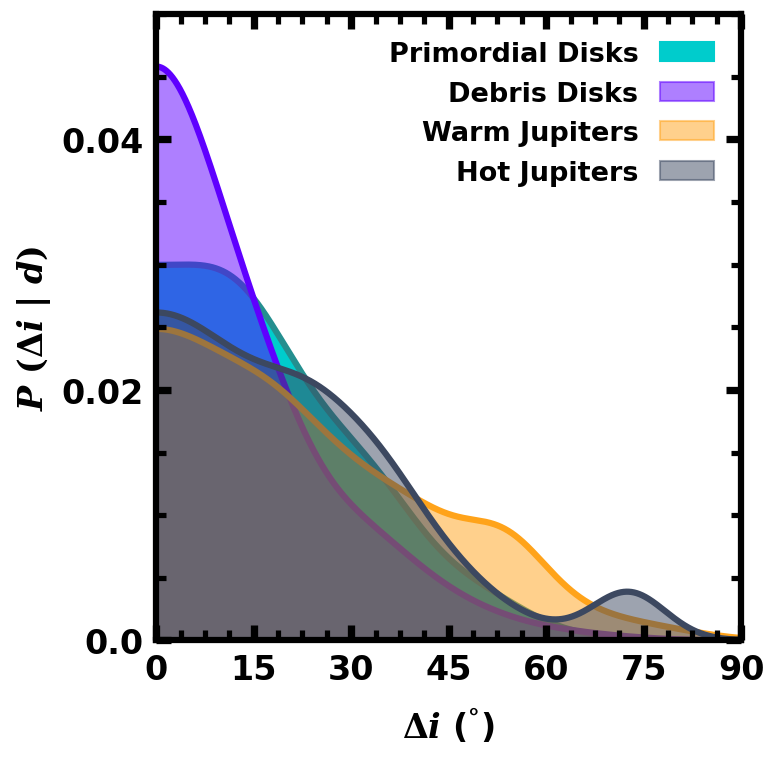

In [220]:

mpl.rcParams['hatch.linewidth'] = 2


fig = plt.figure(figsize=(5, 5), dpi=150)
ax = fig.add_subplot(111)

ax.minorticks_on()

Delta_i_hist_fontsize = 16

ax.set_xlabel(r'$\Delta i$ ($^\degree$)', fontsize=Delta_i_hist_fontsize, labelpad=10)
ax.set_ylabel(r'$P$ $(\Delta i$ | $d)$', fontsize=Delta_i_hist_fontsize)

zorder_shift = 10

# ax.fill_between(x_grid_plot_PD, density_estimation_total_positive_x_PD, color=pd_color, alpha=1, label='Primordial Disks', zorder=-11)
ax.plot(x_grid_plot, density_estimation_total_positive_x_PD, color='#248f8f', alpha=1, lw=3, zorder=-11)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_PD, color=pd_color, alpha=1, label='Primordial Disks', zorder=-12)
ax.plot(x_grid_plot, density_estimation_total_positive_x_DD, color=dd_color, alpha=1, lw=3, zorder=-10)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_DD, color=dd_color, alpha=0.5, label='Debris Disks', zorder=-10)
ax.plot(x_grid_plot, density_estimation_total_positive_x_WJ, color=WJ_color, lw=3, alpha=1, zorder=-9)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_WJ, color=WJ_color, alpha=0.5, label='Warm Jupiters', zorder=-9)
ax.plot(x_grid_plot, density_estimation_total_positive_x_HJ, color=HJ_color, lw=3, alpha=1, zorder=-8)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_HJ, color=HJ_color, alpha=0.5, label='Hot Jupiters', zorder=-8)
# ax.fill_between(x_grid_plot, density_estimation_total_positive_x_HJ, edgecolor=HJ_color, facecolor='None', hatch='xx', alpha=1, lw=3, label='Hot Jupiters', zorder=-8)


# ax.plot(x_grid_plot, density_estimation_total_positive_x_HJ, color=HJ_color, lw=3, alpha=1, zorder=-4)


xticks_major = [0, 15, 30, 45, 60, 75, 90]
ax.set_xticks(xticks_major, which='major')
ax.set_xticklabels(xticks_major, fontsize=Delta_i_hist_fontsize)
# ax.set_xticklabels(xticks_hist_minor, fontsize=Delta_i_hist_fontsize)
# minor_locator = AutoMinorLocator(3)
# ax.xaxis.set_minor_locator(minor_locator)
ax.set_xlim(0, 90)

yticks_hist = np.arange(0, 0.07 + 0.02, 0.02)
ax.set_yticks(yticks_hist)
ax.set_yticklabels(yticks_hist)
ax.set_ylim(0, 0.05)

ax.legend(loc='upper right', prop={'size': 13}, ncol=1, markerfirst=False)  # , bbox_to_anchor=(0.24, 0.90, 0.5, 0.10))

for spine in ax.spines.values():
    spine.set_zorder(100)

ax.tick_params(which='minor', length=5, width=2.5, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=3.5, labelsize=Delta_i_hist_fontsize)

fig.subplots_adjust(left=0.19, bottom=0.145, right=0.97, top=0.98, wspace=0.12, hspace=0.35)


save_kde_string = 'KDEs_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_kde_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_kde_string, dpi=300, transparent=False)

plt.show()
plt.close()


/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4216604406.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax].set_yticklabels(yticklabels)


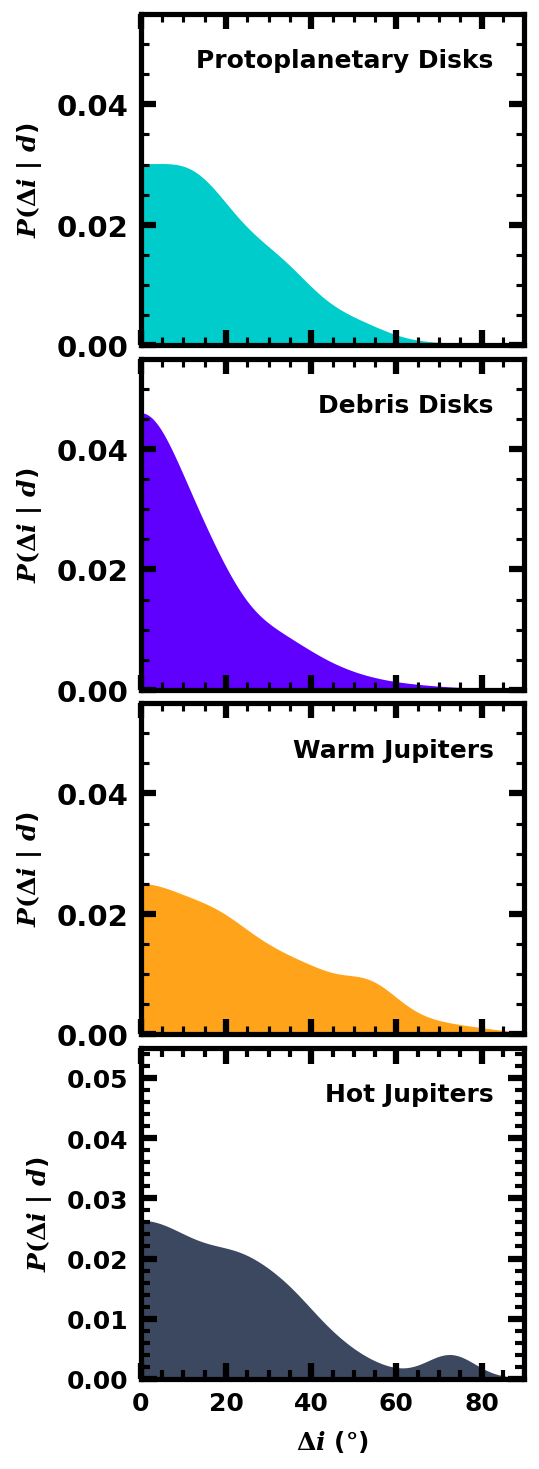

In [221]:
kde_stacked_plots_width = 3.5
kde_stacked_plots_height = 10

kde_stacked_plots_suptitlepad = 10
kde_stacked_plots_suptitle_fontsize = 14

kde_stacked_plots_labelpad = 6
kde_stacked_plots_label_fontsize = 12

kde_text_fontsize = 12


fig = plt.figure(figsize=(kde_stacked_plots_width, kde_stacked_plots_height), dpi=150)
axes = fig.subplot_mosaic(
    """
    d
    c
    b
    a
    """,
    gridspec_kw={'height_ratios': [1, 1, 1, 1], 'width_ratios': [1], "bottom": 0.07, "top": 0.98, "left": 0.25, "right": 0.98, "wspace": 0.44, "hspace": 0.04,}
)

axes['a'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_HJ))
axes['b'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_WJ))
axes['c'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_DD))
axes['d'].set_ylim(0, 1.20*max(density_estimation_total_positive_x_PD))

axes['a'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['b'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['c'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)
axes['d'].set_ylabel(r'$P(\Delta i$ | $d$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)

axes['a'].set_xlabel(r'$\Delta i$ ($\degree$)', fontsize=kde_stacked_plots_label_fontsize, labelpad=kde_stacked_plots_labelpad)

axes['a'].fill_between(x_grid_plot, density_estimation_total_positive_x_HJ, color=HJ_color, alpha=1, zorder=-4)
axes['b'].fill_between(x_grid_plot, density_estimation_total_positive_x_WJ, color=WJ_color, alpha=1, zorder=-6)
axes['c'].fill_between(x_grid_plot, density_estimation_total_positive_x_DD, color=dd_color, alpha=1, zorder=-9)
axes['d'].fill_between(x_grid_plot, density_estimation_total_positive_x_PD, color=pd_color, alpha=1, zorder=-11)


axes['a'].text(0.92, 0.86, 'Hot Jupiters', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['a'].transAxes)
axes['b'].text(0.92, 0.86, 'Warm Jupiters', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['b'].transAxes)
axes['c'].text(0.92, 0.86, 'Debris Disks', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['c'].transAxes)
axes['d'].text(0.92, 0.86, 'Protoplanetary Disks', horizontalalignment='right', verticalalignment='center', fontsize=kde_text_fontsize, transform=axes['d'].transAxes)

axes['a'].tick_params(which='minor', length=4.5, width=2, labelsize=kde_stacked_plots_label_fontsize)
axes['a'].tick_params(which='major', length=7.5, width=3, labelsize=kde_stacked_plots_label_fontsize)

for ax in axes.keys():
    axes[ax].minorticks_on()
    axes[ax].set_rasterized(True)

    for spine in axes[ax].spines.values():
        spine.set_linewidth(2.5)

    # SPECIFY THE X TICKS
    xticks = [0, 20, 40, 60, 80]
    xticklabels = [str(int(xtick)) for xtick in xticks]
    axes[ax].set_xticks(xticks)
    if ax == 'a':
        axes[ax].set_xticklabels(xticklabels)
    else:
        axes[ax].set_xticklabels([])

    axes[ax].set_xlim(0, 90)
    axes[ax].set_ylim(0, 0.055)

    yticks = axes[ax].get_yticks()
    yticklabels = ['{:.2f}'.format(ytick) for ytick in yticks]
    yticklabels[-1] = ' '
    # print(yticklabels)
    axes[ax].set_yticklabels(yticklabels)


# SAVE THE FIGURE
save_par_vs_stacked_kde = 'Stacked_KDE_' + light_or_dark_dext + '_' + transparent_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_par_vs_stacked_kde, dpi=300, transparent=False)



49


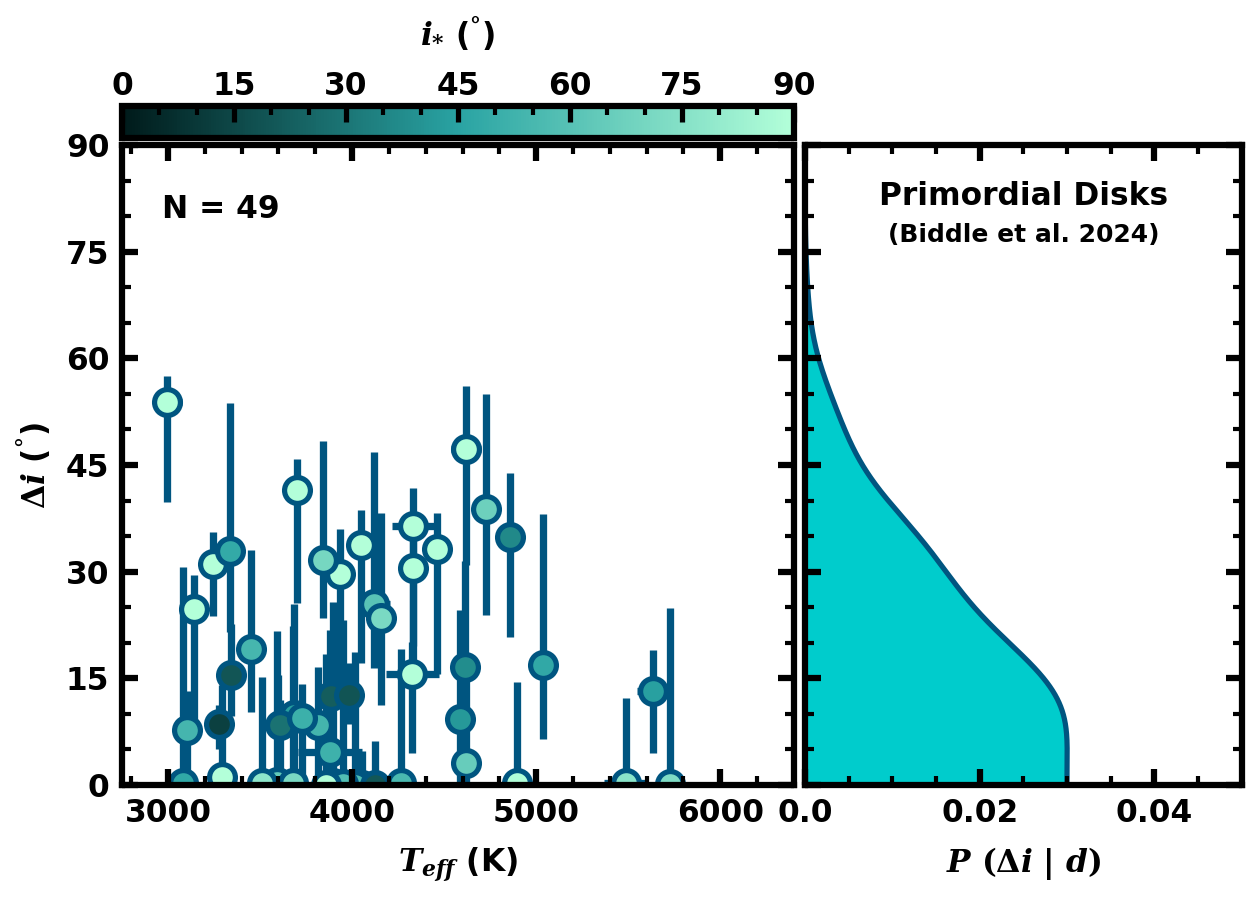

21


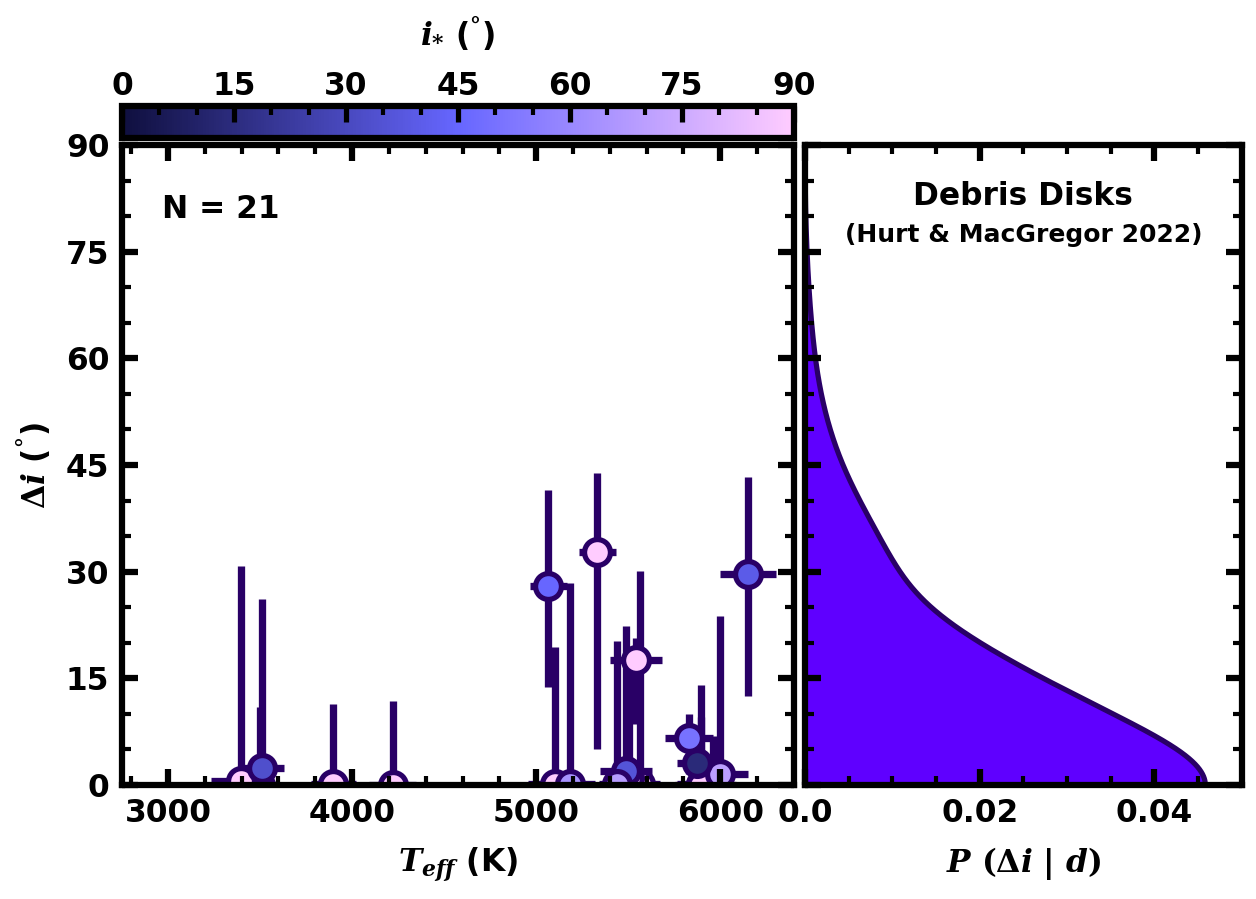

21


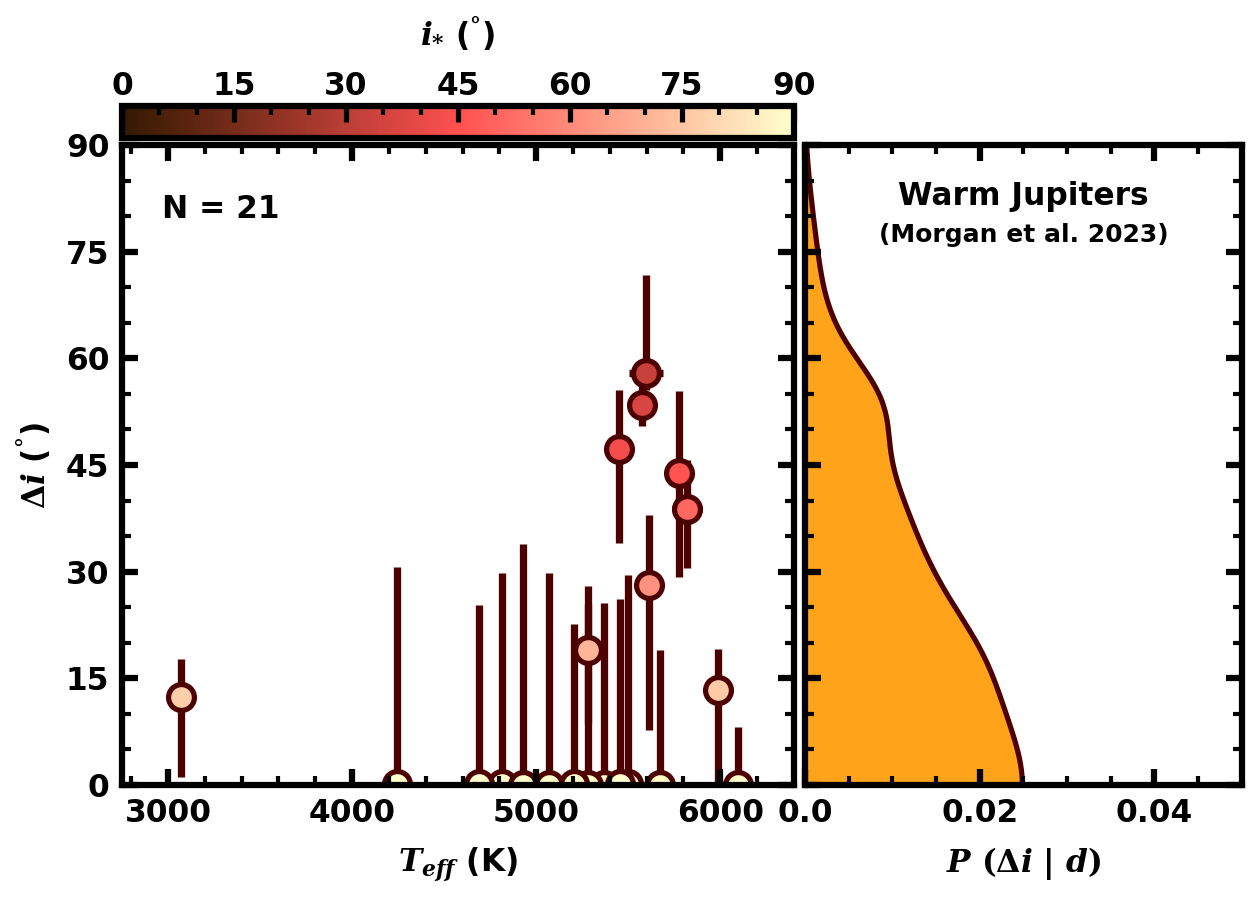

20


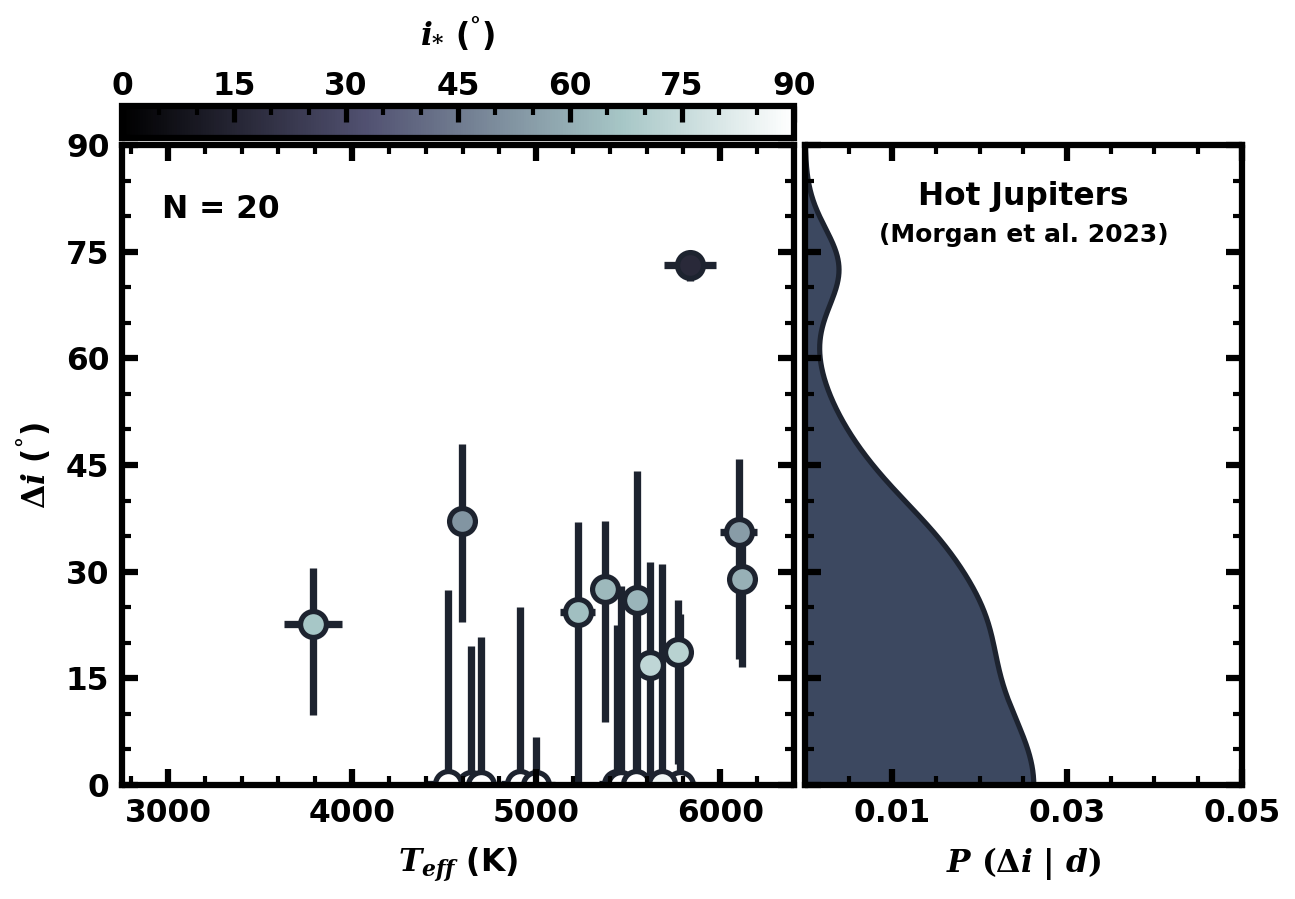

In [222]:

x_column = 'SpType Decimal'
x_column = 'Teff (K)'

if x_column == 'SpType Decimal':
    x_column_err_p = 'SpType Decimal Unc'
    x_column_err_m = 'SpType Decimal Unc'
    x_label = 'SpType'
    xlims = [2.25, 5.75]
    x_text = 'SpT'

if x_column == 'Teff (K)':
    x_column_err_p = 'Teff Unc'
    x_column_err_m = 'Teff Unc'
    x_label = r'$T_{eff}$ (K)'
    xlims = [2750, 6400]
    dx1 = 1000
    x_text = 'Teff'

y_column = 'disk diff'
y_column_err_p = 'disk diff +Unc'
y_column_err_m = 'disk diff -Unc'
y_label = r'$\Delta i$ ($^\degree$)'
ylims = [-2, 90]
y_text = 'Delta_i'

z_column = 'i star (deg)'
z_column_err_p = 'i star -Unc'
z_column_err_m = 'i star +Unc'
z_label = r'$i_{*}$ ($^\degree$)'
zlims = [0, 90]
z_text = 'i_Star'

parameter_z_norm = plt.Normalize(zlims[0], zlims[1])


datasets = ['PD', 'DD', 'WJ', 'HJ']

for which_dataset in datasets:


    if which_dataset == 'PD':
        plot_df = df_PD
    if which_dataset == 'DD':
        plot_df = df_DD
    if which_dataset == 'WJ':
        plot_df = df_WJ
    if which_dataset == 'HJ':
        plot_df = df_HJ

    parameter_x = np.array(plot_df[x_column].values)
    parameter_x_err_p = np.array(plot_df[x_column_err_p].values)
    parameter_x_err_m = np.array(plot_df[x_column_err_m].values)
    parameter_y = np.array(plot_df[y_column].values)
    parameter_y_err_p = np.array(plot_df[y_column_err_p].values)
    parameter_y_err_m = np.array(plot_df[y_column_err_m].values)
    parameter_z = np.array(plot_df[z_column].values)
    parameter_z_err_p = np.array(plot_df[z_column_err_p].values)
    parameter_z_err_m = np.array(plot_df[z_column_err_m].values)
    targets_list = np.array(plot_df['Target'].values)

    parameter_x_err = [parameter_x_err_m, parameter_x_err_p]
    parameter_y_err = [parameter_y_err_m, parameter_y_err_p]
    parameter_z_err = [parameter_z_err_m, parameter_z_err_p]

    if which_dataset == 'PD':
        dataset_type = 'Primordial Disks'
        dataset_author = '(PD et al. 2024)'
        colormap = choose_cmap('primordial disks', reverse_cmap=False)
        kde_color = pd_color
        kde_linecolor = pd_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1
        density_estimation_total_positive_x = density_estimation_total_positive_x_PD
        if x_column == 'SpType Decimal':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'DD':
        dataset_type = 'Debris Disks'
        dataset_author = r'(Hurt & MacGregor 2022)'
        colormap = choose_cmap('debris disks', reverse_cmap=False)
        kde_color = dd_color
        kde_linecolor = dd_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_DD
        if x_column == 'SpType Decimal':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'WJ':
        dataset_type = 'Warm Jupiters'
        dataset_author = '(Morgan et al. 2023)'
        colormap = choose_cmap('warm jupiters', reverse_cmap=False)
        kde_color = WJ_color
        kde_linecolor = WJ_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_WJ
        if x_column == 'SpType Decimal':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.0
    if which_dataset == 'HJ':
        dataset_type = 'Hot Jupiters'
        dataset_author = '(Morgan et al. 2023)'
        colormap = plt.get_cmap('bone')
        kde_color = '#3c4860'  # HJ_color
        kde_linecolor = HJ_linecolor
        dx2 = 0.02
        kde_alpha = 1
        err_alpha = 1  # 0.5
        density_estimation_total_positive_x = density_estimation_total_positive_x_HJ
        if x_column == 'SpType Decimal':
            x2min = dx2
        if x_column == 'Teff (K)':
            x2min = 0.01



    point_colors = [colormap(parameter_z_norm(bep)) for bep in plot_df['i star (deg)'].values]


    grid_height = 2
    grid_width = 2

    original_fig_width = 8
    original_fig_height = 6.5

    original_width_ratios = [1, 0.40]
    original_height_ratios = [0.05, 1]


    fig_width = 8.25
    fig_height = 5.80

    try_width_ratios = [1, 0.65]
    try_height_ratios = [0.05, 1]


    single_parplot_fontsize = 15

    target_labels_on = False

    point_size = 7

    z_colors_on = True

    include_HBM_models = True

    zorder_shift = 10



    fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
    gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=try_width_ratios, height_ratios=try_height_ratios)
    axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
    cbar_ax = axes[0]
    blank_ax = axes[1]
    ax1 = axes[2]
    ax2 = axes[3]


    # MAKE INVISIBLE AXES SPINES INVISIBRU
    for spine in blank_ax.spines.values():
        spine.set_edgecolor('#ffffff')
    blank_ax.set_xticklabels([])
    blank_ax.set_yticklabels([])
    blank_ax.tick_params(axis='both', which='both', color='#ffffff')



    ax1.minorticks_on()
    ax2.minorticks_on()

    ax1.set_xlabel(x_label, fontsize=single_parplot_fontsize, labelpad=8)
    ax1.set_ylabel(r'$\Delta i$ ($^\degree$)', fontsize=single_parplot_fontsize, labelpad=6)
    ax2.set_xlabel(r'$P$ $(\Delta i$ | $d)$', fontsize=single_parplot_fontsize, labelpad=8)


    point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z]
    point_edgecolors = [kde_linecolor]*len(point_colors)  # [edge_color]*len(point_colors)
    if z_colors_on == True:
        point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z]
    else:
        point_colors = [point_color_no_z]*len(point_colors)

    print(len(parameter_y))

    # -------------------------------------- THE SAMPLE ---------------------------------------  #
    for par_i in range(0, len(parameter_y)):
        if parameter_z[par_i] == 90.0:
            zord = -4
        if parameter_z[par_i] < 90:
            zord = -1
        # print([parameter_x[par_i]], [parameter_y[par_i]])
        ax1.scatter([parameter_x[par_i]], [parameter_y[par_i]], color=point_colors[par_i], edgecolors=point_edgecolors[par_i], linewidth=2.5, s=np.pi*point_size**2, linestyle='None', zorder=zord)
        ax1.errorbar([parameter_x[par_i]], [parameter_y[par_i]], xerr=[[parameter_x_err[0][par_i]],[parameter_x_err[1][par_i]]], yerr=[[parameter_y_err[0][par_i]], [parameter_y_err[1][par_i]]],
                    elinewidth=3.5, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=0, zorder=-5, alpha=err_alpha)
    # ---------------------------------------------------------------------------------------- #


    # --------------------------------------- COLORBAR --------------------------------------- #
    if z_colors_on == True:
        # Add a single colorbar
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), cax=cbar_ax, orientation='horizontal') # , use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
        cbar.set_label(z_label, labelpad=12, fontsize=single_parplot_fontsize, weight='bold')  # rotation=270
        cbar_ticks = np.arange(0, 105, 15)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks, fontsize=single_parplot_fontsize)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        Number_of_minor_ticks_between_major_ticks_cbar = 3
        yticks_minor_cbar = AutoMinorLocator(Number_of_minor_ticks_between_major_ticks_cbar)
        cbar.minorticks_on()
        cbar.ax.xaxis.set_minor_locator(yticks_minor_cbar)
        cbar.ax.tick_params(which='minor', length=4.5, width=2)
        cbar.ax.tick_params(which='major', length=7.5, width=2.5, pad=2)
    # ---------------------------------------------------------------------------------------- #



    # ------------------------------ KERNEL DENSITY ESTIMATION ------------------------------- #
    ax2.fill_between(density_estimation_total_positive_x, x_grid_plot, color=kde_color, alpha=kde_alpha, label='Gaussian KDE', zorder=1-zorder_shift)
    ax2.plot(density_estimation_total_positive_x, x_grid_plot, color=kde_linecolor, alpha=kde_alpha, zorder=1-zorder_shift+1)
    # ---------------------------------------------------------------------------------------- #


    # ---------------------------------------- THE SUN ---------------------------------------  #
    Solar_SpType = 4.98  # 4.6
    Solar_SpType_err = 0.1
    Solar_obliquity = 7.155
    Solar_obliquity_err = 0.002
    Solar_point_size = 750

    sun_color = '#ffff80'  # '#ace600'
    sun_edgecolor = '#26004d'  # '#001a33'
    ax1.scatter([Solar_SpType], [Solar_obliquity], marker='*', color=sun_color, edgecolors=sun_edgecolor, linewidth=2.5, s=Solar_point_size, linestyle='None')  # , label='The Pre-main Sequence Sun')
    # ax1.errorbar([Solar_SpType], [Solar_obliquity], xerr=[Solar_SpType_err], yerr=[Solar_obliquity_err], elinewidth=3, linewidth=0, capsize=0, ecolor='#001a33', capthick=0, zorder=-1)   
    # ---------------------------------------------------------------------------------------- #

    for spine in ax2.spines.values():
        spine.set_zorder(100)


    if x_column == 'SpType Decimal':
        sptype_designations = {'0': 'B',
                            '0.5': 'B5',
                            '1': 'A0',
                            '1.5': 'A5',
                            '2': 'F0',
                            '2.5': 'F5',
                            '3': 'G0',
                            '3.5': 'G5',
                            '4': 'K0',
                            '4.5': 'K5',
                            '5': 'M0',
                            '5.5': 'M5',
                            }

        xtickvals = [2.5, 3., 3.5, 4, 4.5, 5, 5.5]  # np.arange(xlims[0], xlims[1]+0.25, 0.25)
        xticklabs = []
        xticks = []
        for xtick in xtickvals:
            if xtick < xlims[1]:
                if (np.mod(xtick,1) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations[str(int(xtick))])
                elif (np.mod(xtick,0.5) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations['{:.1f}'.format(xtick)])
        ax1.set_xticks(xticks)
        xticklabels = ax1.set_xticklabels(xticklabs, fontsize=single_parplot_fontsize)

    if x_column == 'Teff (K)':
        xticks = [3000, 4000, 5000, 6000]
        # xticks = np.arange(xlims[0], xlims[1] + dx1, dx1)
        ax1.set_xticks(xticks)
        xticklabels = ax1.set_xticklabels(xticks, fontsize=single_parplot_fontsize)


    x2lim = 0.05  # 1.15 * max(density_estimation_total_positive_x)
    ax2_xtickvals = np.arange(x2min, x2lim + dx2, dx2)
    ax2.set_xticks(ax2_xtickvals)
    ax2_xtickvals = [str(np.round(xtick,2)) for xtick in ax2_xtickvals]
    ax2.set_xticklabels(ax2_xtickvals, fontsize=single_parplot_fontsize)




    ytickvals_major = np.arange(0, 105, 15)
    yticks_major = [int(ytick) for ytick in ytickvals_major]
    ax1.set_yticks(yticks_major, which='major')
    ax2.set_yticks(yticks_major, which='major')
    yticklabels = ax1.set_yticklabels(yticks_major, fontsize=single_parplot_fontsize)
    ax2.set_yticklabels([])

    Number_of_minor_ticks_between_major_ticks = 3
    yticks_minor = AutoMinorLocator(Number_of_minor_ticks_between_major_ticks) 
    ax1.yaxis.set_minor_locator(yticks_minor)
    ax2.yaxis.set_minor_locator(yticks_minor)


    ax1.set_xlim(xlims)
    ax1.set_ylim(0, 90)
    ax2.set_ylim(0, 90)
    ax2.set_xlim(0, x2lim)

    ax1.set_rasterized(True)

    ax1.tick_params(which='minor', length=4.5, width=2)
    ax1.tick_params(which='major', length=7.5, width=3, pad=6)

    ax2.tick_params(labelsize=single_parplot_fontsize)

    ax2.tick_params(which='minor', length=4.5, width=2)
    ax2.tick_params(which='major', length=7.5, width=3, pad=6)



    ax2.text(0.50, 0.92, dataset_type, horizontalalignment='center', verticalalignment='center', fontsize=single_parplot_fontsize, transform=ax2.transAxes)
    ax2.text(0.50, 0.86, dataset_author, horizontalalignment='center', verticalalignment='center', fontsize=0.8*single_parplot_fontsize, transform=ax2.transAxes)

    ax1.text(0.06, 0.90, 'N = {:d}'.format(len(parameter_y)), horizontalalignment='left', verticalalignment='center', fontsize=single_parplot_fontsize, transform=ax1.transAxes)



    fig.subplots_adjust(left=0.085, bottom=0.11, right=0.99, top=0.89, wspace=0.02, hspace=0.02)
    labels_text = 'bep'


    # SAVE THE FIGURE
    save_par_vs_Deltai_string = 'Scatter_Deltai' + light_or_dark_dext + '_' + transparent_text + '_' + which_dataset + '_' + date_str + '.pdf'

    if plot_transparent == True:
        fig.savefig(test_figures_directory + save_par_vs_Deltai_string, dpi=300, transparent=True)
    else:
        fig.savefig(test_figures_directory + save_par_vs_Deltai_string, dpi=300, transparent=False)

    plt.show()
    plt.close()

In [216]:
plot_df.columns

Index(['Target', 'SpType', 'SpType Letter', 'SpType Number', 'SpType Decimal',
       'SpType Decimal Unc', 'Teff (K)', 'Teff Unc', 'Mstar (Msun)',
       'Mstar Unc', 'Rstar (Rsun)', 'Rstar Unc', 'Prot (d)', 'Prot Unc',
       'vsini (km/s)', 'vsini Unc', 'i disk (deg)', 'i disk Unc',
       'i star (deg)', 'i star +Unc', 'i star -Unc', 'disk diff',
       'disk diff +Unc', 'disk diff -Unc', 'Veq', 'Veq Unc'],
      dtype='object')

In [233]:
def true_obliquity_posterior(i_star_deg, i_plane_deg, di):
    # Compute the posterior distribution conditioned on the stellar inclination angle and inclination of the disk or orbital plane

    true_obliquities_deg = np.arange(abs(i_plane_deg - i_star_deg), i_plane_deg + i_star_deg, di)
    print('true_obliquities_deg', true_obliquities_deg[0:10], '\n')
    
    true_obliquities_rad = []
    for obl in range(len(true_obliquities_deg)):
        true_obliquities_rad.append(np.radians(true_obliquities_deg[obl]))
    true_obliquities_rad = np.array(true_obliquities_rad)
    print('true_obliquities_rad', true_obliquities_rad[0:10], '\n')
    
    i_star_rad = np.radians(i_star_deg)
    i_plane_rad = np.radians(i_plane_deg)

    top = np.sin(i_star_rad) * np.sin(true_obliquities_rad)
    bottom1 = np.sin(true_obliquities_rad)**2 * np.sin(i_plane_rad)**2
    bottom2 = (np.cos(true_obliquities_rad) * np.cos(i_plane_rad) - np.cos(i_star_rad))**2
    print('top', top[0:10], '\n')
    print('bottom1', bottom1[0:10], '\n')
    print('bottom2', bottom2[0:10], '\n')

    posterior = top / np.sqrt(abs(bottom1 - bottom2))

    true_obliquities = []
    for obl2 in range(len(true_obliquities_rad)):
        true_obliquities.append(np.degrees(true_obliquities_rad[obl2]))

    posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
    posterior[0] = posterior[-1]


    return true_obliquities, posterior

minimum obliquity 30
istar 90
idisk 60
 
true_obliquities_deg [30 31 32 33 34 35 36 37 38 39] 

true_obliquities_rad [0.52359878 0.54105207 0.55850536 0.57595865 0.59341195 0.61086524
 0.62831853 0.64577182 0.66322512 0.68067841] 

top [0.5        0.51503807 0.52991926 0.54463904 0.5591929  0.57357644
 0.58778525 0.60181502 0.61566148 0.62932039] 

bottom1 [0.1875     0.19894816 0.21061082 0.22247376 0.23452253 0.24674245
 0.25911863 0.27163599 0.28427929 0.29703312] 

bottom2 [0.1875     0.18368395 0.17979639 0.17584208 0.17182582 0.16775252
 0.16362712 0.15945467 0.15524024 0.15098896] 

[29.999999999999996, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.00000000000001, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.00000000000001, 58.00000000000001, 59.00000000000001, 59.99999999999999, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0,

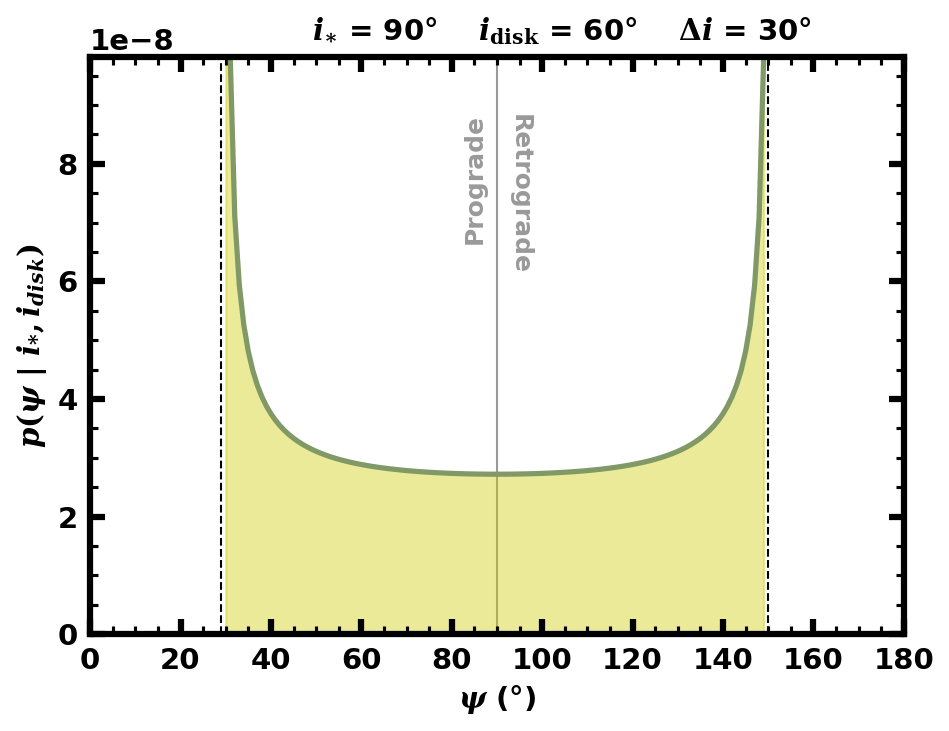

In [243]:
dx = 1
istar = 90
iplane = 60
print('minimum obliquity', np.round(istar - iplane, 1))
print('istar', istar)
print('idisk', iplane)
print(' ')


plotx, ploty = true_obliquity_posterior(i_star_deg=istar, i_plane_deg=iplane, di=dx)

print(plotx)
print(ploty)

test_fig = plt.figure(figsize=(7, 5), dpi=150)
ax = test_fig.add_subplot(111)
ax.minorticks_on()

ax.set_title(r'$i_{\ast}$ = ' + '{:d}'.format(istar) + r'$\degree$    ' + r'$i_{\mathrm{disk}}$ = ' + '{:d}'.format(iplane) + r'$\degree$    ' + r'$\Delta i$ = ' + '{:d}'.format(abs(istar - iplane)) + r'$\degree$    ', pad=8, x=0.6)
ax.set_xlabel(r'$\psi$ ($\degree$)')
ax.set_ylabel(r'$p(\psi$ | $i_{*}, i_{disk})$')

xmin, xmax = 0, 180
ymin, ymax = 0, np.nanmax(ploty)  # -0.04 * max(ploty), 1.14 * max(ploty)
print(ymin, ymax)

linecolor = '#809966'  # '#476685'
fillcolor = '#cccc00'  # '#476685'

ax.plot(plotx, ploty, color=linecolor)
ax.fill_between(plotx, ploty, color=fillcolor, alpha=0.4)

ax.plot([90, 90], [0, ymax], lw=1, color='#000000', alpha=0.4, zorder = -10)
ax.plot([np.nanmin(plotx) - dx, np.nanmin(plotx) - dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)
ax.plot([np.nanmax(plotx) + dx, np.nanmax(plotx) + dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)

ax.text(90 - 5, 0.90 * np.nanmax(ploty), 'Prograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=90, color='#000000', alpha=0.4)
ax.text(90 + 5, 0.90 * np.nanmax(ploty), 'Retrograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=270, color='#000000', alpha=0.4)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

In [244]:
df_PD['Target'].values

array(['2MASS J04124068+2438157', '2MASS J04202555+2700355',
       '2MASS J04334465+2615005', '2MASS J04343128+1722201',
       '2MASS J04360131+1726120', '2MASS J11004022-7619280',
       '2MASS J16083070-3828268', 'AA Tau', 'AS 209', 'BP Tau', 'CI Tau',
       'CIDA-7', 'CR Cha', 'CX Tau', 'DE Tau', 'DN Tau', 'DoAr 25',
       'DoAr 44', 'EX Lup', 'Elias 2-24', 'FP Tau', 'FT Tau', 'GM Aur',
       'GW Lup', 'IM Lup', 'IP Tau', 'IQ Tau', 'LkCa 15', 'MHO 6',
       'MP Mus', 'MY Lup', 'PDS 111', 'PDS 70', 'RU Lup',
       'RX J1615.3-3255', 'RX J1842.9-3532', 'RX J1852.3-3700', 'RY Lup',
       'SU Aur', 'SY Cha', 'Sz 114', 'Sz 73', 'Sz 90', 'T Cha', 'TW Hya',
       'V1094 Sco', 'V836 Tau', 'WSB 52', 'WSB 63'], dtype=object)

In [246]:
for test_targ in df_PD['Target'].values:

    if test_targ == 'CX Tau':

        print(test_targ)
        test_df = df_PD[df_PD['Target'] == test_targ]

        dx = 1
        istar = test_df['i star (deg)'].values[0]
        iplane = test_df['i disk (deg)'].values[0]
        print('minimum obliquity', test_df['disk diff'].values[0])
        print('istar', istar)
        print('idisk', iplane)
        print(' ')


        plotx, ploty = true_obliquity_posterior(i_star_deg=istar, i_plane_deg=iplane, di=dx)

        print_posterior = False

        if print_posterior == True:
            for  beep in range(len(plotx)):
                print(plotx[beep], ploty[beep])


        test_fig = plt.figure(figsize=(7, 5), dpi=150)
        ax = test_fig.add_subplot(111)
        ax.minorticks_on()

        ax.set_title(test_targ)
        ax.set_xlabel(r'$\psi$ ($\degree$)')
        ax.set_ylabel(r'$p(\psi$ | $i_{*}, i_{disk})$')

        xmin, xmax = 0, 180
        ymin, ymax = 0, np.nanmax(ploty)  # -0.04 * max(ploty), 1.14 * max(ploty)
        print(ymin, ymax)

        linecolor = '#809966'  # '#476685'
        fillcolor = '#cccc00'  # '#476685'

        ax.plot(plotx, ploty, color=linecolor)
        ax.fill_between(plotx, ploty, color=fillcolor, alpha=0.4)

        ax.plot([90, 90], [0, ymax], lw=1, color='#000000', alpha=0.4, zorder = -10)
        ax.plot([np.nanmin(plotx) - dx, np.nanmin(plotx) - dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)
        ax.plot([np.nanmax(plotx) + dx, np.nanmax(plotx) + dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)

        ax.text(90 - 5, 0.90 * np.nanmax(ploty), 'Prograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=90, color='#000000', alpha=0.4)
        ax.text(90 + 5, 0.90 * np.nanmax(ploty), 'Retrograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=270, color='#000000', alpha=0.4)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        # SAVE THE FIGURE
        save_true_obliquity_string = 'True_Obliquities/' + test_targ + '_TrueObliquity_' + light_or_dark_dext + '_' + transparent_text + '_' + which_dataset + '_' + date_str + '.pdf'

        if plot_transparent == True:
            test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=True)
        else:
            test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=False)

    

2MASS J04124068+2438157
minimum obliquity 32.905
istar 48.21
idisk 15.84
 
true_obliquities_deg [32.37 33.37 34.37 35.37 36.37 37.37 38.37 39.37 40.37 41.37] 

true_obliquities_rad [0.56496308 0.58241637 0.59986966 0.61732296 0.63477625 0.65222954
 0.66968283 0.68713613 0.70458942 0.72204271] 

top [0.39917867 0.41010824 0.42091288 0.43158932 0.44213428 0.45254457
 0.462817   0.47294846 0.48293586 0.49277614] 

bottom1 [0.02135523 0.02254065 0.023744   0.02496381 0.02619859 0.02744683
 0.02870702 0.02997762 0.03125708 0.03254384] 

bottom2 [0.02135523 0.01877491 0.01629813 0.0139393  0.01171299 0.00963388
 0.00771678 0.00597658 0.00442823 0.00308672] 

0 4.7887649896074794e-08
2MASS J04202555+2700355
minimum obliquity 0.21
istar 47.29
idisk 38.25
 
true_obliquities_deg [ 9.04 10.04 11.04 12.04 13.04 14.04 15.04 16.04 17.04 18.04] 

true_obliquities_rad [0.15777776 0.17523106 0.19268435 0.21013764 0.22759093 0.24504423
 0.26249752 0.27995081 0.2974041  0.3148574 ] 

top [0.11545409 0.12

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


2MASS J04334465+2615005
minimum obliquity 24.785
istar 90.0
idisk 57.565
 
true_obliquities_deg [32.435 33.435 34.435 35.435 36.435 37.435 38.435 39.435 40.435 41.435] 

true_obliquities_rad [0.56609754 0.58355084 0.60100413 0.61845742 0.63591071 0.65336401
 0.6708173  0.68827059 0.70572388 0.72317718] 

top [0.53634247 0.55099062 0.56547093 0.579779   0.59391046 0.60786101
 0.6216264  0.63520243 0.64858498 0.66176996] 

bottom1 [0.2049131  0.21625879 0.22777493 0.2394475  0.25126228 0.26320487
 0.27526073 0.28741515 0.29965334 0.31196039] 

bottom2 [0.2049131  0.20033137 0.1956808  0.19096706 0.18619589 0.18137311
 0.17650459 0.17159626 0.16665411 0.16168415] 

0 1.6488750764004123e-07
2MASS J04343128+1722201
minimum obliquity 1.0699999999999998
istar 90.0
idisk 68.54
 
true_obliquities_deg [21.46 22.46 23.46 24.46 25.46 26.46 27.46 28.46 29.46 30.46] 

true_obliquities_rad [0.37454766 0.39200095 0.40945424 0.42690754 0.44436083 0.46181412
 0.47926741 0.49672071 0.514174   0.53162729]

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


DoAr 25
minimum obliquity 15.65
istar 90.0
idisk 67.4
 
true_obliquities_deg [22.6 23.6 24.6 25.6 26.6 27.6 28.6 29.6 30.6 31.6] 

true_obliquities_rad [0.39444441 0.4118977  0.429351   0.44680429 0.46425758 0.48171087
 0.49916417 0.51661746 0.53407075 0.55152404] 

top [0.38429532 0.40034903 0.41628079 0.43208575 0.44775909 0.46329604
 0.47869186 0.49394187 0.50904142 0.52398591] 

bottom1 [0.12587266 0.13660883 0.14769777 0.15912598 0.17087952 0.18294408
 0.19530497 0.20794711 0.2208551  0.23401323] 

bottom2 [0.12587266 0.12401238 0.12209097 0.12011078 0.11807422 0.11598376
 0.11384197 0.11165143 0.10941484 0.1071349 ] 

0 0.0
DoAr 44
minimum obliquity 16.6
istar 37.88
idisk 21.8
 
true_obliquities_deg [16.08 17.08 18.08 19.08 20.08 21.08 22.08 23.08 24.08 25.08] 

true_obliquities_rad [0.28064894 0.29810224 0.31555553 0.33300882 0.35046211 0.36791541
 0.3853687  0.40282199 0.42027528 0.43772858] 

top [0.17006796 0.18033875 0.19055461 0.20071243 0.2108091  0.22084157
 0.23080676 0.

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


EX Lup
minimum obliquity 0.2149999999999999
istar 40.67
idisk 32.4
 
true_obliquities_deg [ 8.27  9.27 10.27 11.27 12.27 13.27 14.27 15.27 16.27 17.27] 

true_obliquities_rad [0.14433873 0.16179202 0.17924531 0.19669861 0.2141519  0.23160519
 0.24905848 0.26651178 0.28396507 0.30141836] 

top [0.09373946 0.10498067 0.1161899  0.12736374 0.13849878 0.14959163
 0.16063891 0.17163727 0.18258334 0.19347379] 

bottom1 [0.00594014 0.00745024 0.00912617 0.01096587 0.01296712 0.01512747
 0.01744428 0.01991475 0.02253585 0.02530439] 

bottom2 [0.00594014 0.00559886 0.00523089 0.00484015 0.00443093 0.00400791
 0.00357609 0.00314089 0.00270803 0.00228359] 

0 2.414868600424293e-07
Elias 2-24
minimum obliquity 0.025
istar 31.11
idisk 29.0
 
true_obliquities_deg [ 2.11  3.11  4.11  5.11  6.11  7.11  8.11  9.11 10.11 11.11] 

true_obliquities_rad [0.03682645 0.05427974 0.07173303 0.08918632 0.10663962 0.12409291
 0.1415462  0.15899949 0.17645279 0.19390608] 

top [0.01902329 0.02803164 0.03703144 0.

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  test_fig = plt.figure(figsize=(7, 5), dpi=150)


GM Aur
minimum obliquity 30.565
istar 90.0
idisk 52.775
 
true_obliquities_deg [37.225 38.225 39.225 40.225 41.225 42.225 43.225 44.225 45.225 46.225] 

true_obliquities_rad [0.64969881 0.66715211 0.6846054  0.70205869 0.71951198 0.73696528
 0.75441857 0.77187186 0.78932515 0.80677845] 

top [0.60494661 0.61875123 0.63236738 0.6457909  0.6590177  0.67204376
 0.68486511 0.69747785 0.70987812 0.72206216] 

bottom1 [0.23203339 0.24274402 0.25354514 0.2644236  0.27536614 0.28635943
 0.29739008 0.30844464 0.31950964 0.33057162] 

bottom2 [0.23203339 0.22585133 0.21961705 0.21333812 0.20702221 0.20067701
 0.19431025 0.18792969 0.18154309 0.17515825] 

0 5.540118565528146e-08
GW Lup
minimum obliquity 8.435
istar 28.95
idisk 38.7
 
true_obliquities_deg [ 9.75 10.75 11.75 12.75 13.75 14.75 15.75 16.75 17.75 18.75] 

true_obliquities_rad [0.1701696  0.18762289 0.20507619 0.22252948 0.23998277 0.25743606
 0.27488936 0.29234265 0.30979594 0.32724923] 

top [0.08197298 0.09028625 0.09857201 0.10682

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


IP Tau
minimum obliquity 8.45
istar 53.66
idisk 45.235
 
true_obliquities_deg [ 8.425  9.425 10.425 11.425 12.425 13.425 14.425 15.425 16.425 17.425] 

true_obliquities_rad [0.14704399 0.16449728 0.18195057 0.19940387 0.21685716 0.23431045
 0.25176374 0.26921704 0.28667033 0.30412362] 

top [0.11801973 0.13190822 0.14575652 0.15956043 0.17331574 0.18701825
 0.20066379 0.21424821 0.22776737 0.24121714] 

bottom1 [0.01082132 0.01351807 0.01650543 0.01977978 0.0233371  0.02717308
 0.03128304 0.03566197 0.04030454 0.04520508] 

bottom2 [0.01082132 0.01042825 0.01000009 0.00953964 0.00905    0.00853451
 0.00799678 0.00744066 0.00687026 0.00628992] 

0 2.451521600623664e-07
IQ Tau
minimum obliquity 9.395
istar 51.06
idisk 62.115
 
true_obliquities_deg [11.055 12.055 13.055 14.055 15.055 16.055 17.055 18.055 19.055 20.055] 

true_obliquities_rad [0.19294615 0.21039944 0.22785273 0.24530603 0.26275932 0.28021261
 0.2976659  0.3151192  0.33257249 0.35002578] 

top [0.14914496 0.16244491 0.17569

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


RX J1842.9-3532
minimum obliquity 47.21
istar 90.0
idisk 32.0
 
true_obliquities_deg [58. 59. 60. 61. 62. 63. 64. 65. 66. 67.] 

true_obliquities_rad [1.01229097 1.02974426 1.04719755 1.06465084 1.08210414 1.09955743
 1.11701072 1.13446401 1.15191731 1.1693706 ] 

top [0.8480481  0.8571673  0.8660254  0.87461971 0.88294759 0.89100652
 0.89879405 0.90630779 0.91354546 0.92050485] 

bottom1 [0.20195768 0.20632441 0.21061082 0.2148117  0.21892193 0.2229365
 0.22685053 0.23065923 0.23435798 0.23794226] 

bottom2 [0.20195768 0.1907742  0.17979639 0.16903764 0.15851105 0.14822945
 0.13820536 0.128451   0.11897825 0.10979865] 

0 4.2702342298924866e-08
RX J1852.3-3700
minimum obliquity 38.77
istar 67.01
idisk 30.0
 
true_obliquities_deg [37.01 38.01 39.01 40.01 41.01 42.01 43.01 44.01 45.01 46.01] 

true_obliquities_rad [0.64594636 0.66339965 0.68085294 0.69830623 0.71575953 0.73321282
 0.75066611 0.7681194  0.7855727  0.80302599] 

top [0.55414299 0.56688795 0.57946024 0.59185601 0.6040715  

/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:23: RuntimeWarning: divide by zero encountered in divide
  posterior = top / np.sqrt(abs(bottom1 - bottom2))
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/574779266.py:29: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / (sum(posterior) * np.diff(true_obliquities)[0])
/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_12062/4266472506.py:50: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


WSB 63
minimum obliquity 0.33
istar 90.0
idisk 67.3
 
true_obliquities_deg [22.7 23.7 24.7 25.7 26.7 27.7 28.7 29.7 30.7 31.7] 

true_obliquities_rad [0.39618974 0.41364303 0.43109633 0.44854962 0.46600291 0.4834562
 0.5009095  0.51836279 0.53581608 0.55326937] 

top [0.38590604 0.40194778 0.41786707 0.43365908 0.449319   0.46484205
 0.4802235  0.49545867 0.51054292 0.52547165] 

bottom1 [0.12674527 0.13750164 0.14860893 0.16005362 0.17182177 0.18389902
 0.19627068 0.20892166 0.22183656 0.23499964] 

bottom2 [0.12674527 0.1248631  0.12291952 0.1209169  0.11885768 0.11674437
 0.11457955 0.11236584 0.11010596 0.10780266] 

0 8.798855010512342e-08


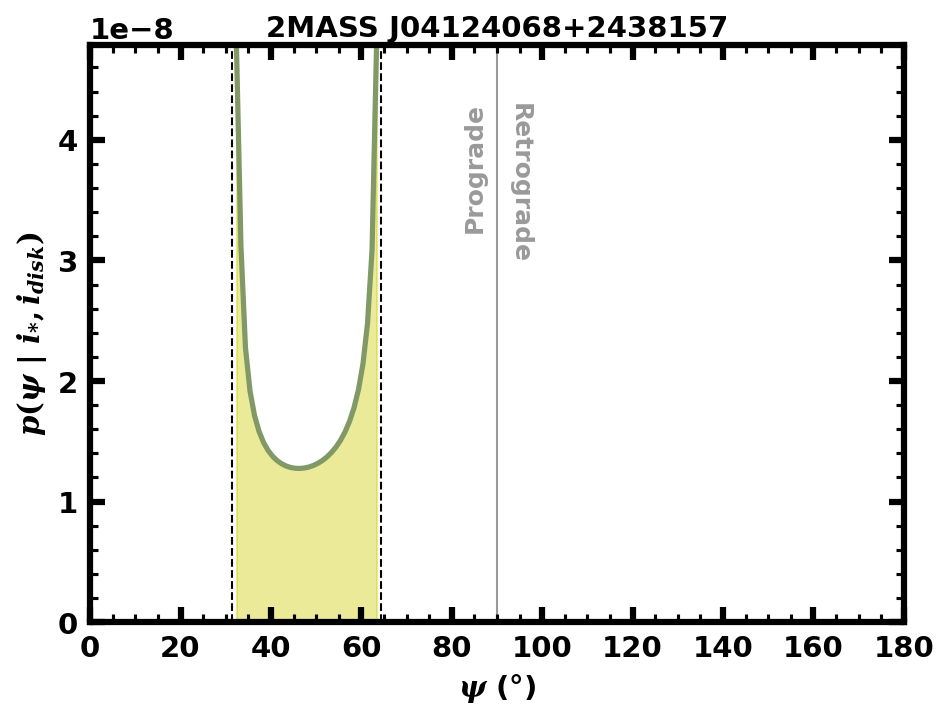

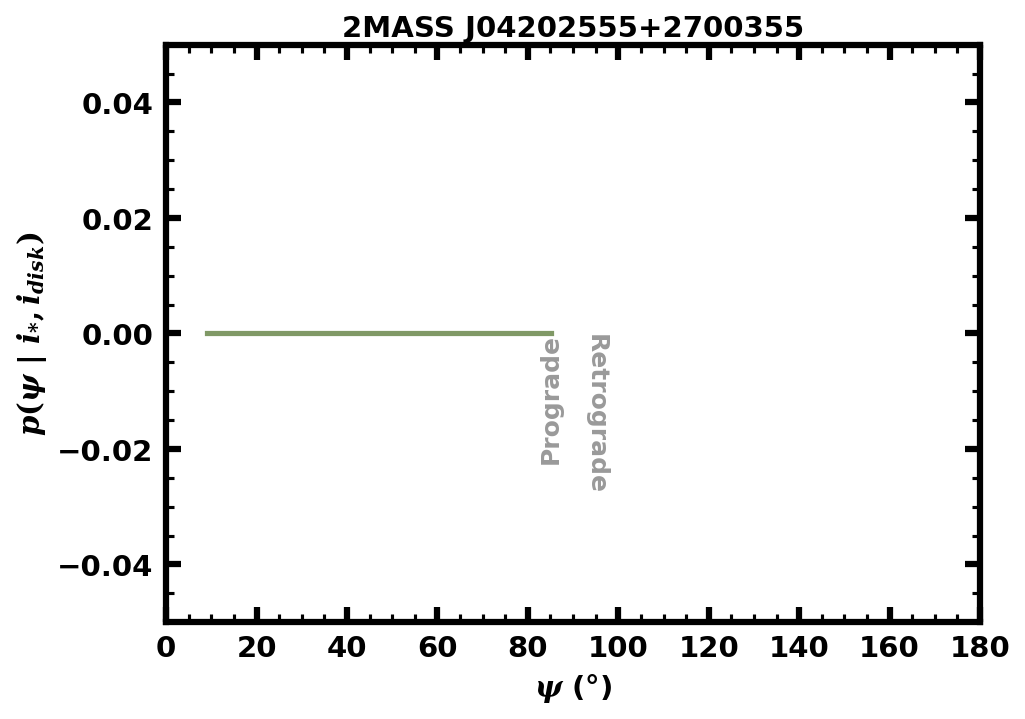

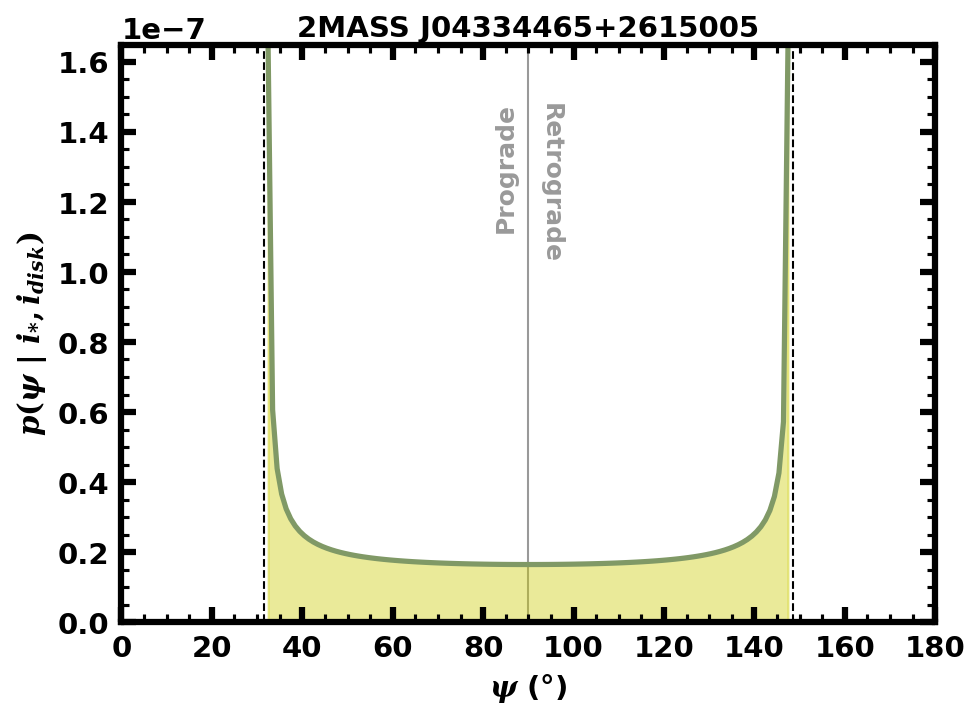

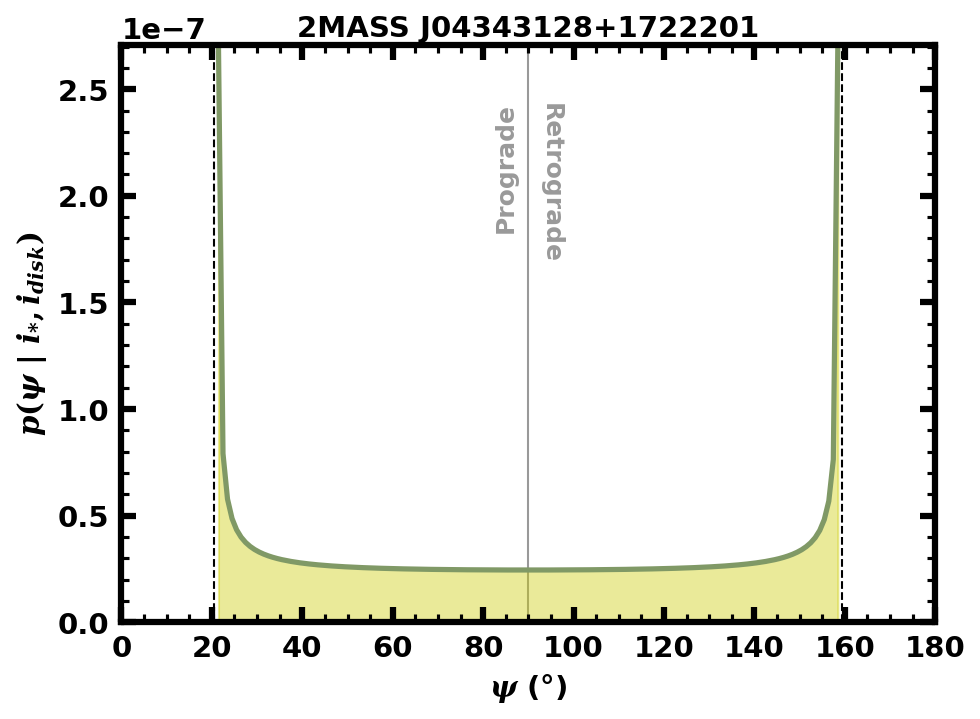

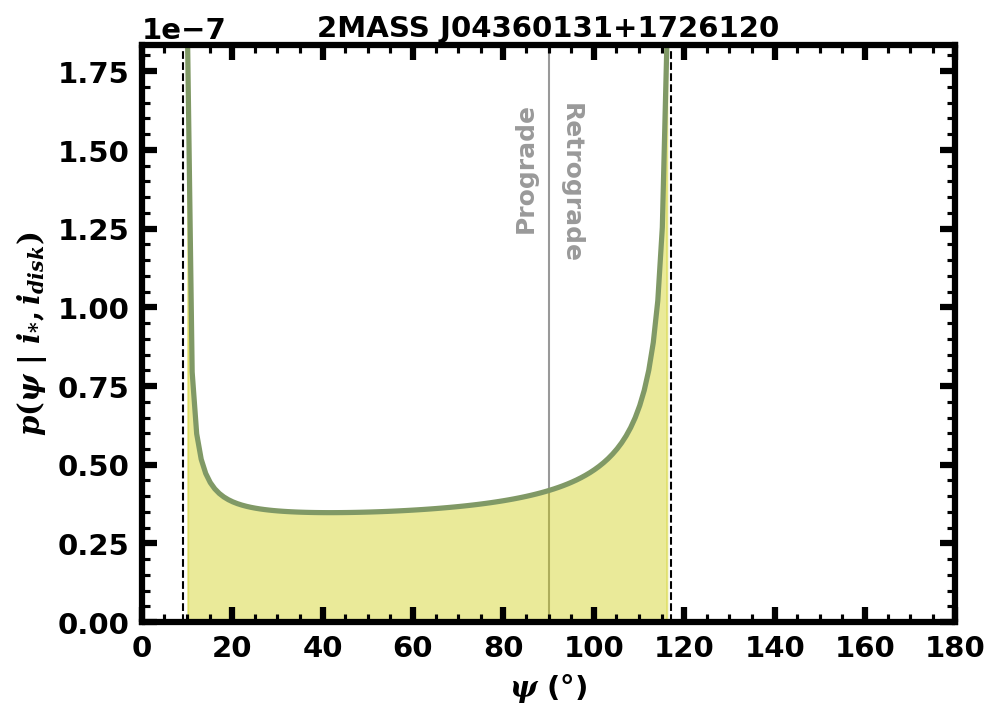

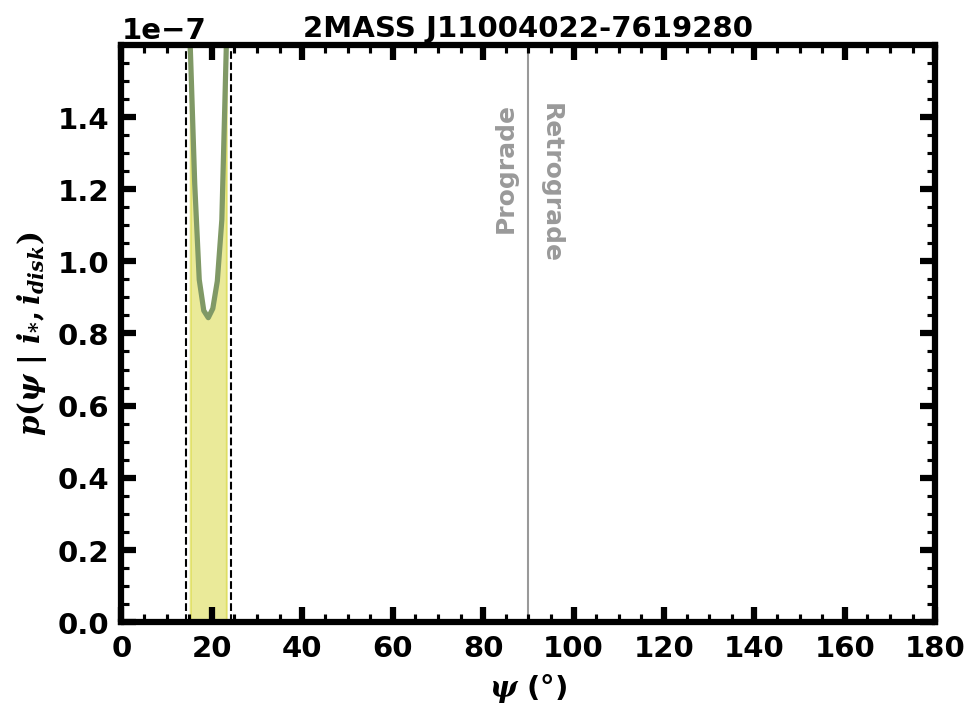

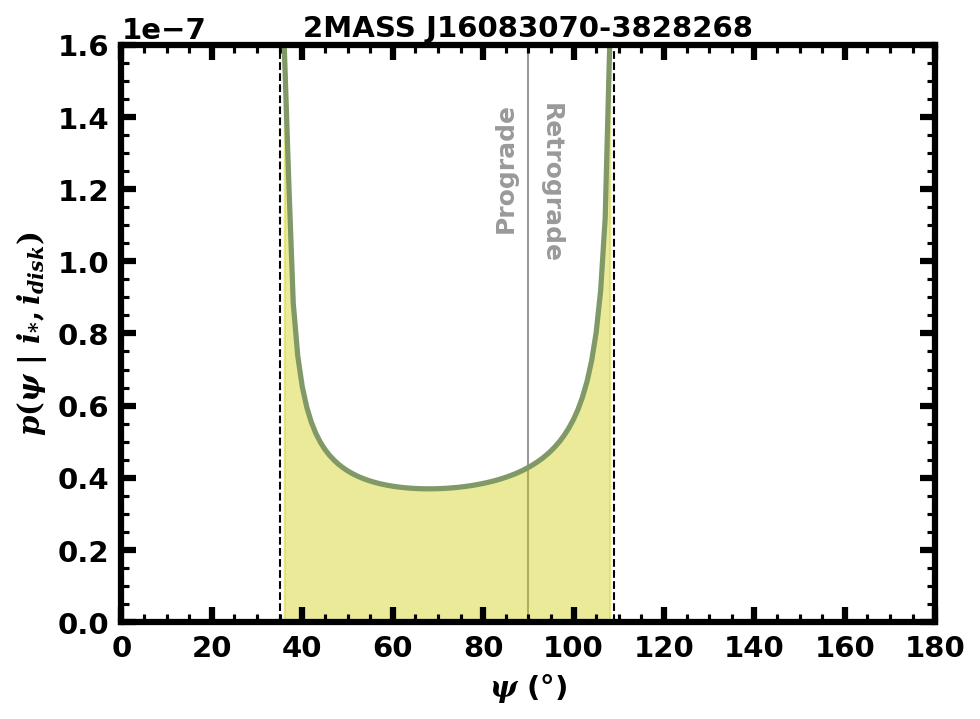

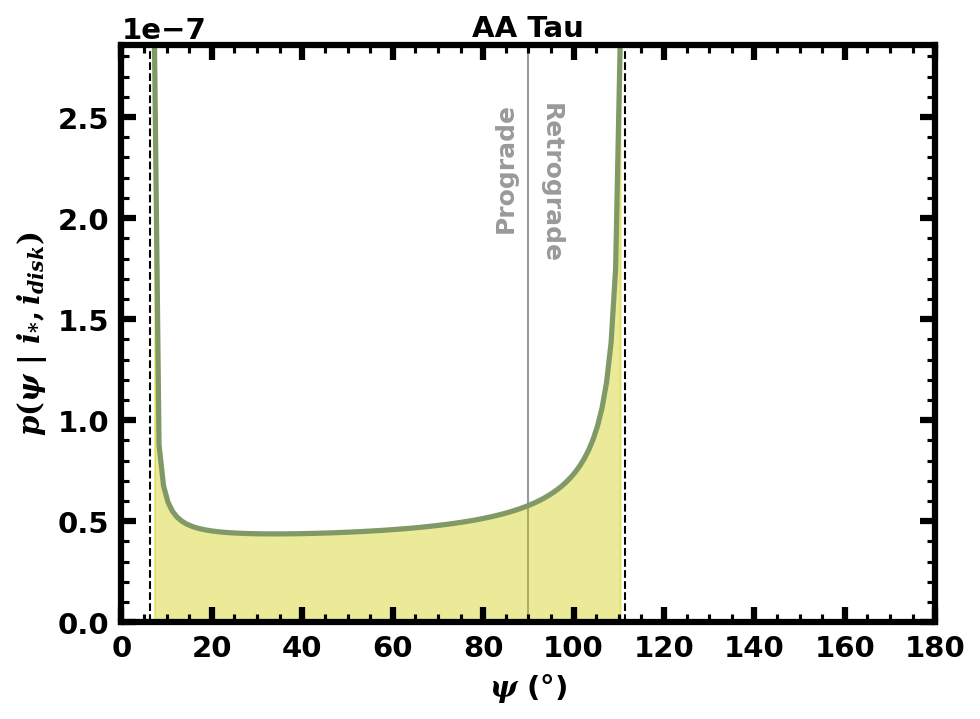

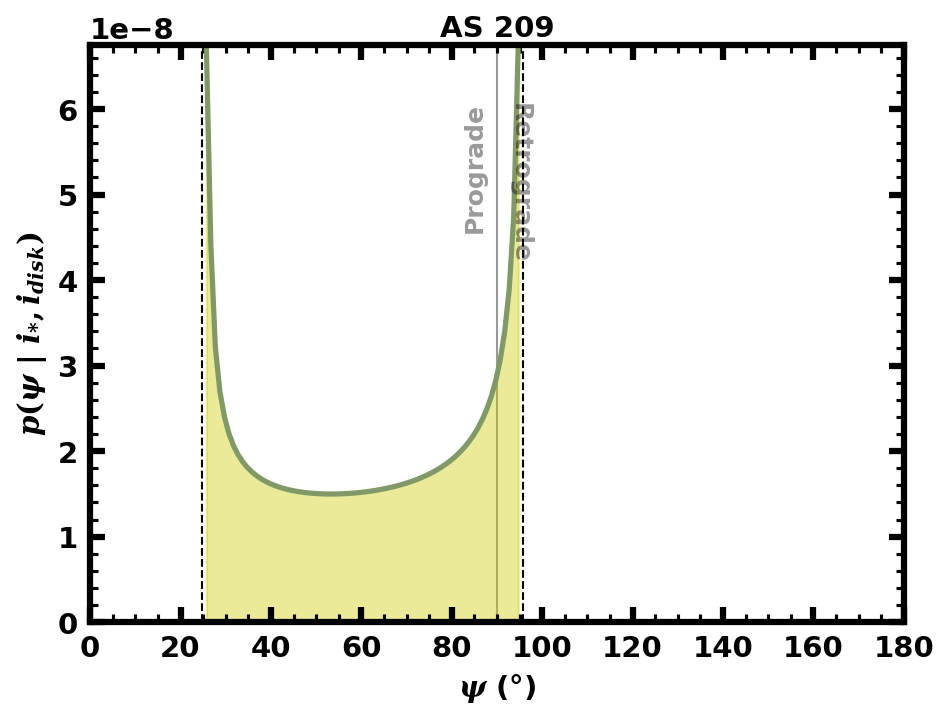

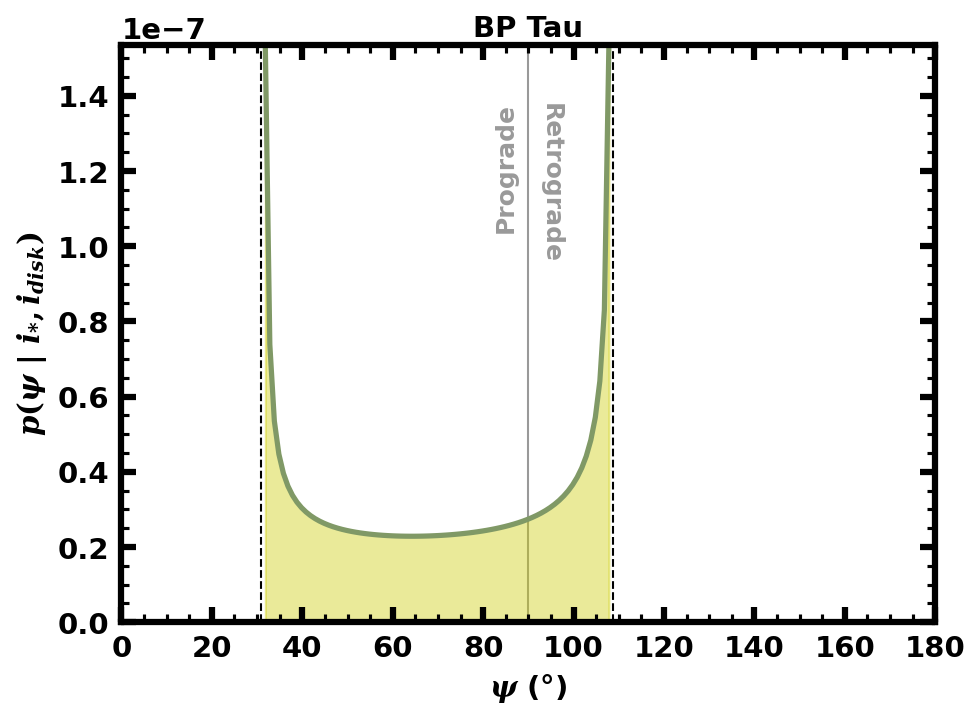

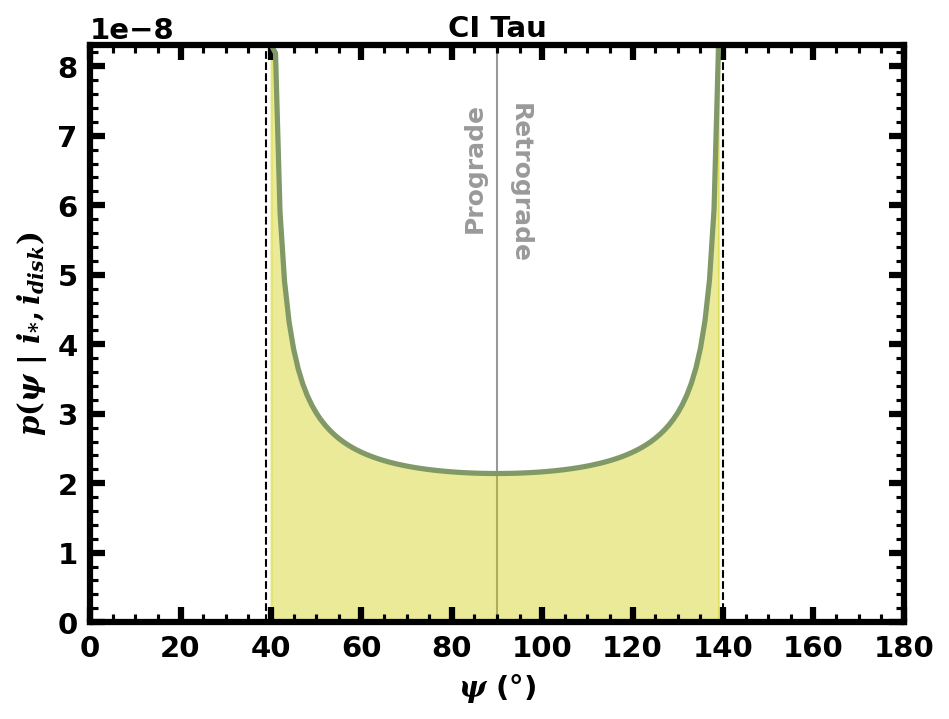

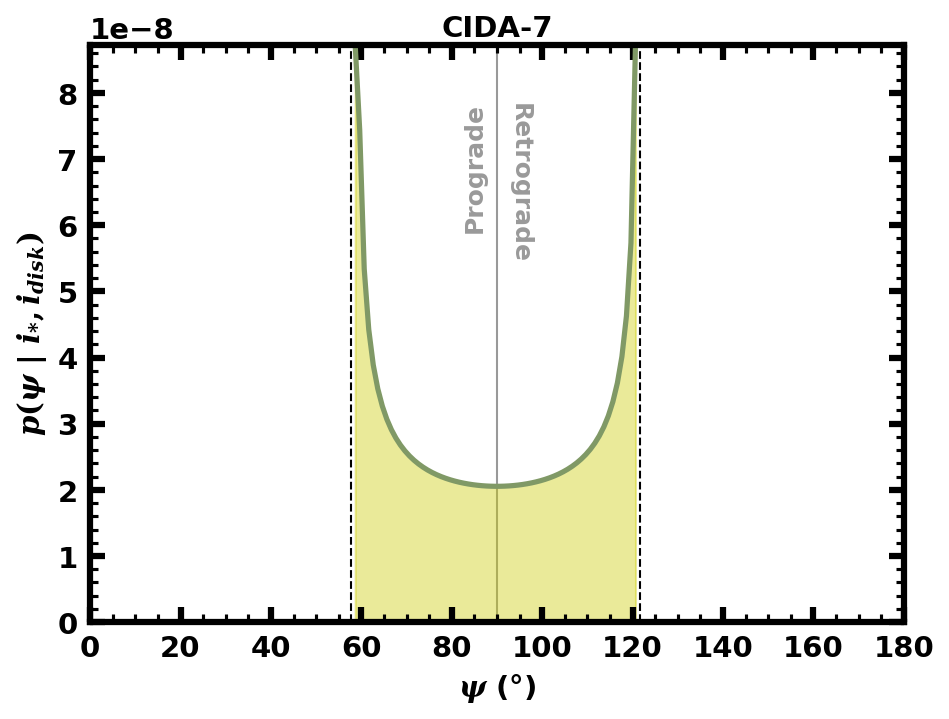

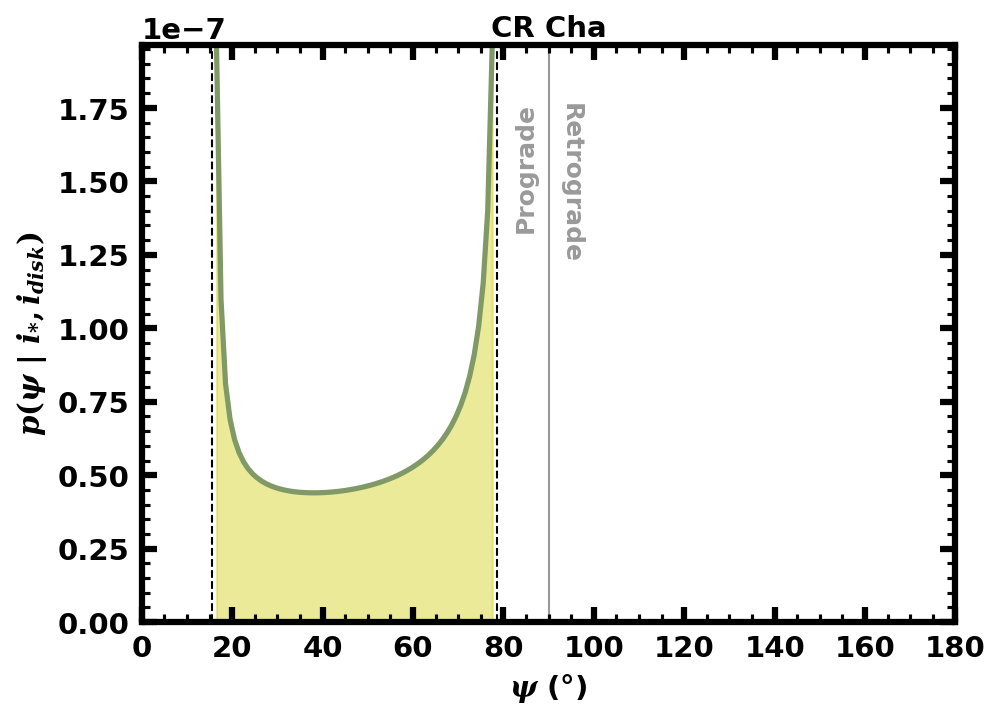

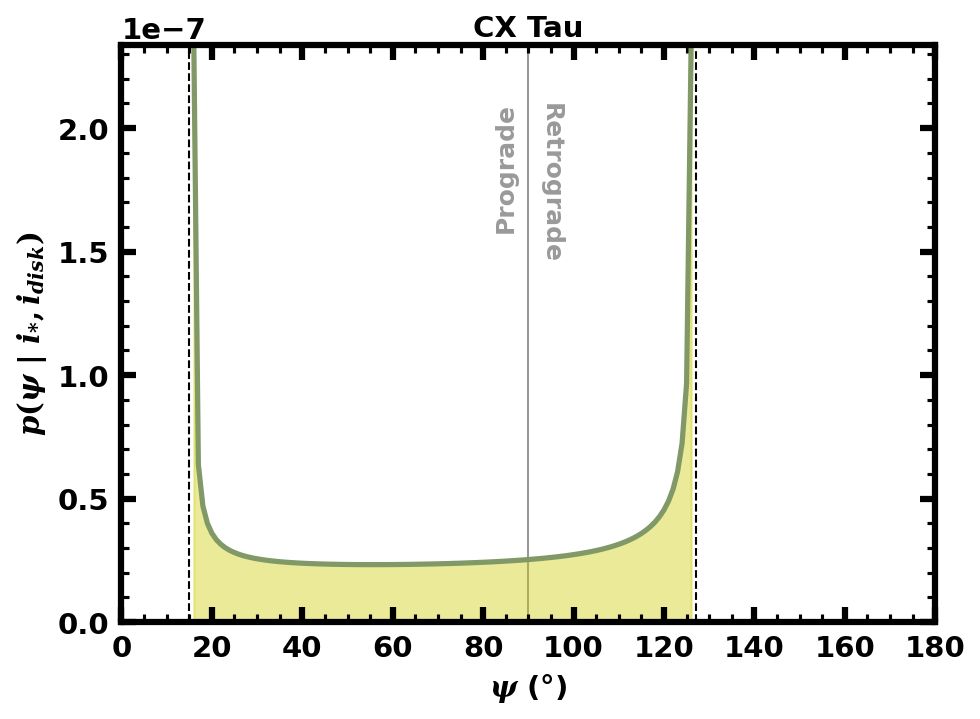

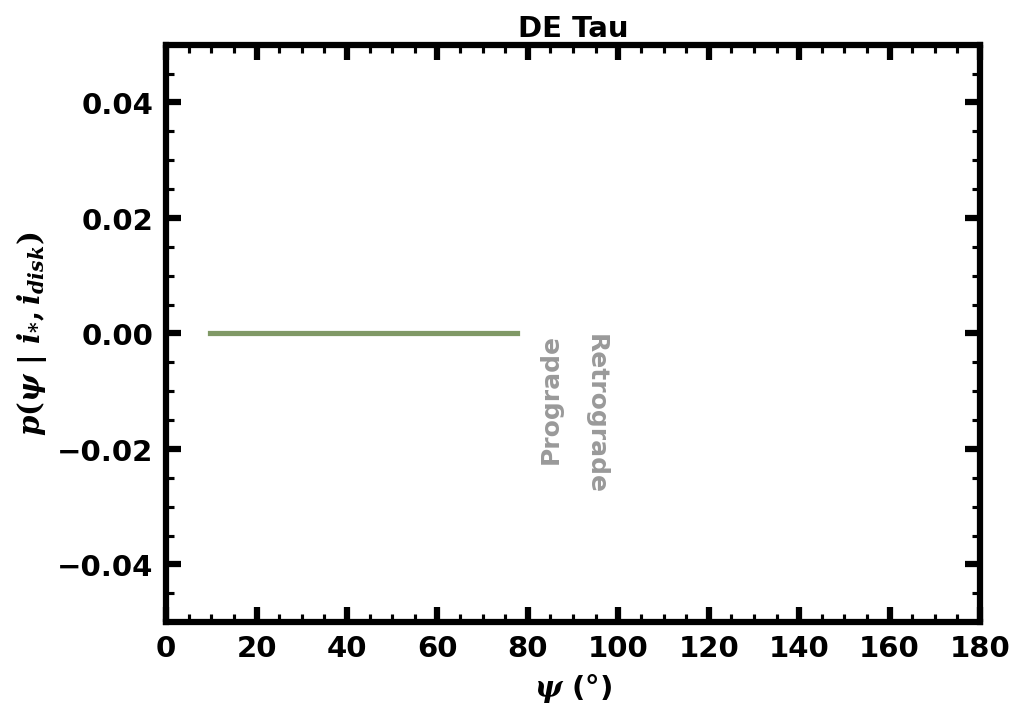

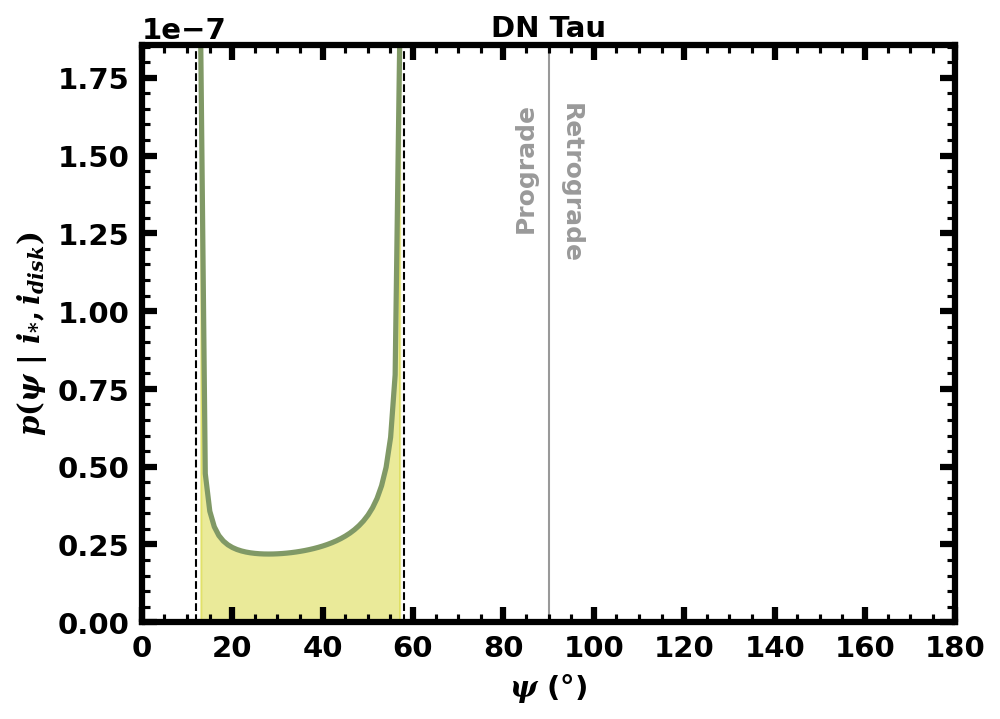

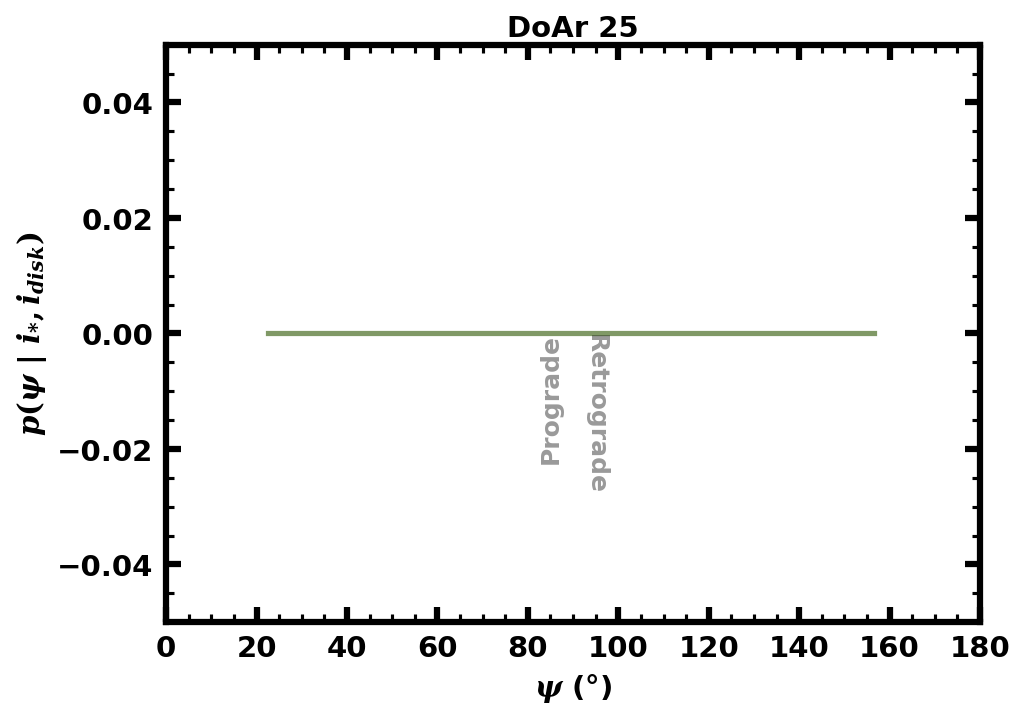

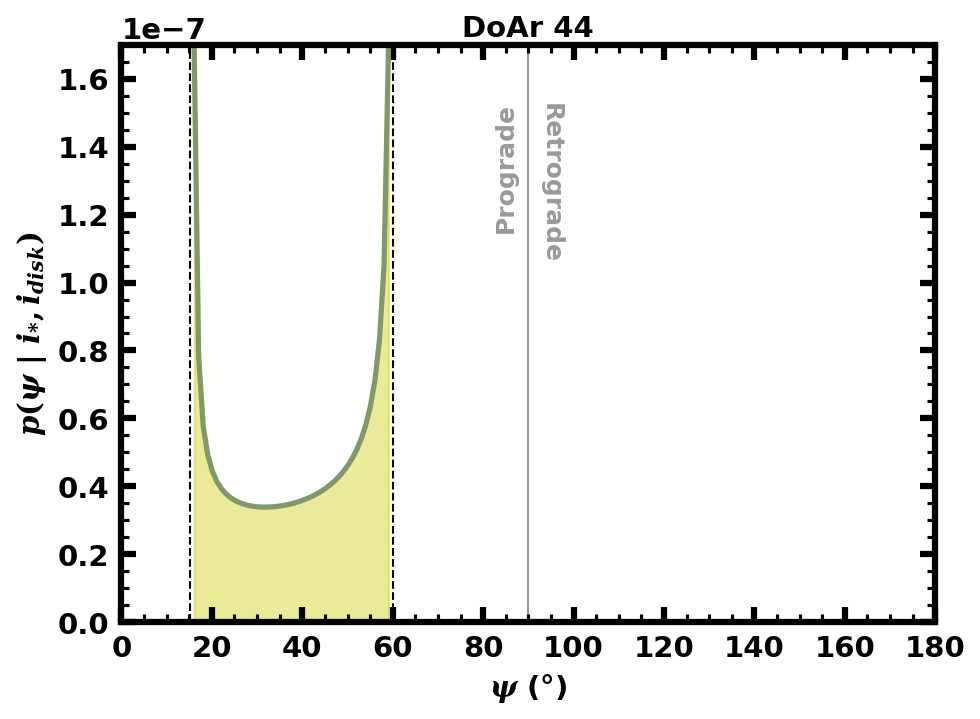

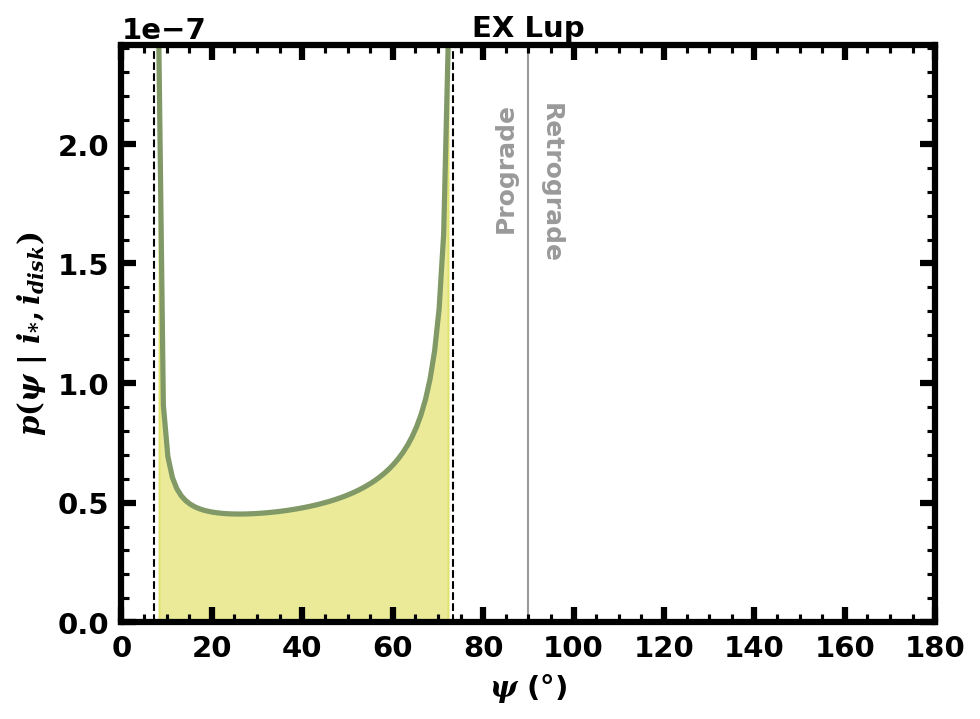

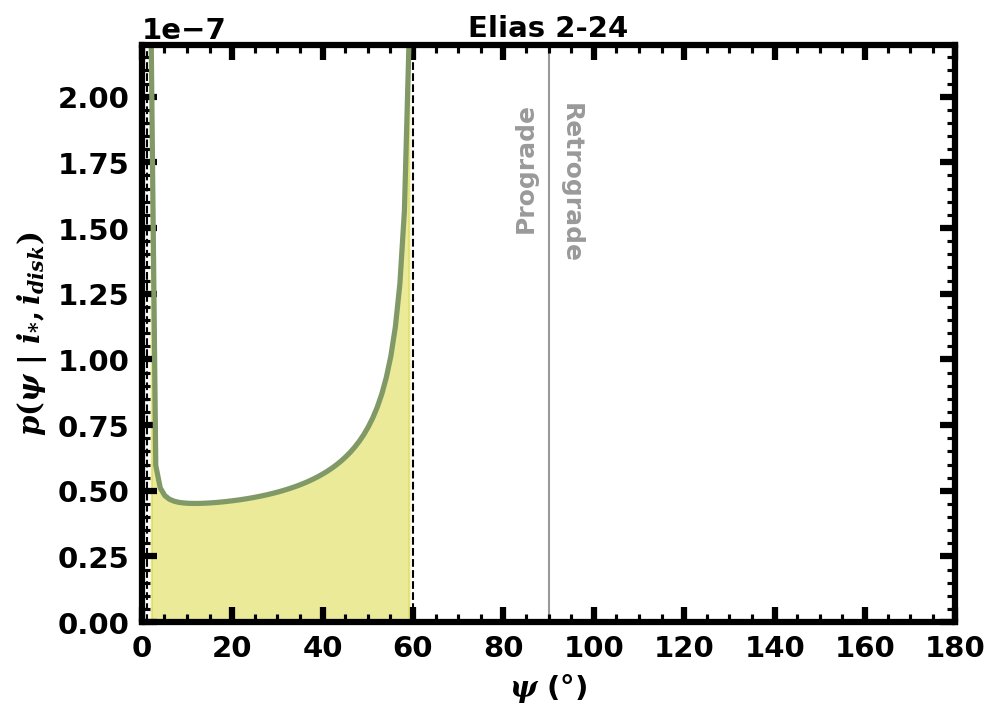

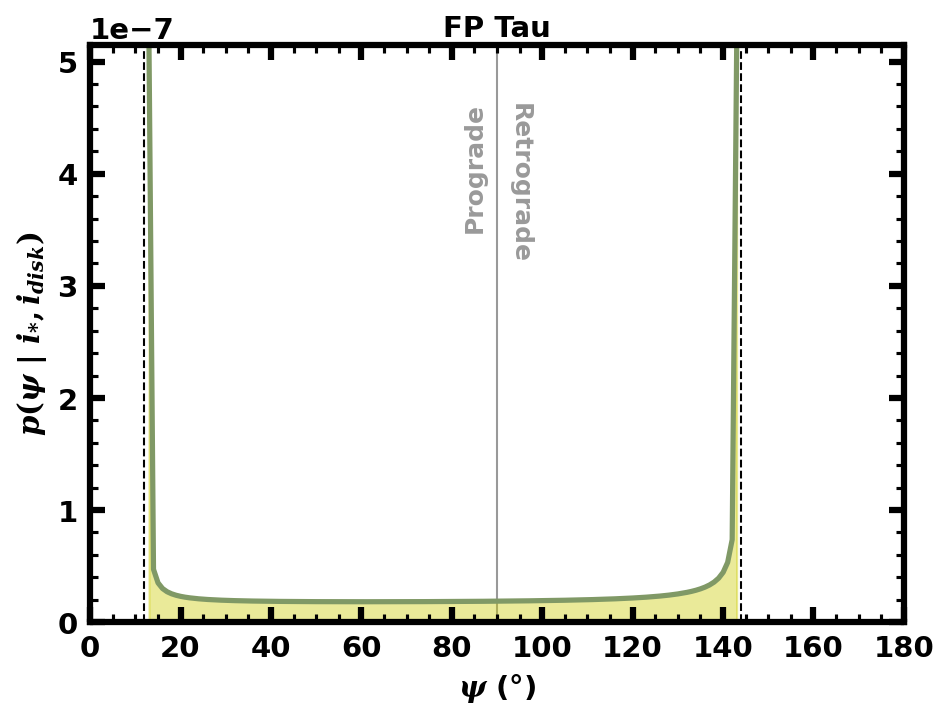

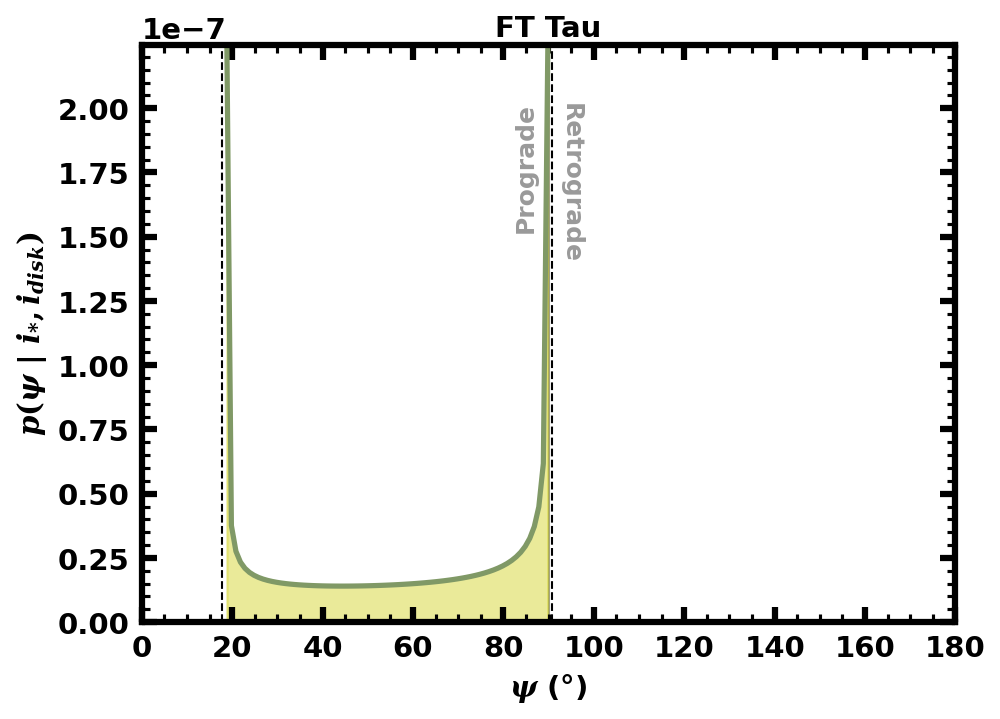

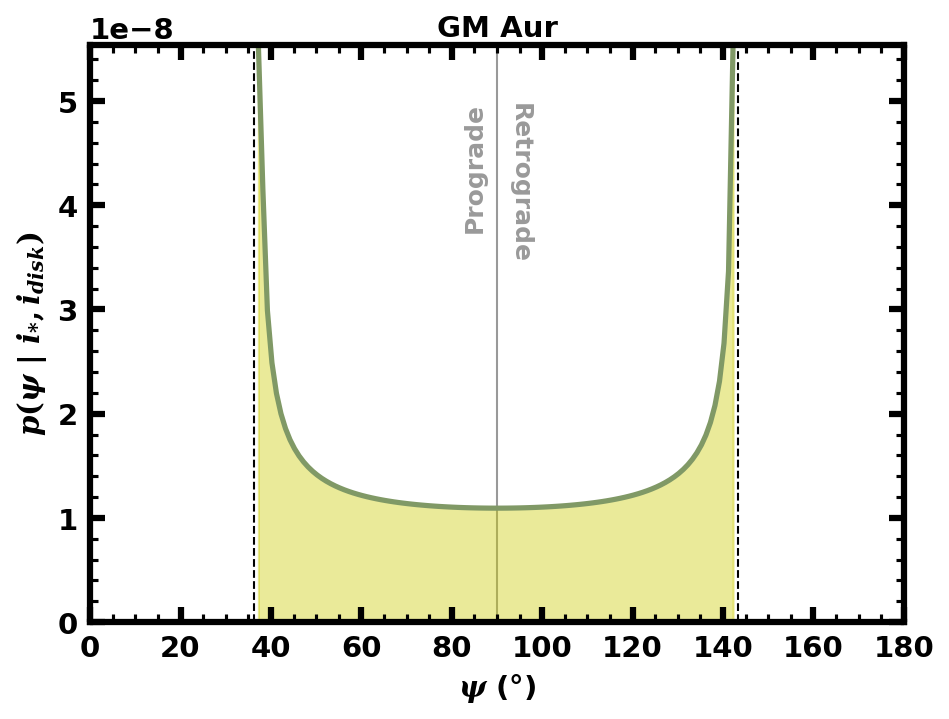

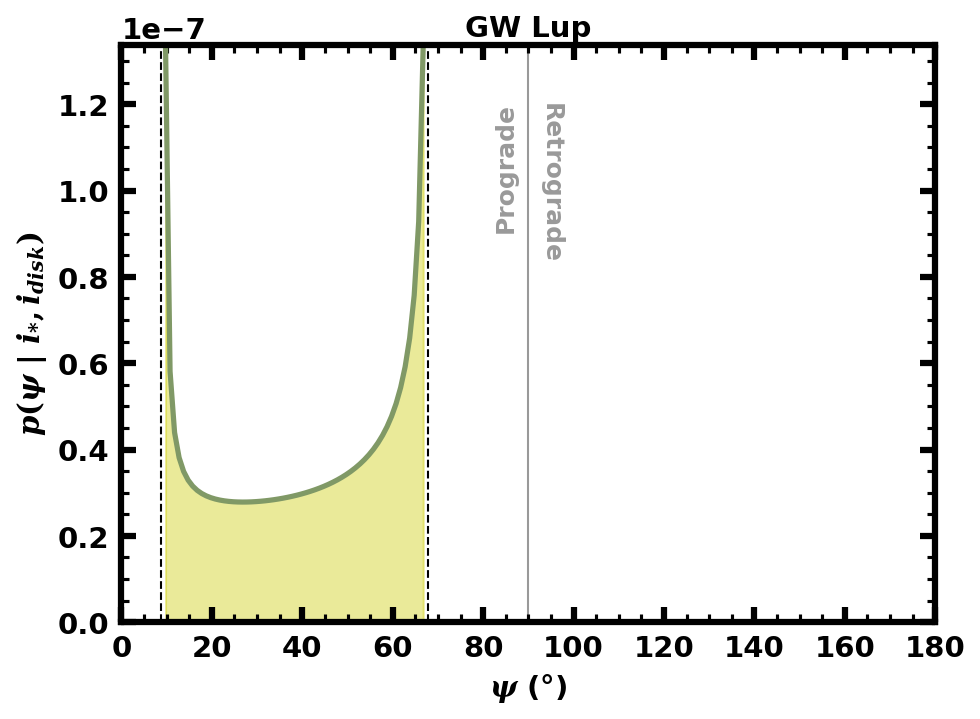

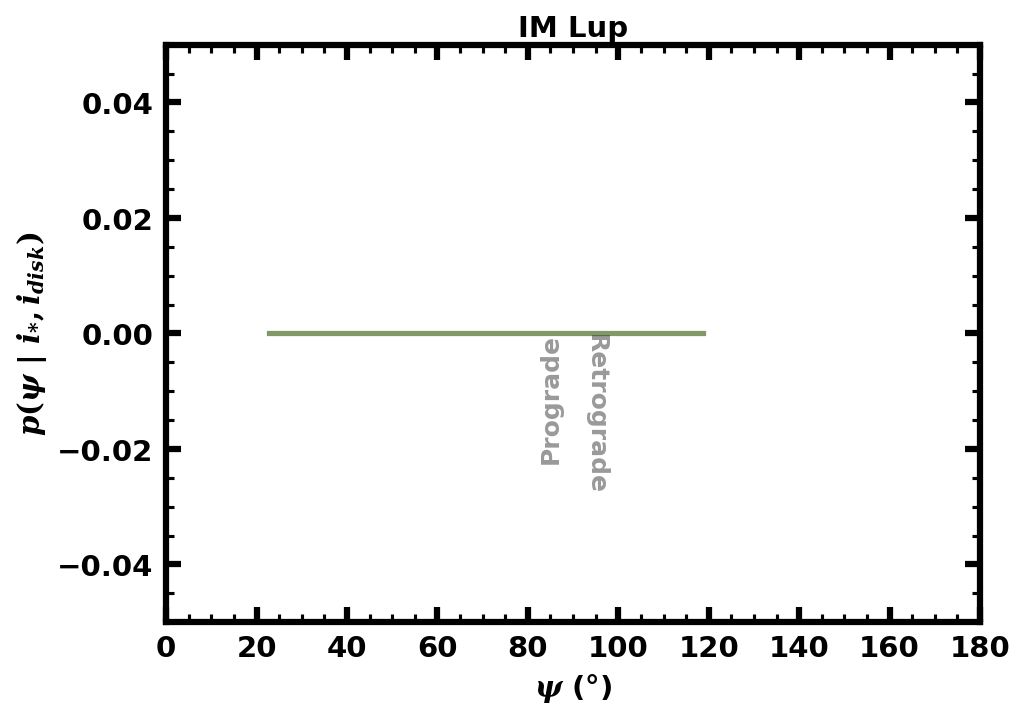

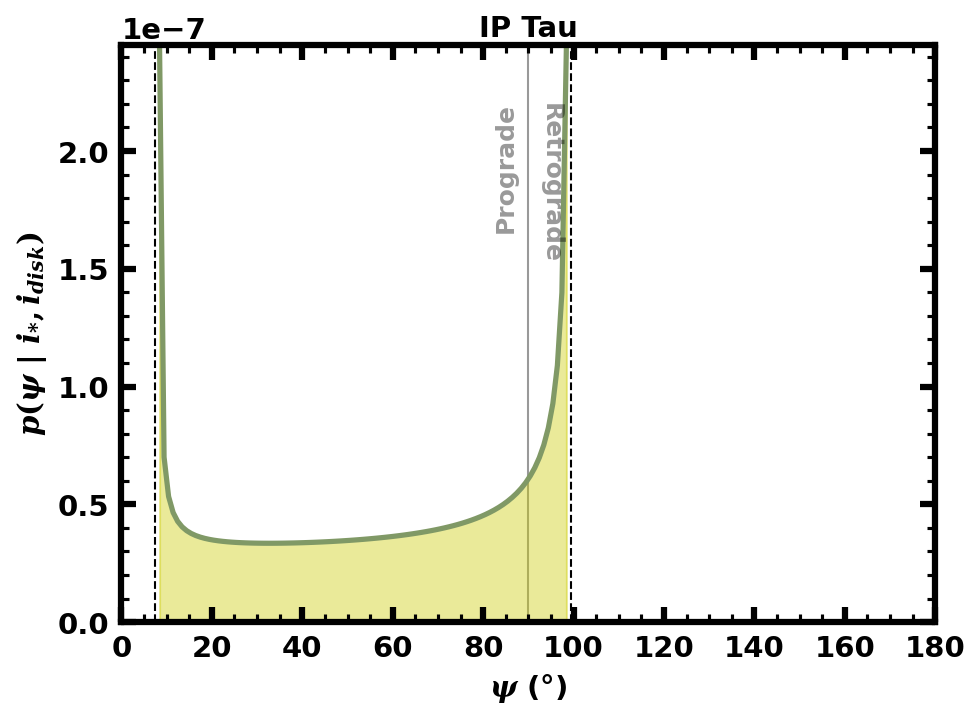

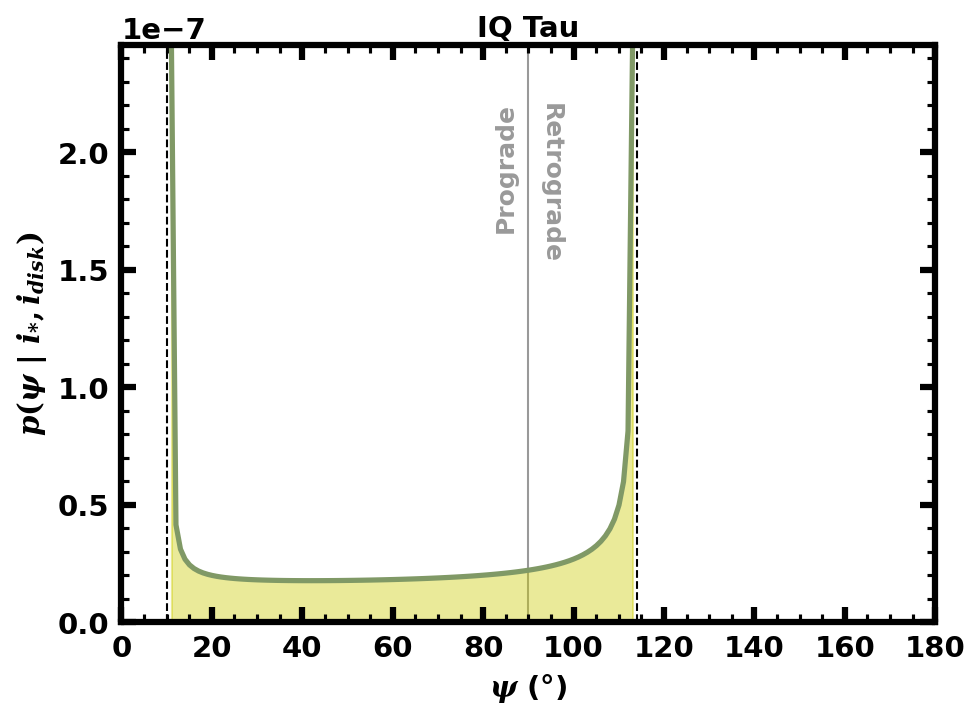

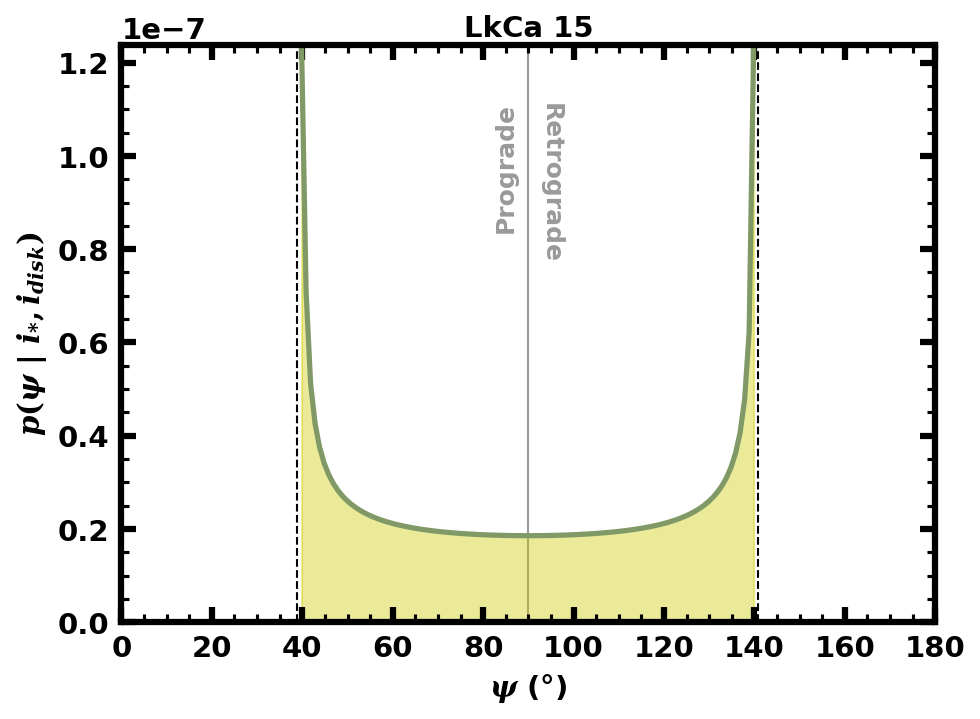

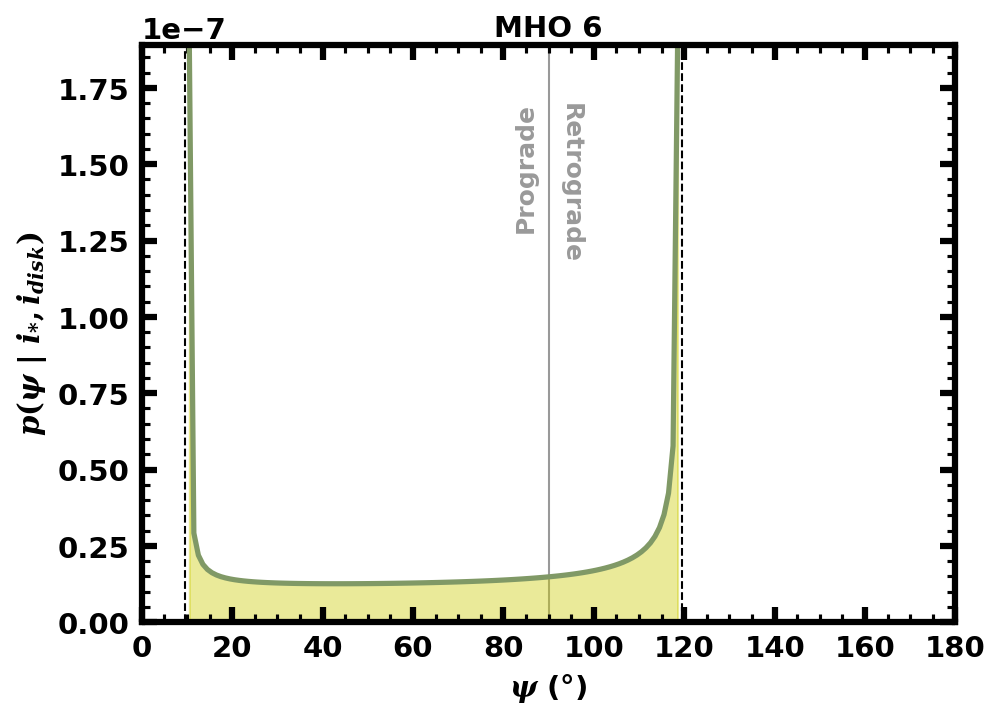

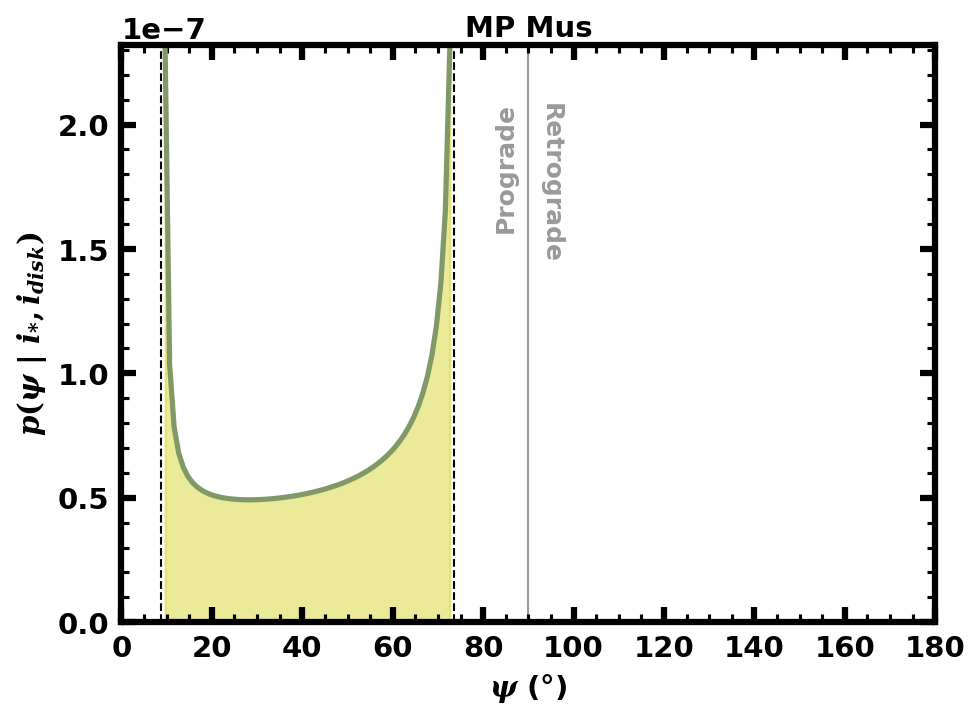

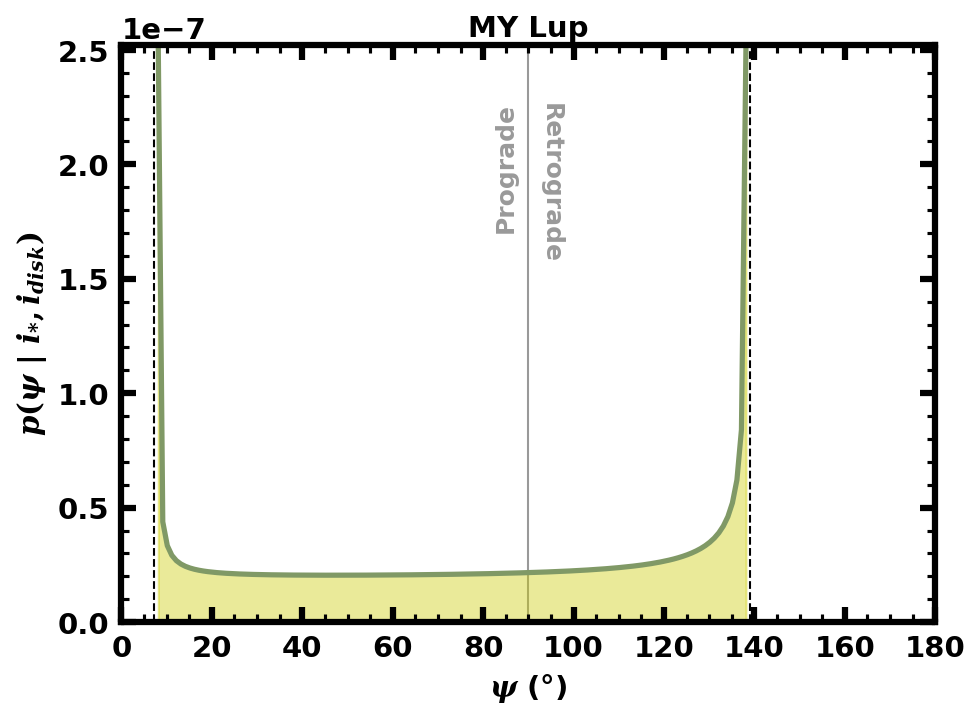

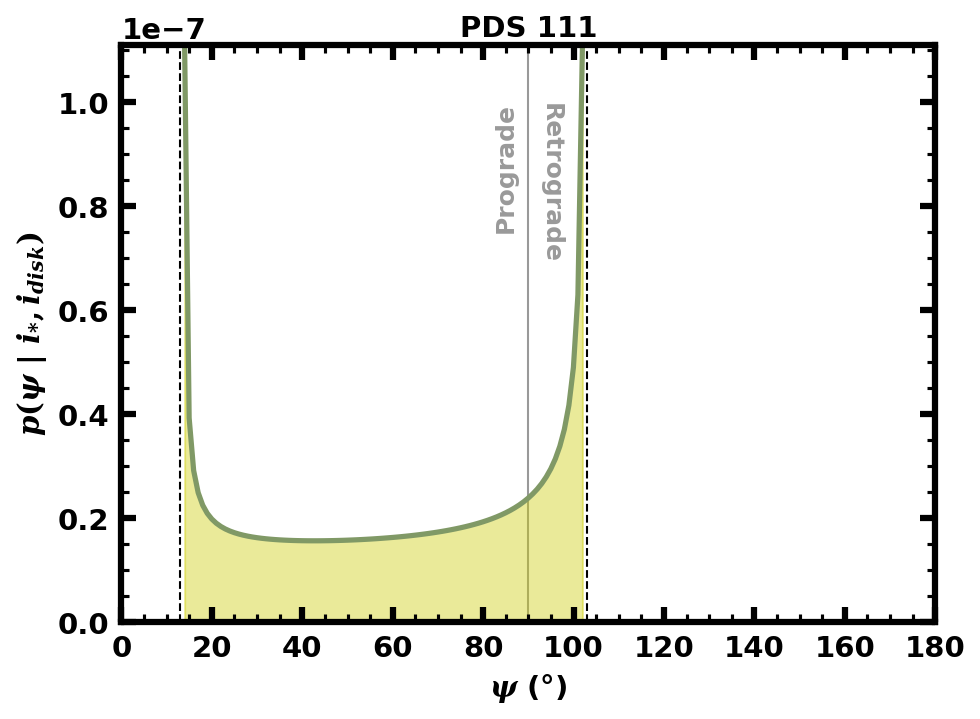

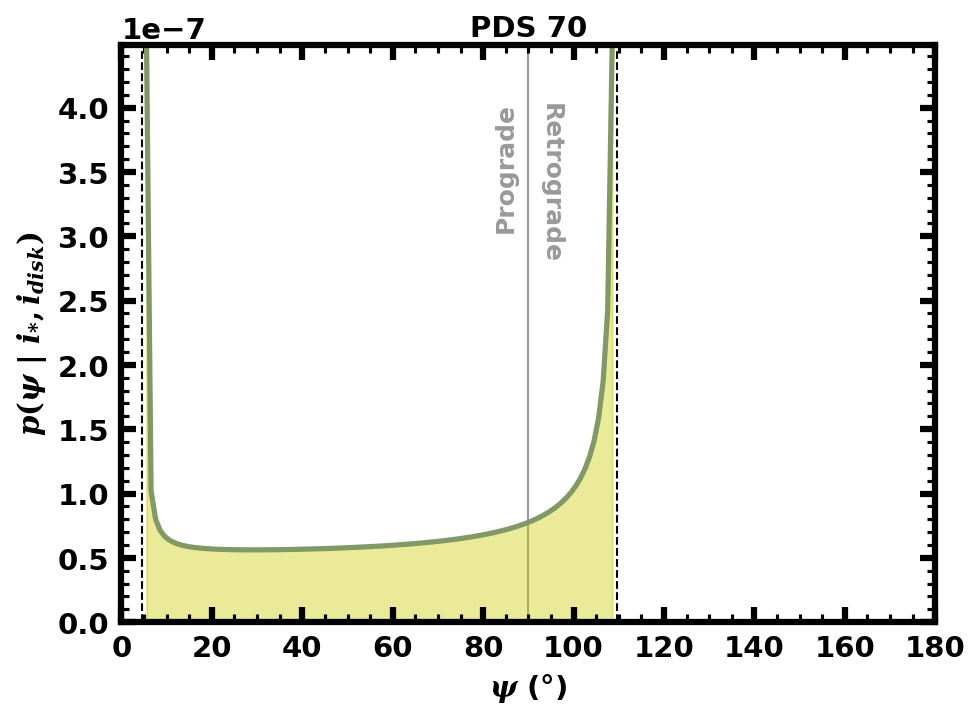

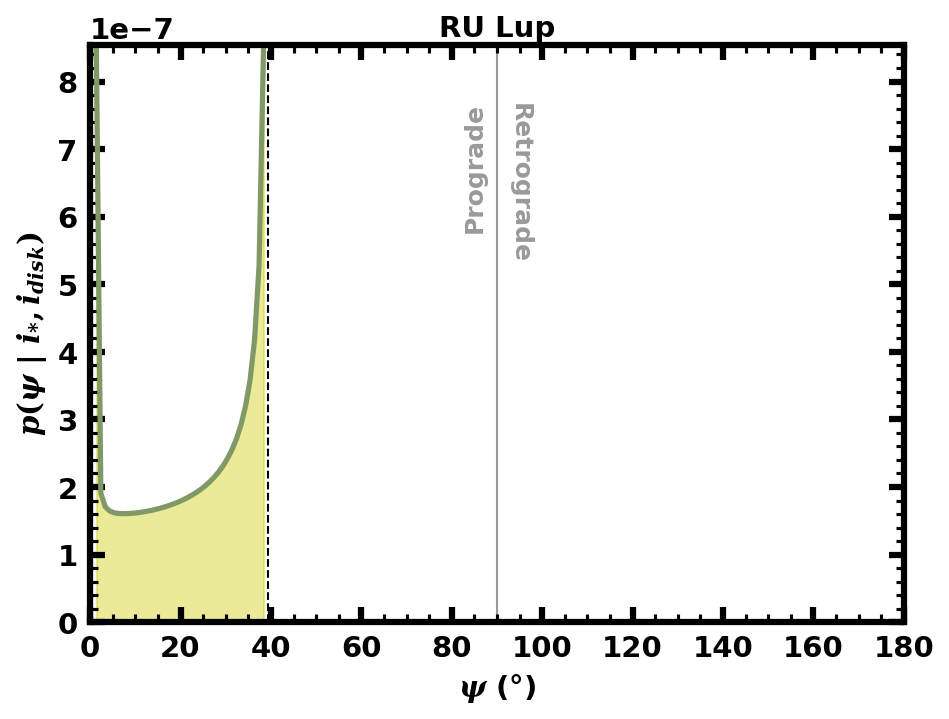

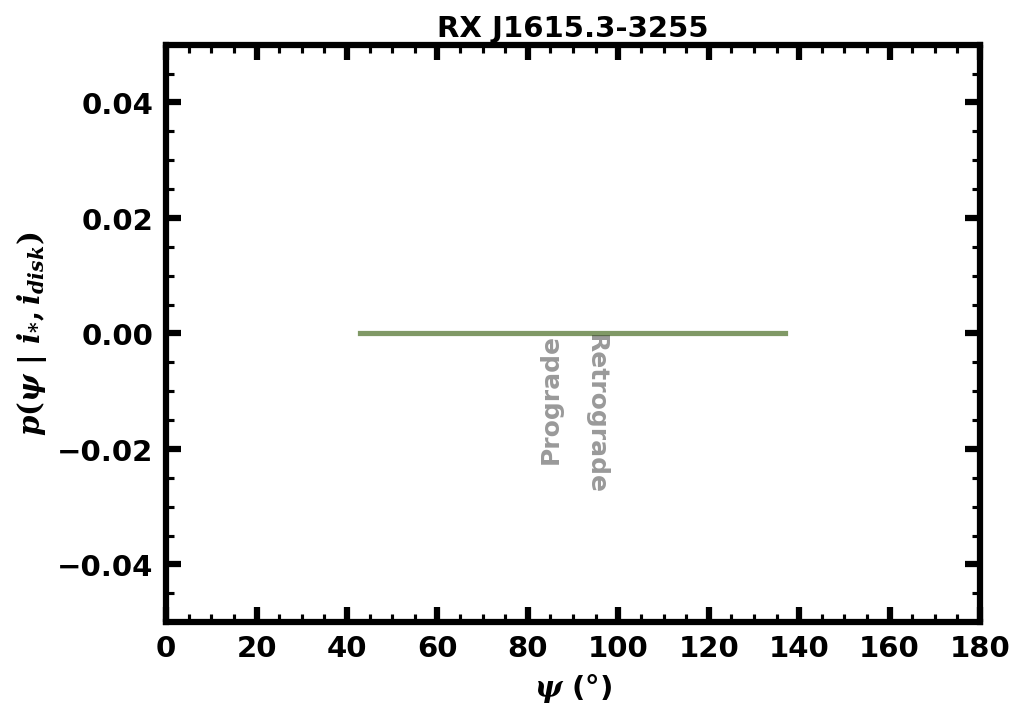

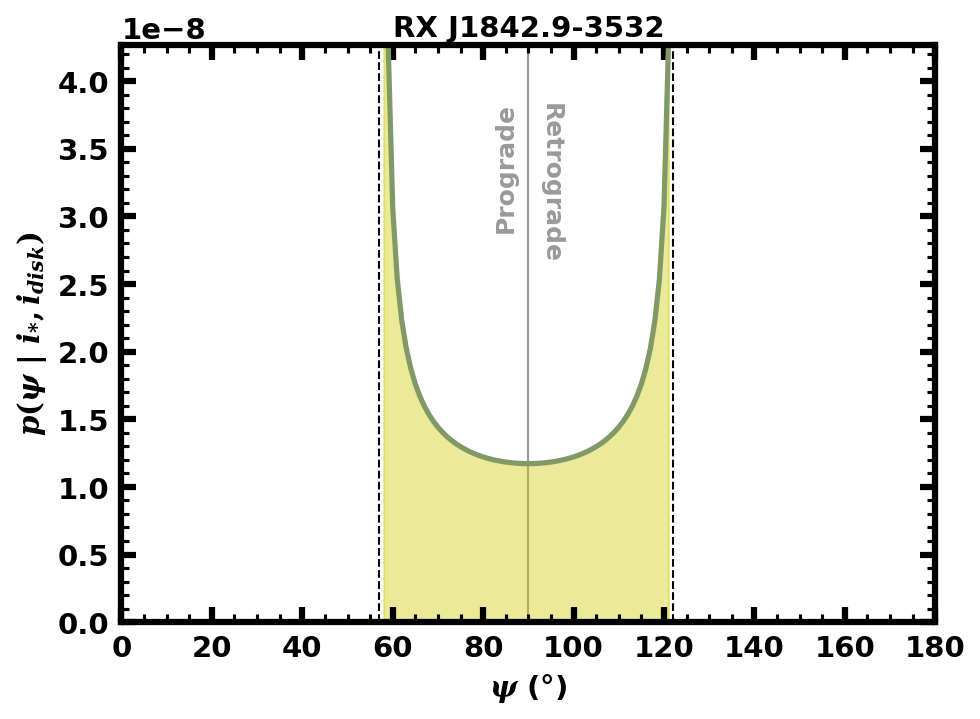

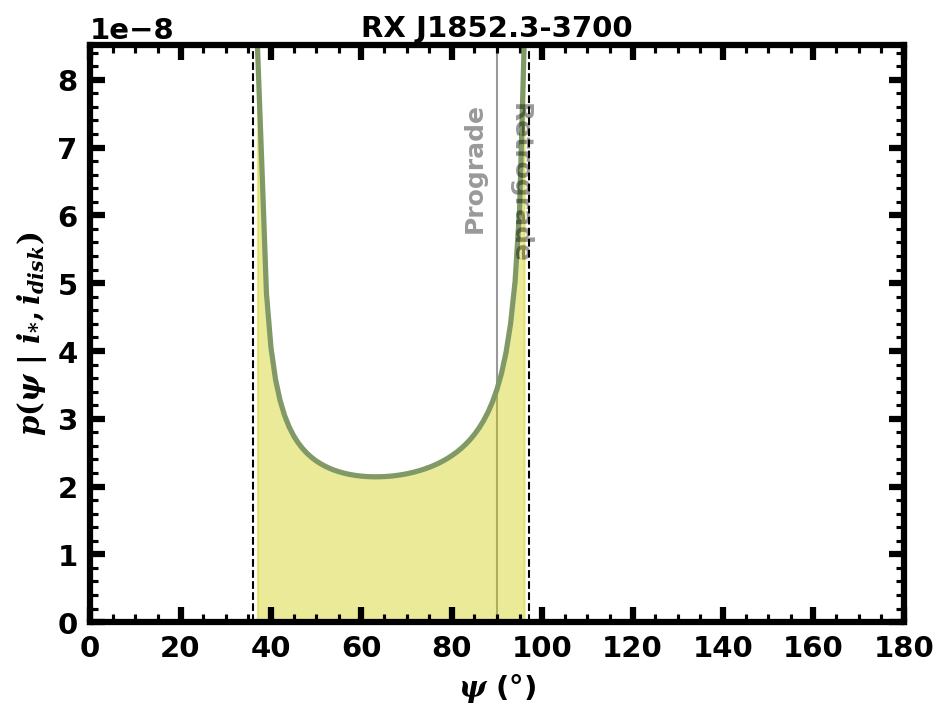

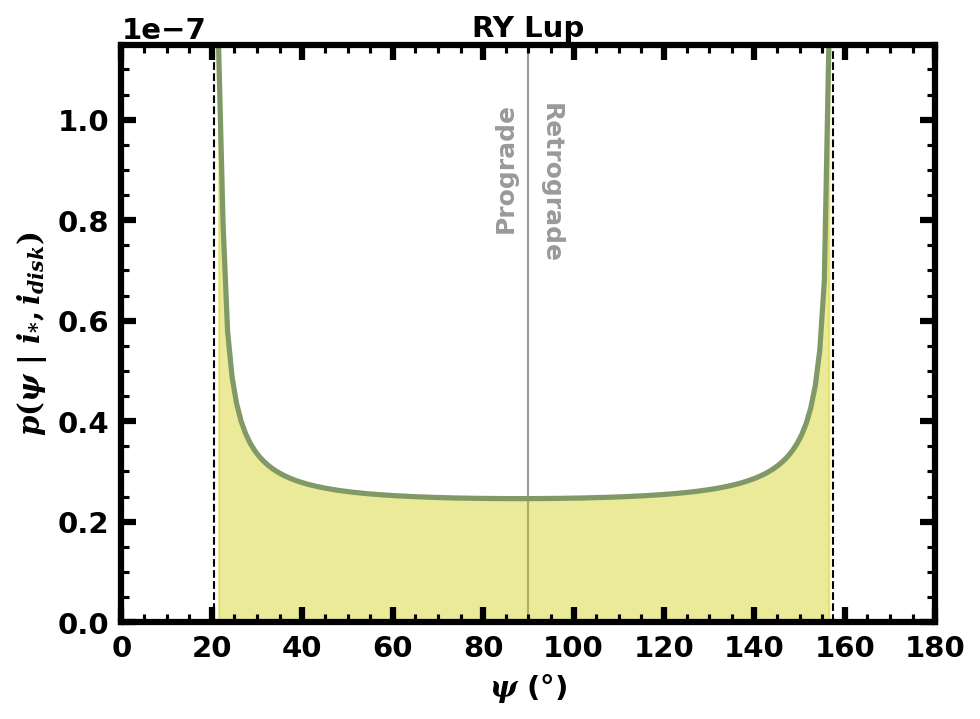

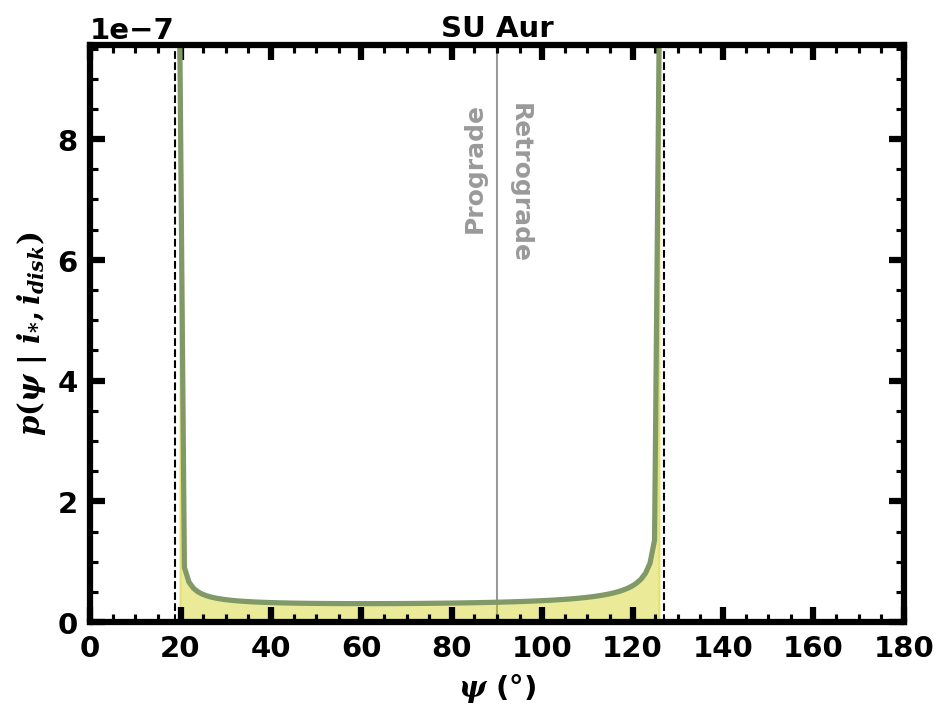

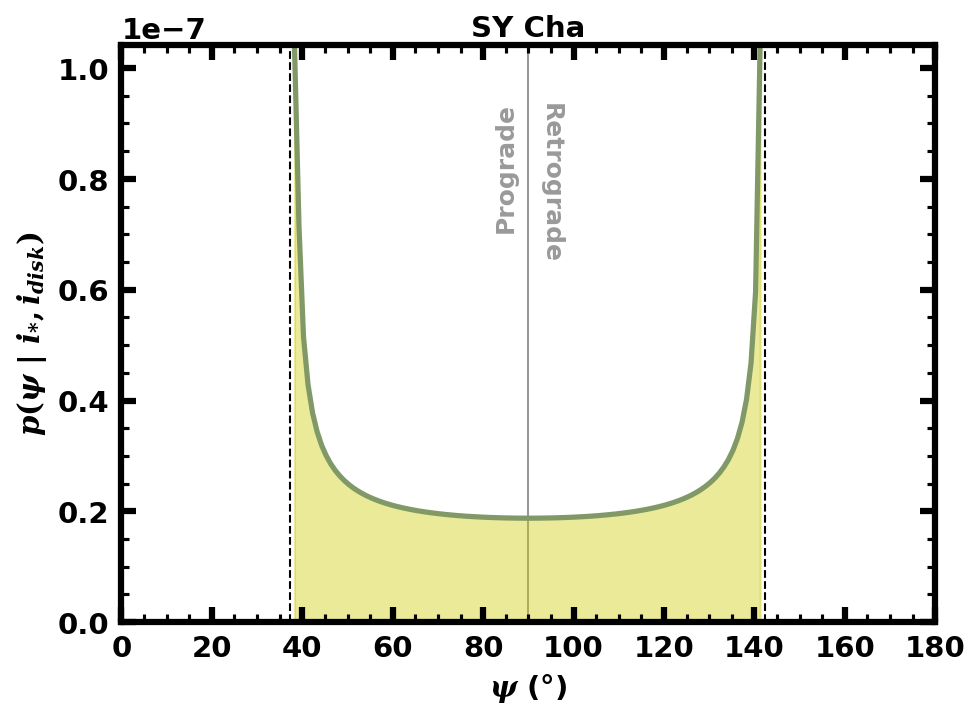

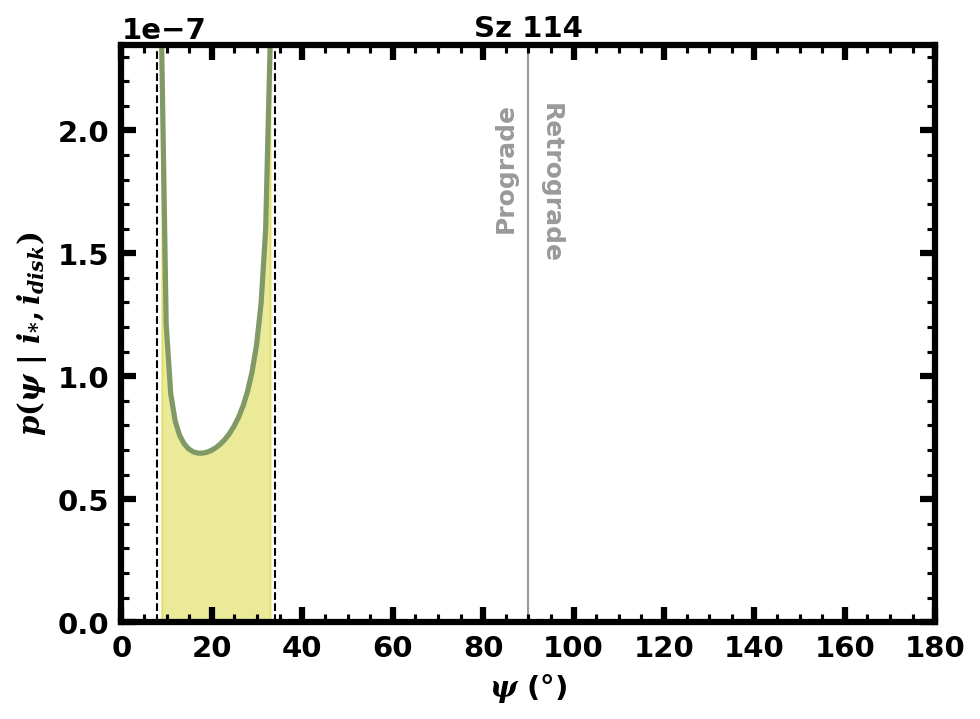

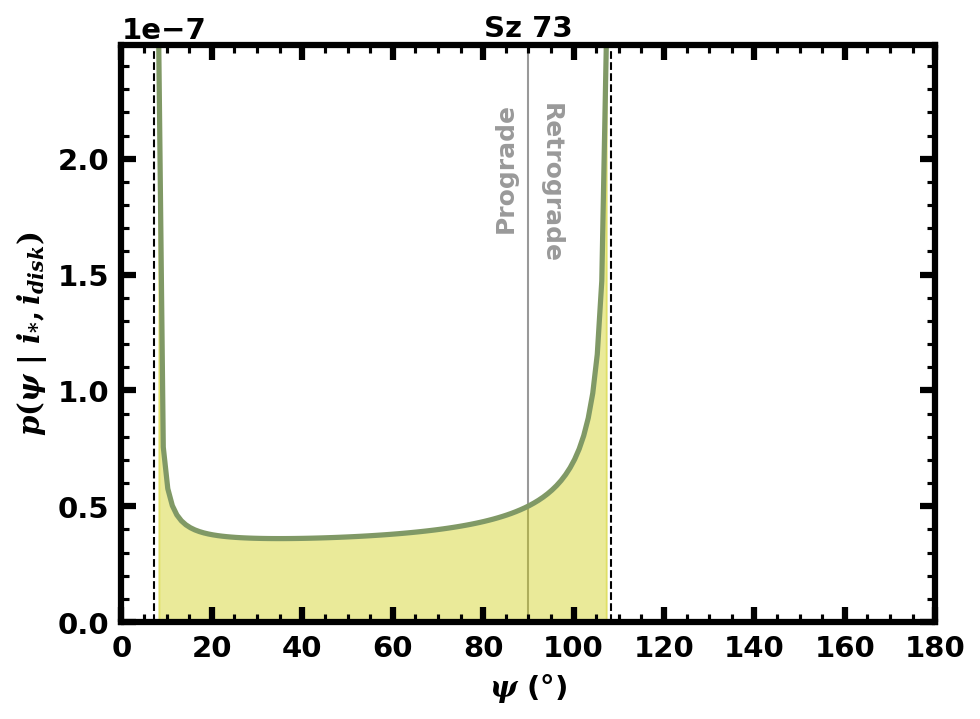

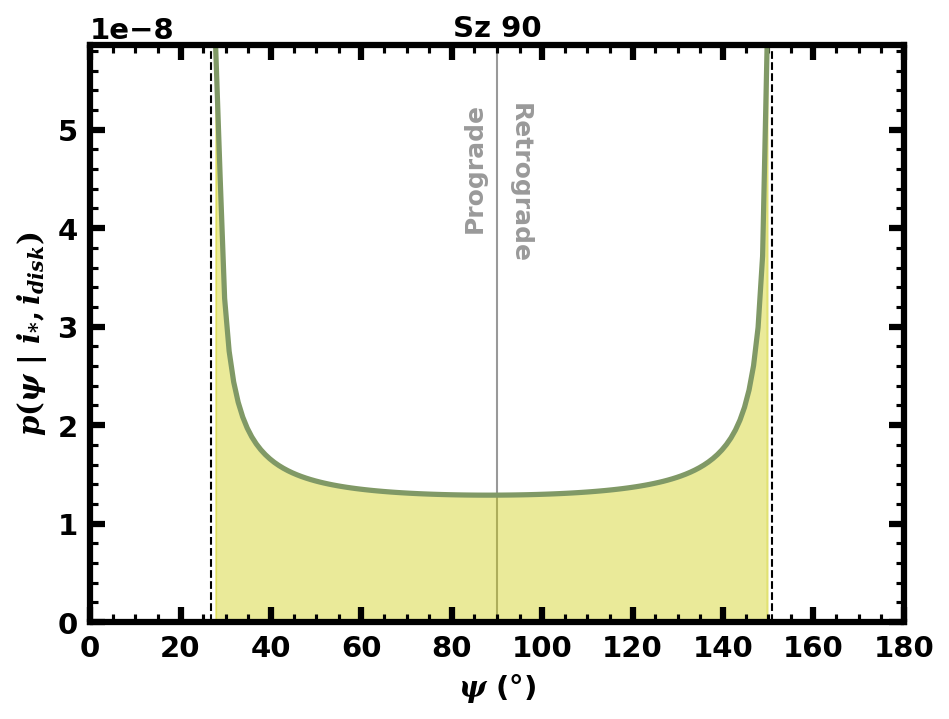

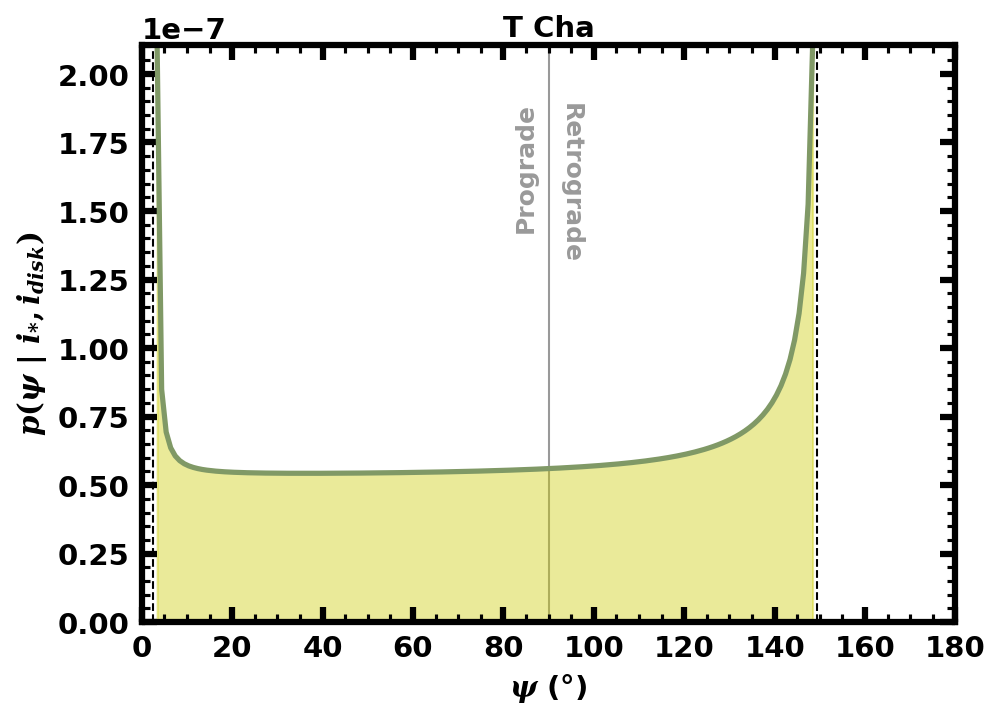

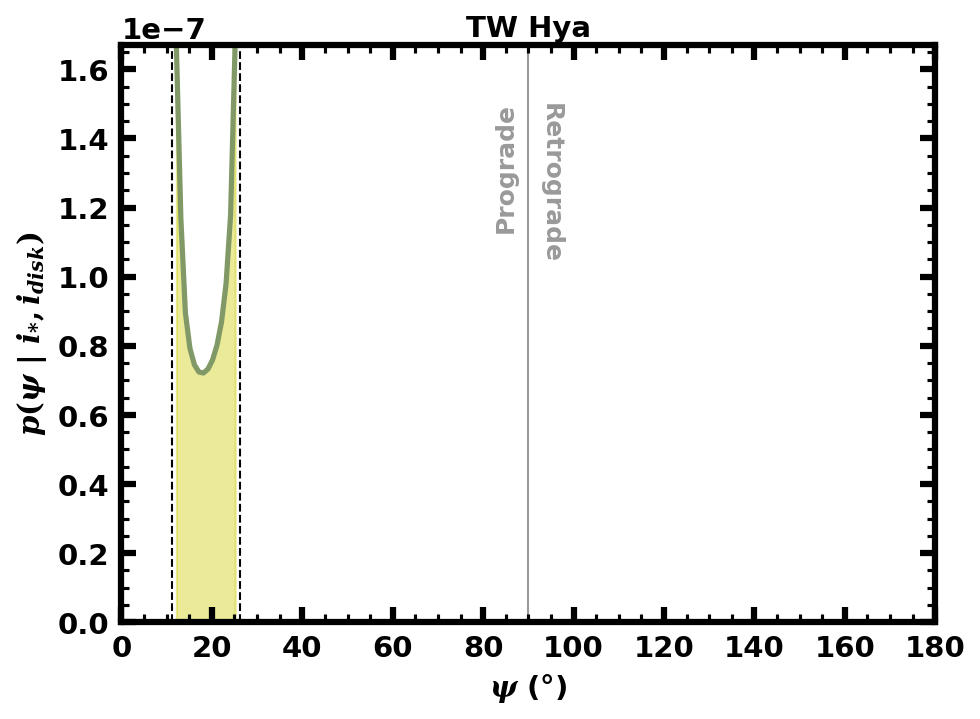

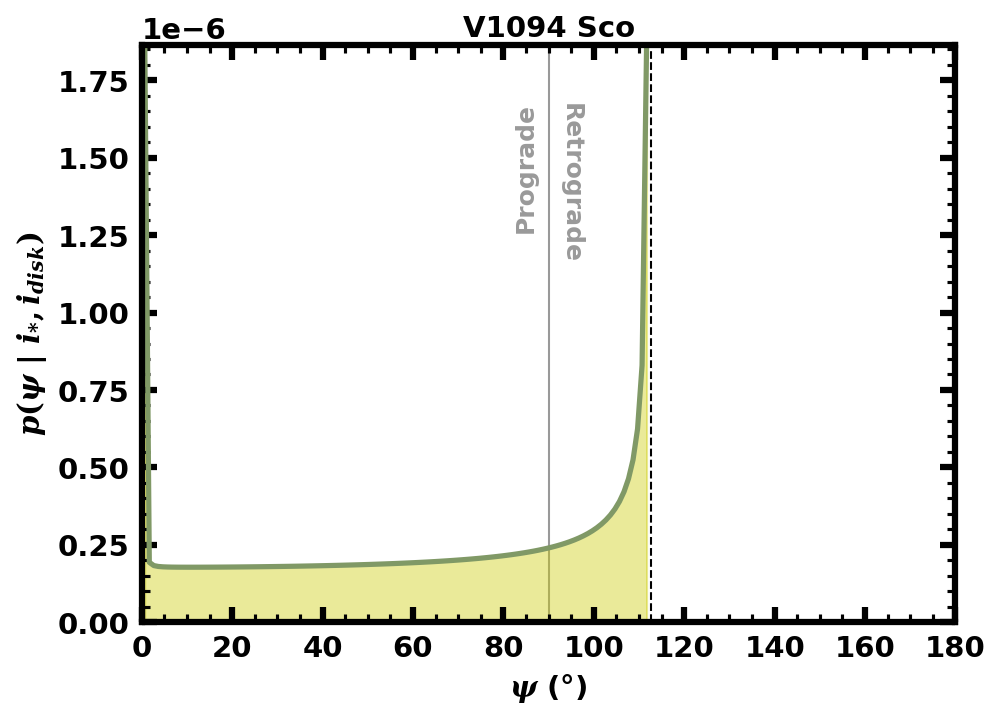

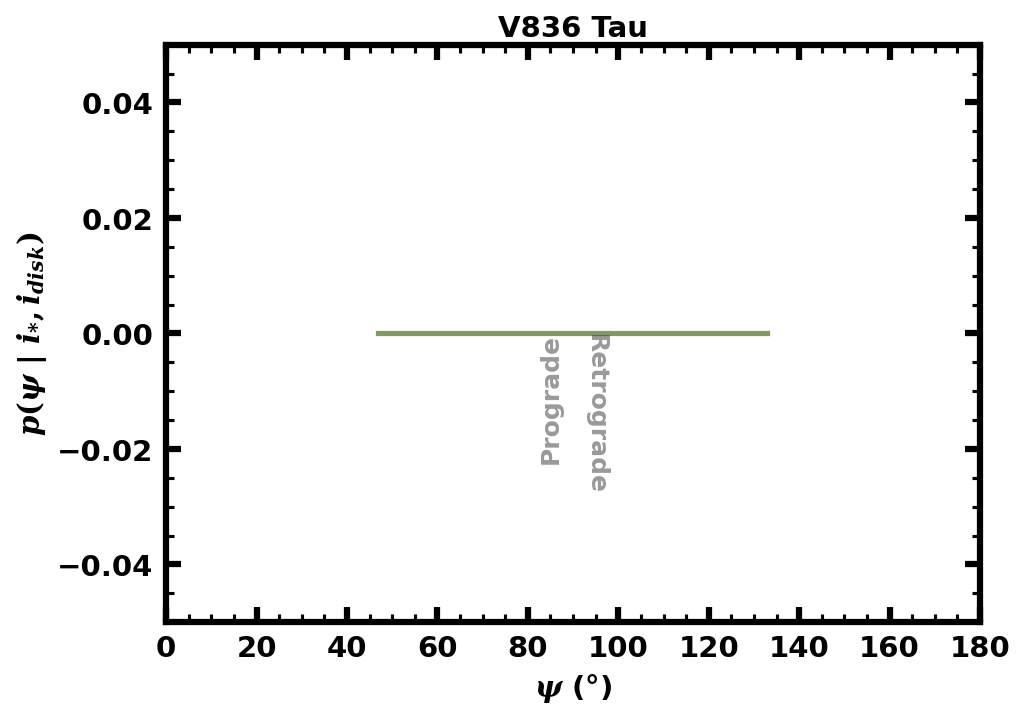

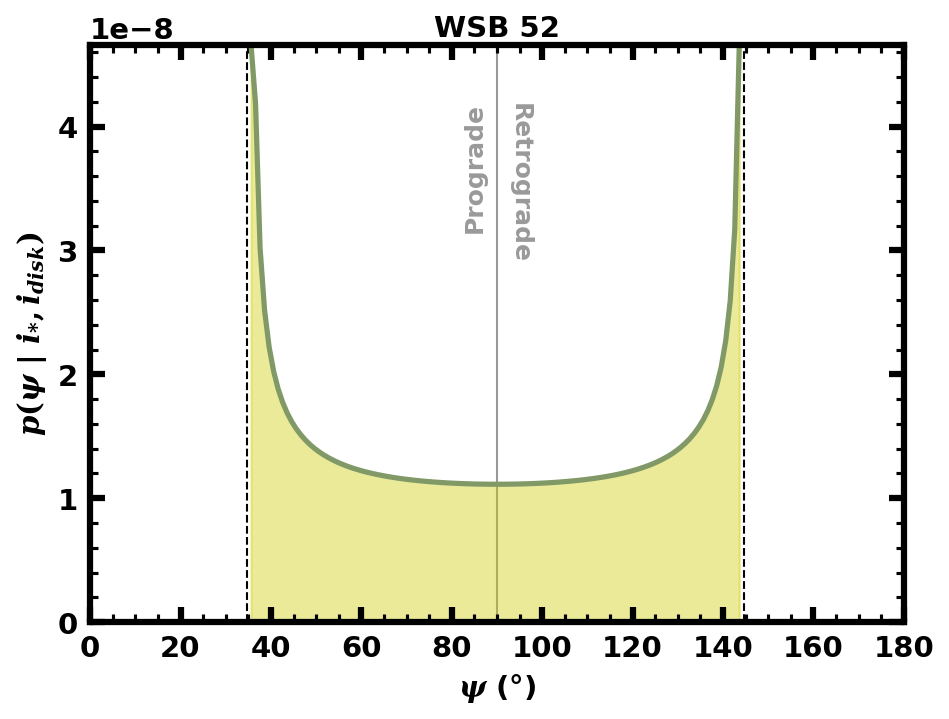

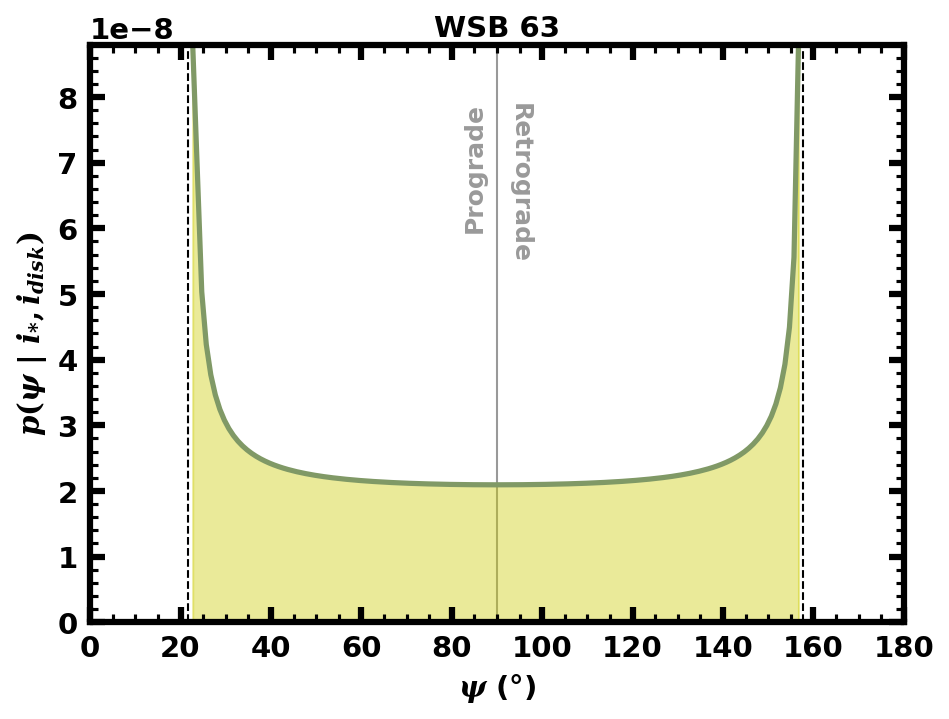

In [247]:
for test_targ in df_PD['Target'].values:

    print(test_targ)
    test_df = df_PD[df_PD['Target'] == test_targ]

    dx = 1
    istar = test_df['i star (deg)'].values[0]
    iplane = test_df['i disk (deg)'].values[0]
    print('minimum obliquity', test_df['disk diff'].values[0])
    print('istar', istar)
    print('idisk', iplane)
    print(' ')


    plotx, ploty = true_obliquity_posterior(i_star_deg=istar, i_plane_deg=iplane, di=dx)

    print_posterior = False

    if print_posterior == True:
        for  beep in range(len(plotx)):
            print(plotx[beep], ploty[beep])


    test_fig = plt.figure(figsize=(7, 5), dpi=150)
    ax = test_fig.add_subplot(111)
    ax.minorticks_on()

    ax.set_title(test_targ)
    ax.set_xlabel(r'$\psi$ ($\degree$)')
    ax.set_ylabel(r'$p(\psi$ | $i_{*}, i_{disk})$')

    xmin, xmax = 0, 180
    ymin, ymax = 0, np.nanmax(ploty)  # -0.04 * max(ploty), 1.14 * max(ploty)
    print(ymin, ymax)

    linecolor = '#809966'  # '#476685'
    fillcolor = '#cccc00'  # '#476685'

    ax.plot(plotx, ploty, color=linecolor)
    ax.fill_between(plotx, ploty, color=fillcolor, alpha=0.4)

    ax.plot([90, 90], [0, ymax], lw=1, color='#000000', alpha=0.4, zorder = -10)
    ax.plot([np.nanmin(plotx) - dx, np.nanmin(plotx) - dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)
    ax.plot([np.nanmax(plotx) + dx, np.nanmax(plotx) + dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)

    ax.text(90 - 5, 0.90 * np.nanmax(ploty), 'Prograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=90, color='#000000', alpha=0.4)
    ax.text(90 + 5, 0.90 * np.nanmax(ploty), 'Retrograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=270, color='#000000', alpha=0.4)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # SAVE THE FIGURE
    save_true_obliquity_string = 'True_Obliquities/' + test_targ + '_TrueObliquity_' + light_or_dark_dext + '_' + transparent_text + '_' + which_dataset + '_' + date_str + '.pdf'

    if plot_transparent == True:
        test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=True)
    else:
        test_fig.savefig(test_figures_directory + save_true_obliquity_string, dpi=300, transparent=False)

    